# Fit SPICE to dezfouli_2019 data

- Load dezfouli2019.csv
- Convert to SPICE dataset
- Fit SPICE
- Analyze results

In [1]:
from spice.utils.convert_dataset import convert_dataset

dataset, experiment_list, df, dynamics = convert_dataset(file='dezfouli2019.csv')

/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from spice.resources.rnn_utils import split_data_along_sessiondim

dataset_train, dataset_test = split_data_along_sessiondim(dataset, [3])

In [7]:
# Fit SPICE naively

from spice.estimator import SpiceEstimator
from spice.precoded import RescorlaWagnerRNN, RESCOLA_WAGNER_CONFIG, Weinhardt2025RNN, WEINHARDT_2025_CONFIG

n_actions = dataset_train.ys.shape[-1]
n_participants = len(dataset_train.xs[..., -1].unique())

spice_estimator = SpiceEstimator(
    rnn_class=RescorlaWagnerRNN,
    spice_config=RESCOLA_WAGNER_CONFIG,
    n_actions=n_actions,
    n_participants=0,
    learning_rate=1e-2,
    epochs=1024,
    verbose=False,
    bagging=True,
    scheduler=False,
    train_test_ratio=[3],
    spice_library_polynomial_degree=2,
)

spice_estimator.fit(dataset_train.xs, dataset_train.ys)

spice_estimator.print_spice_model()


Training the RNN...
Epoch 1024/1024 --- L(Train): 0.7028860; Time: 0.07s; Convergence: 2.13e-03
Maximum number of training epochs reached.


  0%|          | 0/101 [00:00<?, ?it/s]/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  1%|          | 1/101 [00:00<00:16,  5.93it/s]/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  2%|▏         | 2/101 [00:00<00:16,  6.00it/s]/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  3%|▎         | 3/101 [00:00<00:16,  6.01it/s]/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  4%|▍      

SPICE modules:
(x_value_reward_chosen)[k+1] = 5.948 1 + 0.405 x_value_reward_chosen[k]


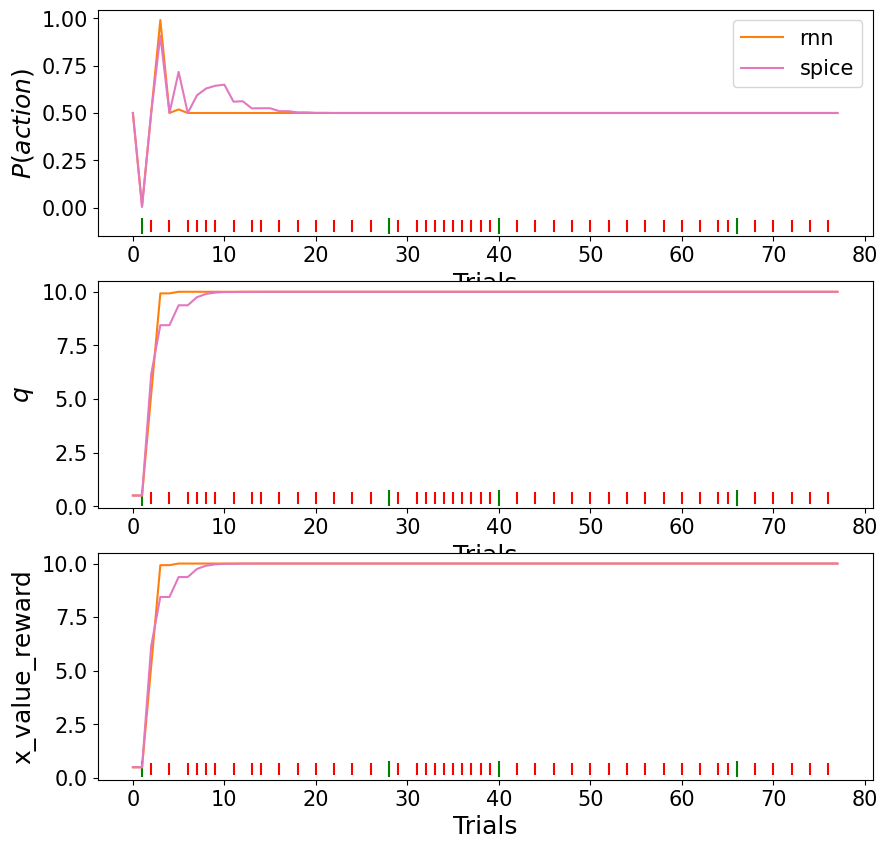

In [8]:
from spice.utils.plotting import plot_session
from matplotlib import pyplot as plt

# get analysis plot
agents = {'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

In [11]:
import torch

estimator = SpiceEstimator(
    rnn_class=Weinhardt2025RNN,
    spice_config=WEINHARDT_2025_CONFIG,
    n_actions=n_actions,
    n_participants=n_participants,
    epochs=1024,
    bagging=True,
    scheduler=False,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    train_test_ratio=[3],
    l1_weight_decay=0,
    l2_weight_decay=0.0005,
    dropout=0.5,
    learning_rate=1e-3,
    use_optuna=True,
    spice_library_polynomial_degree=2,
    # simulation_environment=simulation_environment,
    # n_sessions_off_policy=1,
    # spice_optim_regularization=0.01,
    # spice_optim_threshold=0.05,
    optuna_threshold=0.,
    # save_path_rnn=args.model,
    # save_path_spice=args.model.replace('rnn', 'spice'),
)

In [12]:
estimator.fit(dataset_train.xs, dataset_train.ys)

estimator.print_spice_model()


Training the RNN...
Epoch 1024/1024 --- L(Train): 0.4981593; Time: 0.38s; Convergence: 7.11e-03
Maximum number of training epochs reached.


  0%|          | 0/101 [00:00<?, ?it/s][I 2025-10-15 10:22:40,038] A new study created in memory with name: no-name-f904814e-1ac5-4991-96cb-034b6aa9cf34


Likelihoods before optuna fitting: RNN = 0.37868; SPICE =  0.28581; Diff = 0.09288
Using optuna to find a better set of pysindy parameters for participant 0...


                                       
  0%|          | 0/101 [00:01<?, ?it/s]

[I 2025-10-15 10:22:40,738] Trial 0 finished with value: 0.01504141789339123 and parameters: {'optimizer_alpha': 0.043648334024148513, 'optimizer_threshold': 0.03082003033038871}. Best is trial 0 with value: 0.01504141789339123.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                       
  0%|          | 0/101 [00:02<?, ?it/s]                                                               

[I 2025-10-15 10:22:41,450] Trial 1 finished with value: 0.010783980285804688 and parameters: {'optimizer_alpha': 0.17795779306280277, 'optimizer_threshold': 0.013032197414714298}. Best is trial 1 with value: 0.010783980285804688.


                                       
Best trial: 2. Best value: 0.00905174:   6%|▌         | 3/50 [00:02<00:34,  1.37it/s, 2.18/600 seconds]


[I 2025-10-15 10:22:42,222] Trial 2 finished with value: 0.009051738237877355 and parameters: {'optimizer_alpha': 0.6480813011335107, 'optimizer_threshold': 0.070132819306129}. Best is trial 2 with value: 0.009051738237877355.


  1%|          | 1/101 [00:03<06:04,  3.65s/it]

Likelihoods after optuna fitting: RNN = 0.37868; SPICE =  0.28581 -> 0.33221, Diff = 0.09288 -> 0.04648


[I 2025-10-15 10:22:43,697] A new study created in memory with name: no-name-7578fcd5-e72c-495b-a936-ba835b2071eb


Likelihoods before optuna fitting: RNN = 0.82832; SPICE =  0.8251; Diff = 0.00323
Using optuna to find a better set of pysindy parameters for participant 1...


                                               
Best trial: 0. Best value: 0.00591153:   2%|▏         | 1/50 [00:00<00:35,  1.39it/s, 0.72/600 seconds]


[I 2025-10-15 10:22:44,416] Trial 0 finished with value: 0.005911529902898967 and parameters: {'optimizer_alpha': 0.3318397333937614, 'optimizer_threshold': 0.03610180948141824}. Best is trial 0 with value: 0.005911529902898967.


  2%|▏         | 2/101 [00:05<04:37,  2.81s/it]

Likelihoods after optuna fitting: RNN = 0.82832; SPICE =  0.8251 -> 0.83191, Diff = 0.00323 -> -0.00359


[I 2025-10-15 10:22:45,851] A new study created in memory with name: no-name-50f081e1-7a4f-48bc-8105-c49a5a8b5177


Likelihoods before optuna fitting: RNN = 0.77888; SPICE =  0.75099; Diff = 0.02789
Using optuna to find a better set of pysindy parameters for participant 2...


                                               
  2%|▏         | 2/101 [00:07<04:37,  2.81s/it]

[I 2025-10-15 10:22:46,520] Trial 0 finished with value: 0.014835153567478745 and parameters: {'optimizer_alpha': 0.01584386096606614, 'optimizer_threshold': 0.13116547160182637}. Best is trial 0 with value: 0.014835153567478745.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 2/101 [00:07<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:47,207] Trial 1 finished with value: 0.10168806575507505 and parameters: {'optimizer_alpha': 0.6459362979904673, 'optimizer_threshold': 0.01359157664308337}. Best is trial 0 with value: 0.014835153567478745.


                                               
  2%|▏         | 2/101 [00:08<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:47,890] Trial 2 finished with value: 0.330622697045063 and parameters: {'optimizer_alpha': 0.22795358355634568, 'optimizer_threshold': 0.12418884714908061}. Best is trial 0 with value: 0.014835153567478745.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 2/101 [00:09<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:48,579] Trial 3 finished with value: 0.12453282843594432 and parameters: {'optimizer_alpha': 0.5305833799991261, 'optimizer_threshold': 0.021065121245679438}. Best is trial 0 with value: 0.014835153567478745.


                                               
  2%|▏         | 2/101 [00:10<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:49,321] Trial 4 finished with value: 0.22658031873951612 and parameters: {'optimizer_alpha': 0.06565626013607956, 'optimizer_threshold': 0.0999587022590949}. Best is trial 0 with value: 0.014835153567478745.


                                               
  2%|▏         | 2/101 [00:10<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:50,011] Trial 5 finished with value: 0.33451841068341126 and parameters: {'optimizer_alpha': 0.2672538900103486, 'optimizer_threshold': 0.1543911964767642}. Best is trial 0 with value: 0.014835153567478745.


                                               
  2%|▏         | 2/101 [00:11<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:50,690] Trial 6 finished with value: 0.3341050124592547 and parameters: {'optimizer_alpha': 0.7013317429728824, 'optimizer_threshold': 0.18053052635307962}. Best is trial 0 with value: 0.014835153567478745.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 2/101 [00:12<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:51,371] Trial 7 finished with value: 0.2506885193898195 and parameters: {'optimizer_alpha': 0.020436976979931853, 'optimizer_threshold': 0.0309177036282331}. Best is trial 0 with value: 0.014835153567478745.


                                               
  2%|▏         | 2/101 [00:12<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:52,048] Trial 8 finished with value: 0.2596998302218809 and parameters: {'optimizer_alpha': 0.14693613981861411, 'optimizer_threshold': 0.048910044055820764}. Best is trial 0 with value: 0.014835153567478745.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 2/101 [00:13<04:37,  2.81s/it]                                                       

[I 2025-10-15 10:22:52,734] Trial 9 finished with value: 0.32500293286015364 and parameters: {'optimizer_alpha': 0.8679282293573637, 'optimizer_threshold': 0.04154181631049988}. Best is trial 0 with value: 0.014835153567478745.


                                               
  2%|▏         | 2/101 [00:14<04:37,  2.81s/it]                                                        

[I 2025-10-15 10:22:53,454] Trial 10 finished with value: 0.011169512295039988 and parameters: {'optimizer_alpha': 0.01231902498042332, 'optimizer_threshold': 0.06843615546976275}. Best is trial 10 with value: 0.011169512295039988.


                                               
  2%|▏         | 2/101 [00:14<04:37,  2.81s/it]                                                         

[I 2025-10-15 10:22:54,132] Trial 11 finished with value: 0.011115422211832794 and parameters: {'optimizer_alpha': 0.010525449831118477, 'optimizer_threshold': 0.08172373085286797}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:15<04:37,  2.81s/it]                                                         

[I 2025-10-15 10:22:54,812] Trial 12 finished with value: 0.011351570424326494 and parameters: {'optimizer_alpha': 0.010270971559511989, 'optimizer_threshold': 0.07163608508098304}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:16<04:37,  2.81s/it]                                                         

[I 2025-10-15 10:22:55,556] Trial 13 finished with value: 0.27193931942170463 and parameters: {'optimizer_alpha': 0.04084631142498067, 'optimizer_threshold': 0.0728646393690341}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:16<04:37,  2.81s/it]                                                         

[I 2025-10-15 10:22:56,233] Trial 14 finished with value: 0.27431051011541924 and parameters: {'optimizer_alpha': 0.03794469979205877, 'optimizer_threshold': 0.07205300936982957}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:17<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:22:56,909] Trial 15 finished with value: 0.24022267370343955 and parameters: {'optimizer_alpha': 0.025915506699491962, 'optimizer_threshold': 0.048209647423113476}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:18<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:22:57,587] Trial 16 finished with value: 0.01961517222961206 and parameters: {'optimizer_alpha': 0.01176801944859468, 'optimizer_threshold': 0.08915290025714953}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:18<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:22:58,267] Trial 17 finished with value: 0.2857018109437414 and parameters: {'optimizer_alpha': 0.06104255887677128, 'optimizer_threshold': 0.031014202161532622}. Best is trial 11 with value: 0.011115422211832794.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 2/101 [00:19<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:22:58,948] Trial 18 finished with value: 0.3252973683806451 and parameters: {'optimizer_alpha': 0.02585260480278883, 'optimizer_threshold': 0.010294182253828263}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:20<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:22:59,629] Trial 19 finished with value: 0.011360325144059373 and parameters: {'optimizer_alpha': 0.015426604564872258, 'optimizer_threshold': 0.06247590799098968}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:21<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:23:00,302] Trial 20 finished with value: 0.2521051625437165 and parameters: {'optimizer_alpha': 0.10201110626691882, 'optimizer_threshold': 0.09911300745550247}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:21<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:23:00,978] Trial 21 finished with value: 0.011162584644936519 and parameters: {'optimizer_alpha': 0.010118657528162284, 'optimizer_threshold': 0.05860511988556658}. Best is trial 11 with value: 0.011115422211832794.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 2/101 [00:22<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:23:01,653] Trial 22 finished with value: 0.2628770847422015 and parameters: {'optimizer_alpha': 0.010488347595108395, 'optimizer_threshold': 0.03484824967621355}. Best is trial 11 with value: 0.011115422211832794.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 2/101 [00:23<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:23:02,390] Trial 23 finished with value: 0.2824729581474501 and parameters: {'optimizer_alpha': 0.01640383434704076, 'optimizer_threshold': 0.0224169866598723}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:23<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:23:03,059] Trial 24 finished with value: 0.24751517177377774 and parameters: {'optimizer_alpha': 0.031109395601717098, 'optimizer_threshold': 0.05740275880319178}. Best is trial 11 with value: 0.011115422211832794.


                                               
  2%|▏         | 2/101 [00:24<04:37,  2.81s/it]                                                          

[I 2025-10-15 10:23:03,736] Trial 25 finished with value: 0.011578304440503348 and parameters: {'optimizer_alpha': 0.019395487810601568, 'optimizer_threshold': 0.08154396362329575}. Best is trial 11 with value: 0.011115422211832794.


                                               
Best trial: 26. Best value: 0.00881709:  54%|█████▍    | 27/50 [00:18<00:15,  1.45it/s, 18.56/600 seconds]


[I 2025-10-15 10:23:04,407] Trial 26 finished with value: 0.008817088818729371 and parameters: {'optimizer_alpha': 0.0505016992319535, 'optimizer_threshold': 0.11097491267268356}. Best is trial 26 with value: 0.008817088818729371.


  3%|▎         | 3/101 [00:25<17:21, 10.63s/it]

Likelihoods after optuna fitting: RNN = 0.77888; SPICE =  0.75099 -> 0.77474, Diff = 0.02789 -> 0.00414


[I 2025-10-15 10:23:05,805] A new study created in memory with name: no-name-d403b316-7788-408c-865d-1f646092ca52


Likelihoods before optuna fitting: RNN = 0.57263; SPICE =  0.59873; Diff = -0.0261
Using optuna to find a better set of pysindy parameters for participant 3...


                                               
Best trial: 0. Best value: 0.00639359:   2%|▏         | 1/50 [00:00<00:33,  1.48it/s, 0.67/600 seconds]


[I 2025-10-15 10:23:06,478] Trial 0 finished with value: 0.00639358534969334 and parameters: {'optimizer_alpha': 0.26101115071967396, 'optimizer_threshold': 0.10168496245416576}. Best is trial 0 with value: 0.00639358534969334.


  4%|▍         | 4/101 [00:27<11:43,  7.25s/it]

Likelihoods after optuna fitting: RNN = 0.57263; SPICE =  0.59873 -> 0.5807, Diff = -0.0261 -> -0.00808


[I 2025-10-15 10:23:07,815] A new study created in memory with name: no-name-f765daf1-2c82-4ea4-b517-64e6048a17a2


Likelihoods before optuna fitting: RNN = 0.68249; SPICE =  0.67662; Diff = 0.00588
Using optuna to find a better set of pysindy parameters for participant 4...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
Best trial: 0. Best value: 0.00885818:   2%|▏         | 1/50 [00:00<00:32,  1.50it/s, 0.66/600 seconds]


[I 2025-10-15 10:23:08,477] Trial 0 finished with value: 0.008858175019396407 and parameters: {'optimizer_alpha': 0.25150543294235167, 'optimizer_threshold': 0.014724268127135844}. Best is trial 0 with value: 0.008858175019396407.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  5%|▍         | 5/101 [00:29<08:31,  5.33s/it]

Likelihoods after optuna fitting: RNN = 0.68249; SPICE =  0.67662 -> 0.68969, Diff = 0.00588 -> -0.00719


[I 2025-10-15 10:23:09,898] A new study created in memory with name: no-name-09aa2d4f-7cdb-42a5-97f7-adc477044df7


Likelihoods before optuna fitting: RNN = 0.91413; SPICE =  0.91228; Diff = 0.00185
Using optuna to find a better set of pysindy parameters for participant 5...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
Best trial: 0. Best value: 0.0066348:   2%|▏         | 1/50 [00:00<00:37,  1.32it/s, 0.76/600 seconds]


[I 2025-10-15 10:23:10,655] Trial 0 finished with value: 0.00663479689305077 and parameters: {'optimizer_alpha': 0.08186590511365727, 'optimizer_threshold': 0.011827680626111203}. Best is trial 0 with value: 0.00663479689305077.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  6%|▌         | 6/101 [00:32<06:49,  4.31s/it]

Likelihoods after optuna fitting: RNN = 0.91413; SPICE =  0.91228 -> 0.91958, Diff = 0.00185 -> -0.00545


[I 2025-10-15 10:23:12,228] A new study created in memory with name: no-name-b74d4e2a-b252-460b-bfc5-824c05ab8b32


Likelihoods before optuna fitting: RNN = 0.88231; SPICE =  0.87435; Diff = 0.00797
Using optuna to find a better set of pysindy parameters for participant 6...


                                               
  6%|▌         | 6/101 [00:33<06:49,  4.31s/it]

[I 2025-10-15 10:23:12,975] Trial 0 finished with value: 0.013002356794502068 and parameters: {'optimizer_alpha': 0.06193461186748072, 'optimizer_threshold': 0.17797172691498125}. Best is trial 0 with value: 0.013002356794502068.


                                               
Best trial: 1. Best value: 0.00570577:   4%|▍         | 2/50 [00:01<00:36,  1.33it/s, 1.50/600 seconds]


[I 2025-10-15 10:23:13,730] Trial 1 finished with value: 0.0057057689172441564 and parameters: {'optimizer_alpha': 0.42423309439636164, 'optimizer_threshold': 0.0703883272218647}. Best is trial 1 with value: 0.0057057689172441564.


  7%|▋         | 7/101 [00:35<06:07,  3.91s/it]

Likelihoods after optuna fitting: RNN = 0.88231; SPICE =  0.87435 -> 0.88108, Diff = 0.00797 -> 0.00123


[I 2025-10-15 10:23:15,166] A new study created in memory with name: no-name-30d6b478-5c21-4db9-ad5d-3341bcac6ace


Likelihoods before optuna fitting: RNN = 0.49641; SPICE =  0.46612; Diff = 0.03029
Using optuna to find a better set of pysindy parameters for participant 7...


                                               
  7%|▋         | 7/101 [00:36<06:07,  3.91s/it]

[I 2025-10-15 10:23:15,862] Trial 0 finished with value: 0.10666546306100766 and parameters: {'optimizer_alpha': 0.5222412346845204, 'optimizer_threshold': 0.07197496328800805}. Best is trial 0 with value: 0.10666546306100766.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:37<06:07,  3.91s/it]                                                      

[I 2025-10-15 10:23:16,506] Trial 1 finished with value: 0.12301196211177422 and parameters: {'optimizer_alpha': 0.03369445596631779, 'optimizer_threshold': 0.015675240503303864}. Best is trial 0 with value: 0.10666546306100766.


                                               
  7%|▋         | 7/101 [00:37<06:07,  3.91s/it]                                                      

[I 2025-10-15 10:23:17,152] Trial 2 finished with value: 0.02102836796445752 and parameters: {'optimizer_alpha': 0.015880037747791554, 'optimizer_threshold': 0.16080402479163114}. Best is trial 2 with value: 0.02102836796445752.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:38<06:07,  3.91s/it]                                                       

[I 2025-10-15 10:23:17,804] Trial 3 finished with value: 0.11620544416654056 and parameters: {'optimizer_alpha': 0.017418410363881014, 'optimizer_threshold': 0.01325440335950037}. Best is trial 2 with value: 0.02102836796445752.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:39<06:07,  3.91s/it]                                                       

[I 2025-10-15 10:23:18,447] Trial 4 finished with value: 0.375304503685478 and parameters: {'optimizer_alpha': 0.7039663785246546, 'optimizer_threshold': 0.012878436809201312}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:39<06:07,  3.91s/it]                                                       

[I 2025-10-15 10:23:19,086] Trial 5 finished with value: 0.1230793144276425 and parameters: {'optimizer_alpha': 0.7458287194764894, 'optimizer_threshold': 0.10271202236889626}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:40<06:07,  3.91s/it]                                                       

[I 2025-10-15 10:23:19,733] Trial 6 finished with value: 0.13037903161483644 and parameters: {'optimizer_alpha': 0.4106439698636692, 'optimizer_threshold': 0.1940789412120408}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:41<06:07,  3.91s/it]                                                       

[I 2025-10-15 10:23:20,414] Trial 7 finished with value: 0.10877672712197396 and parameters: {'optimizer_alpha': 0.027518239818817944, 'optimizer_threshold': 0.031059577264718922}. Best is trial 2 with value: 0.02102836796445752.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:41<06:07,  3.91s/it]                                                       

[I 2025-10-15 10:23:21,054] Trial 8 finished with value: 0.11649548089761454 and parameters: {'optimizer_alpha': 0.10053716346199285, 'optimizer_threshold': 0.01619102069365974}. Best is trial 2 with value: 0.02102836796445752.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:42<06:07,  3.91s/it]                                                       

[I 2025-10-15 10:23:21,761] Trial 9 finished with value: 0.18828922194224557 and parameters: {'optimizer_alpha': 0.523501042389155, 'optimizer_threshold': 0.028441741059767944}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:43<06:07,  3.91s/it]                                                        

[I 2025-10-15 10:23:22,405] Trial 10 finished with value: 0.04838811077703184 and parameters: {'optimizer_alpha': 0.08490543990508173, 'optimizer_threshold': 0.18841551171934012}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:43<06:07,  3.91s/it]                                                        

[I 2025-10-15 10:23:23,047] Trial 11 finished with value: 0.047286612619923146 and parameters: {'optimizer_alpha': 0.09355266934737841, 'optimizer_threshold': 0.1888447797899136}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:44<06:07,  3.91s/it]                                                        

[I 2025-10-15 10:23:23,691] Trial 12 finished with value: 0.10249964547089555 and parameters: {'optimizer_alpha': 0.14087998962526507, 'optimizer_threshold': 0.10564425347815687}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:45<06:07,  3.91s/it]                                                        

[I 2025-10-15 10:23:24,332] Trial 13 finished with value: 0.021638229277509385 and parameters: {'optimizer_alpha': 0.010370531428534347, 'optimizer_threshold': 0.1327021784574863}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:45<06:07,  3.91s/it]                                                        

[I 2025-10-15 10:23:24,973] Trial 14 finished with value: 0.021456534463071098 and parameters: {'optimizer_alpha': 0.011801053454021519, 'optimizer_threshold': 0.10472929099994117}. Best is trial 2 with value: 0.02102836796445752.


                                               
  7%|▋         | 7/101 [00:46<06:07,  3.91s/it]                                                        

[I 2025-10-15 10:23:25,615] Trial 15 finished with value: 0.01973721329149852 and parameters: {'optimizer_alpha': 0.01023197879902171, 'optimizer_threshold': 0.06335035347929927}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:46<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:26,255] Trial 16 finished with value: 0.08122498874241584 and parameters: {'optimizer_alpha': 0.038173004943122577, 'optimizer_threshold': 0.06218146194007649}. Best is trial 15 with value: 0.01973721329149852.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:47<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:26,897] Trial 17 finished with value: 0.08048122802698714 and parameters: {'optimizer_alpha': 0.020152159249509832, 'optimizer_threshold': 0.04701192913220448}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:48<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:27,536] Trial 18 finished with value: 0.11694733246982558 and parameters: {'optimizer_alpha': 0.050699511214107006, 'optimizer_threshold': 0.027945328665271232}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:48<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:28,239] Trial 19 finished with value: 0.10848823300136363 and parameters: {'optimizer_alpha': 0.24086030872149253, 'optimizer_threshold': 0.0683673064614125}. Best is trial 15 with value: 0.01973721329149852.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:49<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:28,881] Trial 20 finished with value: 0.08235336872496027 and parameters: {'optimizer_alpha': 0.017538077183557564, 'optimizer_threshold': 0.046249643887907706}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:50<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:29,519] Trial 21 finished with value: 0.0219096748676815 and parameters: {'optimizer_alpha': 0.010085902928819347, 'optimizer_threshold': 0.12196189531012394}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:50<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:30,163] Trial 22 finished with value: 0.02028573805193712 and parameters: {'optimizer_alpha': 0.014024870152325834, 'optimizer_threshold': 0.09464897530578541}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:51<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:30,805] Trial 23 finished with value: 0.09801920838460701 and parameters: {'optimizer_alpha': 0.01653144915356521, 'optimizer_threshold': 0.08207496997854738}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:52<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:31,443] Trial 24 finished with value: 0.09280473998507384 and parameters: {'optimizer_alpha': 0.05161189734541337, 'optimizer_threshold': 0.14456567585481064}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:52<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:32,123] Trial 25 finished with value: 0.0816233902897975 and parameters: {'optimizer_alpha': 0.022595039242926128, 'optimizer_threshold': 0.057883922095501666}. Best is trial 15 with value: 0.01973721329149852.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:53<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:32,764] Trial 26 finished with value: 0.08073541249200869 and parameters: {'optimizer_alpha': 0.014961600462923422, 'optimizer_threshold': 0.03765509042007444}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:54<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:33,407] Trial 27 finished with value: 0.09884979988238407 and parameters: {'optimizer_alpha': 0.02854790469297374, 'optimizer_threshold': 0.08693465732072343}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:54<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:34,043] Trial 28 finished with value: 0.02200669547042843 and parameters: {'optimizer_alpha': 0.013117107417977355, 'optimizer_threshold': 0.1523968002920821}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:55<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:34,749] Trial 29 finished with value: 0.10208876186070386 and parameters: {'optimizer_alpha': 0.04930535906752145, 'optimizer_threshold': 0.08314464127779887}. Best is trial 15 with value: 0.01973721329149852.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [00:56<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:35,389] Trial 30 finished with value: 0.08174180030020509 and parameters: {'optimizer_alpha': 0.025392258894848963, 'optimizer_threshold': 0.059058632124043546}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:56<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:36,026] Trial 31 finished with value: 0.02169231012001748 and parameters: {'optimizer_alpha': 0.012280944859561972, 'optimizer_threshold': 0.11372218507588232}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:57<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:36,662] Trial 32 finished with value: 0.022440042840142876 and parameters: {'optimizer_alpha': 0.010166272534490584, 'optimizer_threshold': 0.09578275112669185}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:58<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:37,302] Trial 33 finished with value: 0.0207484440930554 and parameters: {'optimizer_alpha': 0.01390919205081849, 'optimizer_threshold': 0.15875511154697358}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:58<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:37,940] Trial 34 finished with value: 0.021939909762436795 and parameters: {'optimizer_alpha': 0.020022956100766716, 'optimizer_threshold': 0.1561637757527099}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:59<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:38,582] Trial 35 finished with value: 0.02114583577173701 and parameters: {'optimizer_alpha': 0.03774332456858779, 'optimizer_threshold': 0.158947124505429}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [00:59<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:39,219] Trial 36 finished with value: 0.09761740244914305 and parameters: {'optimizer_alpha': 0.015309430297051977, 'optimizer_threshold': 0.07579905325544546}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:00<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:39,862] Trial 37 finished with value: 0.020445834678086635 and parameters: {'optimizer_alpha': 0.014713101476234966, 'optimizer_threshold': 0.12682043195795042}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:01<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:40,496] Trial 38 finished with value: 0.09022822138193927 and parameters: {'optimizer_alpha': 0.03216186407338179, 'optimizer_threshold': 0.12467004220846883}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:01<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:41,197] Trial 39 finished with value: 0.09847409695467173 and parameters: {'optimizer_alpha': 0.021400833345169533, 'optimizer_threshold': 0.09327649349894397}. Best is trial 15 with value: 0.01973721329149852.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  7%|▋         | 7/101 [01:02<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:41,836] Trial 40 finished with value: 0.11304711800597819 and parameters: {'optimizer_alpha': 0.015424975052119304, 'optimizer_threshold': 0.02128868286547554}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:03<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:42,471] Trial 41 finished with value: 0.02157077765584797 and parameters: {'optimizer_alpha': 0.013029558828381945, 'optimizer_threshold': 0.1729639551889456}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:03<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:43,108] Trial 42 finished with value: 0.020949477351088715 and parameters: {'optimizer_alpha': 0.0187529538094476, 'optimizer_threshold': 0.13327900507138582}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:04<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:43,746] Trial 43 finished with value: 0.02304462878837063 and parameters: {'optimizer_alpha': 0.018884725887152818, 'optimizer_threshold': 0.1274130864130842}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:05<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:44,428] Trial 44 finished with value: 0.08307576796412725 and parameters: {'optimizer_alpha': 0.02475068069520785, 'optimizer_threshold': 0.07029631791247999}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:05<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:45,066] Trial 45 finished with value: 0.10081914475019337 and parameters: {'optimizer_alpha': 0.06971009785289561, 'optimizer_threshold': 0.10915387961918765}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:06<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:45,703] Trial 46 finished with value: 0.020949036051487766 and parameters: {'optimizer_alpha': 0.013183410320900285, 'optimizer_threshold': 0.17773143649579834}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:07<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:46,344] Trial 47 finished with value: 0.13204332008157557 and parameters: {'optimizer_alpha': 0.2094504952971954, 'optimizer_threshold': 0.19860752350412836}. Best is trial 15 with value: 0.01973721329149852.


                                               
  7%|▋         | 7/101 [01:07<06:07,  3.91s/it]                                                          

[I 2025-10-15 10:23:46,982] Trial 48 finished with value: 0.020506011885117113 and parameters: {'optimizer_alpha': 0.01307548385558011, 'optimizer_threshold': 0.1748197188974061}. Best is trial 15 with value: 0.01973721329149852.


                                               
Best trial: 15. Best value: 0.0197372: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s, 32.52/600 seconds]


[I 2025-10-15 10:23:47,688] Trial 49 finished with value: 0.08252198438057688 and parameters: {'optimizer_alpha': 0.011597716779992327, 'optimizer_threshold': 0.05412046355744115}. Best is trial 15 with value: 0.01973721329149852.


  8%|▊         | 8/101 [01:09<20:49, 13.44s/it]

Likelihoods after optuna fitting: RNN = 0.49641; SPICE =  0.46612 -> 0.48472, Diff = 0.03029 -> 0.01169


[I 2025-10-15 10:23:49,140] A new study created in memory with name: no-name-851aec81-f96c-40d1-bcdd-f50c2ddbe1a6


Likelihoods before optuna fitting: RNN = 0.67544; SPICE =  0.67511; Diff = 0.00033
Using optuna to find a better set of pysindy parameters for participant 8...


                                               
Best trial: 0. Best value: 0.00599873:   2%|▏         | 1/50 [00:00<00:36,  1.32it/s, 0.75/600 seconds]


[I 2025-10-15 10:23:49,892] Trial 0 finished with value: 0.00599872776607821 and parameters: {'optimizer_alpha': 0.03550707074793801, 'optimizer_threshold': 0.08035041310559118}. Best is trial 0 with value: 0.00599872776607821.


  9%|▉         | 9/101 [01:11<15:16,  9.96s/it]

Likelihoods after optuna fitting: RNN = 0.67544; SPICE =  0.67511 -> 0.6745, Diff = 0.00033 -> 0.00094


[I 2025-10-15 10:23:51,409] A new study created in memory with name: no-name-4c4a0384-ed7d-4cd5-bf2e-febaa054127b


Likelihoods before optuna fitting: RNN = 0.58319; SPICE =  0.50863; Diff = 0.07456
Using optuna to find a better set of pysindy parameters for participant 9...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  9%|▉         | 9/101 [01:12<15:16,  9.96s/it]

[I 2025-10-15 10:23:52,118] Trial 0 finished with value: 0.12223298719431745 and parameters: {'optimizer_alpha': 0.11716777627148495, 'optimizer_threshold': 0.0191880770912829}. Best is trial 0 with value: 0.12223298719431745.


                                               
  9%|▉         | 9/101 [01:13<15:16,  9.96s/it]                                                      

[I 2025-10-15 10:23:52,836] Trial 1 finished with value: 0.10904695456375763 and parameters: {'optimizer_alpha': 0.16225453195972067, 'optimizer_threshold': 0.08446189050636518}. Best is trial 1 with value: 0.10904695456375763.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  9%|▉         | 9/101 [01:14<15:16,  9.96s/it]                                                      

[I 2025-10-15 10:23:53,555] Trial 2 finished with value: 0.09243546532458026 and parameters: {'optimizer_alpha': 0.01321730792905974, 'optimizer_threshold': 0.02273089371883851}. Best is trial 2 with value: 0.09243546532458026.


                                               
  9%|▉         | 9/101 [01:14<15:16,  9.96s/it]                                                       

[I 2025-10-15 10:23:54,266] Trial 3 finished with value: 0.1213385373024566 and parameters: {'optimizer_alpha': 0.9116442309707716, 'optimizer_threshold': 0.07442907350700076}. Best is trial 2 with value: 0.09243546532458026.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  9%|▉         | 9/101 [01:15<15:16,  9.96s/it]                                                       

[I 2025-10-15 10:23:55,047] Trial 4 finished with value: 0.29919520841913577 and parameters: {'optimizer_alpha': 0.39588888927084326, 'optimizer_threshold': 0.012705179514952699}. Best is trial 2 with value: 0.09243546532458026.


                                               
  9%|▉         | 9/101 [01:16<15:16,  9.96s/it]                                                       

[I 2025-10-15 10:23:55,757] Trial 5 finished with value: 0.10637177292751995 and parameters: {'optimizer_alpha': 0.13478944462008488, 'optimizer_threshold': 0.09222349757711916}. Best is trial 2 with value: 0.09243546532458026.


                                               
  9%|▉         | 9/101 [01:17<15:16,  9.96s/it]                                                       

[I 2025-10-15 10:23:56,470] Trial 6 finished with value: 0.0969839160009708 and parameters: {'optimizer_alpha': 0.6568226421075966, 'optimizer_threshold': 0.06726906628084155}. Best is trial 2 with value: 0.09243546532458026.


                                               
  9%|▉         | 9/101 [01:17<15:16,  9.96s/it]                                                       

[I 2025-10-15 10:23:57,185] Trial 7 finished with value: 0.09570901767959894 and parameters: {'optimizer_alpha': 0.5630285777947187, 'optimizer_threshold': 0.06198315512252239}. Best is trial 2 with value: 0.09243546532458026.


                                               
  9%|▉         | 9/101 [01:18<15:16,  9.96s/it]                                                       

[I 2025-10-15 10:23:57,904] Trial 8 finished with value: 0.09454013740206904 and parameters: {'optimizer_alpha': 0.15666705537702202, 'optimizer_threshold': 0.045321963264420215}. Best is trial 2 with value: 0.09243546532458026.


                                               
  9%|▉         | 9/101 [01:19<15:16,  9.96s/it]                                                       

[I 2025-10-15 10:23:58,664] Trial 9 finished with value: 0.09213565371958117 and parameters: {'optimizer_alpha': 0.09398243437952637, 'optimizer_threshold': 0.031141315815631388}. Best is trial 9 with value: 0.09213565371958117.


                                               
  9%|▉         | 9/101 [01:20<15:16,  9.96s/it]                                                        

[I 2025-10-15 10:23:59,382] Trial 10 finished with value: 0.01694336934275211 and parameters: {'optimizer_alpha': 0.03206821104175803, 'optimizer_threshold': 0.18890984219200752}. Best is trial 10 with value: 0.01694336934275211.


                                               
  9%|▉         | 9/101 [01:20<15:16,  9.96s/it]                                                         

[I 2025-10-15 10:24:00,101] Trial 11 finished with value: 0.01723317993360124 and parameters: {'optimizer_alpha': 0.027435800811362935, 'optimizer_threshold': 0.1492135736593632}. Best is trial 10 with value: 0.01694336934275211.


                                               
  9%|▉         | 9/101 [01:21<15:16,  9.96s/it]                                                         

[I 2025-10-15 10:24:00,819] Trial 12 finished with value: 0.01709850682114867 and parameters: {'optimizer_alpha': 0.02256608843733989, 'optimizer_threshold': 0.17858515053200533}. Best is trial 10 with value: 0.01694336934275211.


                                               
  9%|▉         | 9/101 [01:22<15:16,  9.96s/it]                                                         

[I 2025-10-15 10:24:01,602] Trial 13 finished with value: 0.014442479800016214 and parameters: {'optimizer_alpha': 0.03555772475512252, 'optimizer_threshold': 0.13154057580726394}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:23<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:02,318] Trial 14 finished with value: 0.11350192034507421 and parameters: {'optimizer_alpha': 0.04812924978960156, 'optimizer_threshold': 0.12530744446061565}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:23<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:03,035] Trial 15 finished with value: 0.017176954749504363 and parameters: {'optimizer_alpha': 0.048851376540242346, 'optimizer_threshold': 0.1968776178033523}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:24<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:03,757] Trial 16 finished with value: 0.014625701451229954 and parameters: {'optimizer_alpha': 0.012420075939816753, 'optimizer_threshold': 0.11806510325107208}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:25<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:04,475] Trial 17 finished with value: 0.014714454169301325 and parameters: {'optimizer_alpha': 0.010647741666495127, 'optimizer_threshold': 0.11592485909138524}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:25<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:05,204] Trial 18 finished with value: 0.09121499028700353 and parameters: {'optimizer_alpha': 0.01536753515298718, 'optimizer_threshold': 0.04417651975520711}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:26<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:05,924] Trial 19 finished with value: 0.12071747226369706 and parameters: {'optimizer_alpha': 0.06045596466544999, 'optimizer_threshold': 0.11049465122321768}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:27<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:06,644] Trial 20 finished with value: 0.0912855358843549 and parameters: {'optimizer_alpha': 0.017286838101846294, 'optimizer_threshold': 0.05182819329064725}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:28<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:07,363] Trial 21 finished with value: 0.014693776993099827 and parameters: {'optimizer_alpha': 0.010597406520606392, 'optimizer_threshold': 0.11785774512221206}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:28<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:08,083] Trial 22 finished with value: 0.017109907877195806 and parameters: {'optimizer_alpha': 0.010175413287177216, 'optimizer_threshold': 0.1367397184543885}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:29<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:08,875] Trial 23 finished with value: 0.10975032805251497 and parameters: {'optimizer_alpha': 0.022121870189740753, 'optimizer_threshold': 0.09716829815301298}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:30<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:09,595] Trial 24 finished with value: 0.017266667766144467 and parameters: {'optimizer_alpha': 0.04156771785581562, 'optimizer_threshold': 0.15897498157178605}. Best is trial 13 with value: 0.014442479800016214.


                                               
  9%|▉         | 9/101 [01:31<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:10,319] Trial 25 finished with value: 0.014333199960426757 and parameters: {'optimizer_alpha': 0.01797497225885498, 'optimizer_threshold': 0.10015832079853203}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:31<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:11,041] Trial 26 finished with value: 0.10567791803351591 and parameters: {'optimizer_alpha': 0.07917784824948833, 'optimizer_threshold': 0.08004565559426273}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:32<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:11,764] Trial 27 finished with value: 0.08942626929860742 and parameters: {'optimizer_alpha': 0.0329040738966677, 'optimizer_threshold': 0.06012952966179208}. Best is trial 25 with value: 0.014333199960426757.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  9%|▉         | 9/101 [01:33<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:12,527] Trial 28 finished with value: 0.09648668933223598 and parameters: {'optimizer_alpha': 0.019239188606623735, 'optimizer_threshold': 0.03832687911783645}. Best is trial 25 with value: 0.014333199960426757.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  9%|▉         | 9/101 [01:33<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:13,249] Trial 29 finished with value: 0.33824324189246646 and parameters: {'optimizer_alpha': 0.2482253087262474, 'optimizer_threshold': 0.010759102171042615}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:34<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:13,971] Trial 30 finished with value: 0.11978050277787698 and parameters: {'optimizer_alpha': 0.06769376447401147, 'optimizer_threshold': 0.10649256267247312}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:35<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:14,696] Trial 31 finished with value: 0.017155955057319594 and parameters: {'optimizer_alpha': 0.013409423947529728, 'optimizer_threshold': 0.1362021143958904}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:36<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:15,417] Trial 32 finished with value: 0.01463028431412238 and parameters: {'optimizer_alpha': 0.013535832002548966, 'optimizer_threshold': 0.08700992405418456}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:36<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:16,200] Trial 33 finished with value: 0.11338937418756445 and parameters: {'optimizer_alpha': 0.026080096619090554, 'optimizer_threshold': 0.08510717538886128}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:37<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:16,916] Trial 34 finished with value: 0.01695704372811882 and parameters: {'optimizer_alpha': 0.015601908101281073, 'optimizer_threshold': 0.1585342779677477}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:38<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:17,634] Trial 35 finished with value: 0.11243040486403137 and parameters: {'optimizer_alpha': 0.03713660229057878, 'optimizer_threshold': 0.09683696576598322}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:39<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:18,354] Trial 36 finished with value: 0.11274742987596856 and parameters: {'optimizer_alpha': 0.013154475104203213, 'optimizer_threshold': 0.0733739941484678}. Best is trial 25 with value: 0.014333199960426757.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  9%|▉         | 9/101 [01:39<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:19,083] Trial 37 finished with value: 0.10067876228390871 and parameters: {'optimizer_alpha': 0.018982886873005214, 'optimizer_threshold': 0.021284137090640746}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:40<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:19,815] Trial 38 finished with value: 0.11349225963287583 and parameters: {'optimizer_alpha': 0.026701718554478934, 'optimizer_threshold': 0.08132688866414772}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:41<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:20,544] Trial 39 finished with value: 0.08561089028589691 and parameters: {'optimizer_alpha': 0.013137828294849576, 'optimizer_threshold': 0.0617759001831486}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:41<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:21,266] Trial 40 finished with value: 0.12833019585499048 and parameters: {'optimizer_alpha': 0.25743779898085206, 'optimizer_threshold': 0.03015627025996961}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:42<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:21,984] Trial 41 finished with value: 0.014711627915177144 and parameters: {'optimizer_alpha': 0.010315702709676104, 'optimizer_threshold': 0.12260900999065286}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:43<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:22,706] Trial 42 finished with value: 0.0147144394514855 and parameters: {'optimizer_alpha': 0.012428825764132314, 'optimizer_threshold': 0.10142118522934002}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:44<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:23,536] Trial 43 finished with value: 0.014576023993502978 and parameters: {'optimizer_alpha': 0.020658720696224566, 'optimizer_threshold': 0.13943928109983159}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:44<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:24,263] Trial 44 finished with value: 0.01687869272586513 and parameters: {'optimizer_alpha': 0.021566456654792888, 'optimizer_threshold': 0.17283465436239023}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:45<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:24,990] Trial 45 finished with value: 0.014635609869088082 and parameters: {'optimizer_alpha': 0.01703286585071688, 'optimizer_threshold': 0.1413494363162076}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:46<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:25,715] Trial 46 finished with value: 0.11232345125687435 and parameters: {'optimizer_alpha': 0.025743275454348336, 'optimizer_threshold': 0.07364810656207546}. Best is trial 25 with value: 0.014333199960426757.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  9%|▉         | 9/101 [01:47<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:26,443] Trial 47 finished with value: 0.1180944686997912 and parameters: {'optimizer_alpha': 0.031701342388461375, 'optimizer_threshold': 0.017103478958995253}. Best is trial 25 with value: 0.014333199960426757.


                                               
  9%|▉         | 9/101 [01:47<15:16,  9.96s/it]                                                          

[I 2025-10-15 10:24:27,166] Trial 48 finished with value: 0.013557953324396969 and parameters: {'optimizer_alpha': 0.015044052004286589, 'optimizer_threshold': 0.08884225195739454}. Best is trial 48 with value: 0.013557953324396969.


                                               
Best trial: 48. Best value: 0.013558: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s, 36.48/600 seconds]


[I 2025-10-15 10:24:27,887] Trial 49 finished with value: 0.13136658209652055 and parameters: {'optimizer_alpha': 0.11124198854495716, 'optimizer_threshold': 0.12619455254425485}. Best is trial 48 with value: 0.013557953324396969.


 10%|▉         | 10/101 [01:49<28:13, 18.61s/it]

Likelihoods after optuna fitting: RNN = 0.58319; SPICE =  0.50863 -> 0.54723, Diff = 0.07456 -> 0.03596


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:24:29,454] A new study created in memory with name: no-name-6494d807-15a3-495d-8f17-0bcd4b084ab5


Likelihoods before optuna fitting: RNN = 0.62428; SPICE =  0.62776; Diff = -0.00348
Using optuna to find a better set of pysindy parameters for participant 10...


                                                
 10%|▉         | 10/101 [01:50<28:13, 18.61s/it]

[I 2025-10-15 10:24:30,227] Trial 0 finished with value: 0.015550222668056016 and parameters: {'optimizer_alpha': 0.34000923622358276, 'optimizer_threshold': 0.15602937167737402}. Best is trial 0 with value: 0.015550222668056016.


                                                
 10%|▉         | 10/101 [01:51<28:13, 18.61s/it]                                                      

[I 2025-10-15 10:24:31,072] Trial 1 finished with value: 0.022513560968610694 and parameters: {'optimizer_alpha': 0.09353552868590827, 'optimizer_threshold': 0.18365436732687215}. Best is trial 0 with value: 0.015550222668056016.


                                                
Best trial: 2. Best value: 0.00921915:   6%|▌         | 3/50 [00:02<00:37,  1.25it/s, 2.40/600 seconds]


[I 2025-10-15 10:24:31,850] Trial 2 finished with value: 0.009219154760683163 and parameters: {'optimizer_alpha': 0.07098227002959814, 'optimizer_threshold': 0.03555757167518433}. Best is trial 2 with value: 0.009219154760683163.


 11%|█         | 11/101 [01:53<21:12, 14.14s/it]

Likelihoods after optuna fitting: RNN = 0.62428; SPICE =  0.62776 -> 0.62989, Diff = -0.00348 -> -0.00561


[I 2025-10-15 10:24:33,407] A new study created in memory with name: no-name-93e16262-9d5c-4cdf-8bcf-f8ddcdedc5dc


Likelihoods before optuna fitting: RNN = 0.71581; SPICE =  0.70731; Diff = 0.0085
Using optuna to find a better set of pysindy parameters for participant 11...


                                                
Best trial: 0. Best value: 0.00658644:   2%|▏         | 1/50 [00:00<00:35,  1.38it/s, 0.72/600 seconds]


[I 2025-10-15 10:24:34,127] Trial 0 finished with value: 0.006586443613525451 and parameters: {'optimizer_alpha': 0.2591003393355764, 'optimizer_threshold': 0.027314436595286016}. Best is trial 0 with value: 0.006586443613525451.


 12%|█▏        | 12/101 [01:55<15:36, 10.52s/it]

Likelihoods after optuna fitting: RNN = 0.71581; SPICE =  0.70731 -> 0.7183, Diff = 0.0085 -> -0.00249


[I 2025-10-15 10:24:35,628] A new study created in memory with name: no-name-db319b9b-88e9-4248-84ec-54ae28b0a803


Likelihoods before optuna fitting: RNN = 0.62932; SPICE =  0.64208; Diff = -0.01276
Using optuna to find a better set of pysindy parameters for participant 12...


                                                
Best trial: 0. Best value: 0.00565501:   2%|▏         | 1/50 [00:00<00:32,  1.49it/s, 0.67/600 seconds]


[I 2025-10-15 10:24:36,298] Trial 0 finished with value: 0.005655007589344667 and parameters: {'optimizer_alpha': 0.7067326815535155, 'optimizer_threshold': 0.07550606526046852}. Best is trial 0 with value: 0.005655007589344667.


 13%|█▎        | 13/101 [01:57<11:41,  7.97s/it]

Likelihoods after optuna fitting: RNN = 0.62932; SPICE =  0.64208 -> 0.6344, Diff = -0.01276 -> -0.00508


[I 2025-10-15 10:24:38,007] A new study created in memory with name: no-name-5a5f0efe-f606-47fa-b99c-a0112ad21d4b


Likelihoods before optuna fitting: RNN = 0.83461; SPICE =  0.83551; Diff = -0.0009
Using optuna to find a better set of pysindy parameters for participant 13...


                                                
Best trial: 0. Best value: 0.00568415:   2%|▏         | 1/50 [00:00<00:48,  1.01it/s, 0.99/600 seconds]


[I 2025-10-15 10:24:38,995] Trial 0 finished with value: 0.0056841487243701255 and parameters: {'optimizer_alpha': 0.05296250341217816, 'optimizer_threshold': 0.015303585387057762}. Best is trial 0 with value: 0.0056841487243701255.


 14%|█▍        | 14/101 [02:00<09:21,  6.46s/it]

Likelihoods after optuna fitting: RNN = 0.83461; SPICE =  0.83551 -> 0.83694, Diff = -0.0009 -> -0.00233


[I 2025-10-15 10:24:40,678] A new study created in memory with name: no-name-e9343d37-11cf-4791-aa94-ef5d124d7628


Likelihoods before optuna fitting: RNN = 0.43542; SPICE =  0.4493; Diff = -0.01388
Using optuna to find a better set of pysindy parameters for participant 14...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 14/101 [02:02<09:21,  6.46s/it]

[I 2025-10-15 10:24:41,379] Trial 0 finished with value: 0.010026711414208222 and parameters: {'optimizer_alpha': 0.24417340488553213, 'optimizer_threshold': 0.014124732053321893}. Best is trial 0 with value: 0.010026711414208222.


                                                
 14%|█▍        | 14/101 [02:02<09:21,  6.46s/it]                                                      

[I 2025-10-15 10:24:42,078] Trial 1 finished with value: 0.023018043906549608 and parameters: {'optimizer_alpha': 0.43249564789815576, 'optimizer_threshold': 0.17507325589470146}. Best is trial 0 with value: 0.010026711414208222.


                                                
 14%|█▍        | 14/101 [02:03<09:21,  6.46s/it]                                                      

[I 2025-10-15 10:24:42,785] Trial 2 finished with value: 0.021794108217796333 and parameters: {'optimizer_alpha': 0.0842733936960643, 'optimizer_threshold': 0.17126526268266284}. Best is trial 0 with value: 0.010026711414208222.


                                                
Best trial: 3. Best value: 0.00908251:   8%|▊         | 4/50 [00:02<00:32,  1.42it/s, 2.82/600 seconds]


[I 2025-10-15 10:24:43,492] Trial 3 finished with value: 0.009082512331044245 and parameters: {'optimizer_alpha': 0.2632298747810944, 'optimizer_threshold': 0.07159140813876895}. Best is trial 3 with value: 0.009082512331044245.


 15%|█▍        | 15/101 [02:04<08:18,  5.80s/it]

Likelihoods after optuna fitting: RNN = 0.43542; SPICE =  0.4493 -> 0.43367, Diff = -0.01388 -> 0.00175


[I 2025-10-15 10:24:44,963] A new study created in memory with name: no-name-3aee036d-7f7a-4f92-8a4a-25adf4da0107


Likelihoods before optuna fitting: RNN = 0.71371; SPICE =  0.76608; Diff = -0.05237
Using optuna to find a better set of pysindy parameters for participant 15...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 15%|█▍        | 15/101 [02:06<08:18,  5.80s/it]

[I 2025-10-15 10:24:45,670] Trial 0 finished with value: 0.012238847247673736 and parameters: {'optimizer_alpha': 0.6705608184479801, 'optimizer_threshold': 0.011732096283521216}. Best is trial 0 with value: 0.012238847247673736.


                                                
Best trial: 1. Best value: 0.00681814:   4%|▍         | 2/50 [00:01<00:35,  1.34it/s, 1.49/600 seconds]


[I 2025-10-15 10:24:46,449] Trial 1 finished with value: 0.00681813724922745 and parameters: {'optimizer_alpha': 0.5970488530686024, 'optimizer_threshold': 0.07421679279869789}. Best is trial 1 with value: 0.00681813724922745.


 16%|█▌        | 16/101 [02:07<07:00,  4.95s/it]

Likelihoods after optuna fitting: RNN = 0.71371; SPICE =  0.76608 -> 0.72304, Diff = -0.05237 -> -0.00933


[I 2025-10-15 10:24:47,929] A new study created in memory with name: no-name-d14bdb61-972d-465e-bc30-10f3a967f0a9


Likelihoods before optuna fitting: RNN = 0.56304; SPICE =  0.55974; Diff = 0.0033
Using optuna to find a better set of pysindy parameters for participant 16...


                                                
Best trial: 0. Best value: 0.00683515:   2%|▏         | 1/50 [00:00<00:34,  1.41it/s, 0.71/600 seconds]


[I 2025-10-15 10:24:48,636] Trial 0 finished with value: 0.006835151084014862 and parameters: {'optimizer_alpha': 0.20820705585430557, 'optimizer_threshold': 0.04169263527079176}. Best is trial 0 with value: 0.006835151084014862.


 17%|█▋        | 17/101 [02:10<05:45,  4.11s/it]

Likelihoods after optuna fitting: RNN = 0.56304; SPICE =  0.55974 -> 0.55315, Diff = 0.0033 -> 0.00989


[I 2025-10-15 10:24:50,252] A new study created in memory with name: no-name-cbd69a77-c5ae-44ff-9619-81cdcb21ef98


Likelihoods before optuna fitting: RNN = 0.41167; SPICE =  0.40945; Diff = 0.00222
Using optuna to find a better set of pysindy parameters for participant 17...


                                                
 17%|█▋        | 17/101 [02:11<05:45,  4.11s/it]

[I 2025-10-15 10:24:51,116] Trial 0 finished with value: 0.010264798257594514 and parameters: {'optimizer_alpha': 0.25669793994674284, 'optimizer_threshold': 0.08261315586516366}. Best is trial 0 with value: 0.010264798257594514.


                                                
 17%|█▋        | 17/101 [02:12<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:51,946] Trial 1 finished with value: 0.01056529293569839 and parameters: {'optimizer_alpha': 0.0920585645287851, 'optimizer_threshold': 0.07428748851014885}. Best is trial 0 with value: 0.010264798257594514.


                                                
 17%|█▋        | 17/101 [02:13<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:52,779] Trial 2 finished with value: 0.01111698932840019 and parameters: {'optimizer_alpha': 0.17755037636932106, 'optimizer_threshold': 0.19394671060787527}. Best is trial 0 with value: 0.010264798257594514.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 17%|█▋        | 17/101 [02:14<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:53,619] Trial 3 finished with value: 0.012243700365883896 and parameters: {'optimizer_alpha': 0.01063162482523102, 'optimizer_threshold': 0.02911264691171144}. Best is trial 0 with value: 0.010264798257594514.


                                                
 17%|█▋        | 17/101 [02:15<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:54,512] Trial 4 finished with value: 0.011866448674393616 and parameters: {'optimizer_alpha': 0.048695047216376956, 'optimizer_threshold': 0.041185611544749014}. Best is trial 0 with value: 0.010264798257594514.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 17%|█▋        | 17/101 [02:16<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:55,348] Trial 5 finished with value: 0.011163825857469542 and parameters: {'optimizer_alpha': 0.021656634765947574, 'optimizer_threshold': 0.02125680630721165}. Best is trial 0 with value: 0.010264798257594514.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 17%|█▋        | 17/101 [02:16<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:56,194] Trial 6 finished with value: 0.012048865207120615 and parameters: {'optimizer_alpha': 0.013270853019431315, 'optimizer_threshold': 0.018316143242371623}. Best is trial 0 with value: 0.010264798257594514.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 17%|█▋        | 17/101 [02:17<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:57,033] Trial 7 finished with value: 0.01081285339844581 and parameters: {'optimizer_alpha': 0.5912824173205224, 'optimizer_threshold': 0.026243042797035283}. Best is trial 0 with value: 0.010264798257594514.


                                                
 17%|█▋        | 17/101 [02:18<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:57,863] Trial 8 finished with value: 0.010217322344090726 and parameters: {'optimizer_alpha': 0.11965579815980164, 'optimizer_threshold': 0.04114215333350656}. Best is trial 8 with value: 0.010217322344090726.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 17%|█▋        | 17/101 [02:19<05:45,  4.11s/it]                                                      

[I 2025-10-15 10:24:58,700] Trial 9 finished with value: 0.010477927864351103 and parameters: {'optimizer_alpha': 0.36121230191968273, 'optimizer_threshold': 0.01667745714900618}. Best is trial 8 with value: 0.010217322344090726.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 10. Best value: 0.00867664:  22%|██▏       | 11/50 [00:09<00:32,  1.18it/s, 9.29/600 seconds]


[I 2025-10-15 10:24:59,539] Trial 10 finished with value: 0.00867664166720733 and parameters: {'optimizer_alpha': 0.055592010031270296, 'optimizer_threshold': 0.012034065833261495}. Best is trial 10 with value: 0.00867664166720733.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 18%|█▊        | 18/101 [02:21<08:33,  6.19s/it]

Likelihoods after optuna fitting: RNN = 0.41167; SPICE =  0.40945 -> 0.40596, Diff = 0.00222 -> 0.0057


[I 2025-10-15 10:25:01,063] A new study created in memory with name: no-name-29f05127-f797-45f2-8fbb-8d69a48acb2b


Likelihoods before optuna fitting: RNN = 0.51572; SPICE =  0.5013; Diff = 0.01443
Using optuna to find a better set of pysindy parameters for participant 18...


                                                
 18%|█▊        | 18/101 [02:22<08:33,  6.19s/it]

[I 2025-10-15 10:25:01,778] Trial 0 finished with value: 0.026769485901719618 and parameters: {'optimizer_alpha': 0.030346094445897673, 'optimizer_threshold': 0.03887929985976193}. Best is trial 0 with value: 0.026769485901719618.


                                                
 18%|█▊        | 18/101 [02:23<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:02,431] Trial 1 finished with value: 0.016159419187741154 and parameters: {'optimizer_alpha': 0.6446656936741328, 'optimizer_threshold': 0.017466928753966354}. Best is trial 1 with value: 0.016159419187741154.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:23<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:03,088] Trial 2 finished with value: 0.023172445790829627 and parameters: {'optimizer_alpha': 0.019065532815384634, 'optimizer_threshold': 0.01668417554971702}. Best is trial 1 with value: 0.016159419187741154.


                                                
 18%|█▊        | 18/101 [02:24<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:03,743] Trial 3 finished with value: 0.02336316377841649 and parameters: {'optimizer_alpha': 0.09188181564908886, 'optimizer_threshold': 0.19820141299531083}. Best is trial 1 with value: 0.016159419187741154.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:25<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:04,437] Trial 4 finished with value: 0.013402318860144683 and parameters: {'optimizer_alpha': 0.08118345099168867, 'optimizer_threshold': 0.023564623579748416}. Best is trial 4 with value: 0.013402318860144683.


                                                
 18%|█▊        | 18/101 [02:25<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:05,104] Trial 5 finished with value: 0.039369328473649844 and parameters: {'optimizer_alpha': 0.37760744541689084, 'optimizer_threshold': 0.10834265186282559}. Best is trial 4 with value: 0.013402318860144683.


                                                
 18%|█▊        | 18/101 [02:26<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:05,759] Trial 6 finished with value: 0.013266551947446786 and parameters: {'optimizer_alpha': 0.5183147398872544, 'optimizer_threshold': 0.0456550391525085}. Best is trial 6 with value: 0.013266551947446786.


                                                
 18%|█▊        | 18/101 [02:27<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:06,409] Trial 7 finished with value: 0.016455375071889357 and parameters: {'optimizer_alpha': 0.8302669399818355, 'optimizer_threshold': 0.018776129242130925}. Best is trial 6 with value: 0.013266551947446786.


                                                
 18%|█▊        | 18/101 [02:27<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:07,061] Trial 8 finished with value: 0.02263371026881416 and parameters: {'optimizer_alpha': 0.2304173495573792, 'optimizer_threshold': 0.1753930143238625}. Best is trial 6 with value: 0.013266551947446786.


                                                
 18%|█▊        | 18/101 [02:28<08:33,  6.19s/it]                                                      

[I 2025-10-15 10:25:07,713] Trial 9 finished with value: 0.025296793449792344 and parameters: {'optimizer_alpha': 0.08703049756614742, 'optimizer_threshold': 0.06478037526862941}. Best is trial 6 with value: 0.013266551947446786.


                                                
 18%|█▊        | 18/101 [02:29<08:33,  6.19s/it]                                                       

[I 2025-10-15 10:25:08,435] Trial 10 finished with value: 0.016740522945195145 and parameters: {'optimizer_alpha': 0.2504288640047547, 'optimizer_threshold': 0.04420900386153739}. Best is trial 6 with value: 0.013266551947446786.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:29<08:33,  6.19s/it]                                                       

[I 2025-10-15 10:25:09,092] Trial 11 finished with value: 0.012581989497982237 and parameters: {'optimizer_alpha': 0.05758084995173304, 'optimizer_threshold': 0.029720031104673097}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:30<08:33,  6.19s/it]                                                       

[I 2025-10-15 10:25:09,749] Trial 12 finished with value: 0.03289750506589916 and parameters: {'optimizer_alpha': 0.038958905770516535, 'optimizer_threshold': 0.02874282503087462}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:31<08:33,  6.19s/it]                                                       

[I 2025-10-15 10:25:10,407] Trial 13 finished with value: 0.02317025701664125 and parameters: {'optimizer_alpha': 0.01088957951016026, 'optimizer_threshold': 0.06664887133837638}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:31<08:33,  6.19s/it]                                                       

[I 2025-10-15 10:25:11,075] Trial 14 finished with value: 0.016157751655960728 and parameters: {'optimizer_alpha': 0.1641349299617915, 'optimizer_threshold': 0.010653882473543552}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:32<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:11,733] Trial 15 finished with value: 0.021047325910198065 and parameters: {'optimizer_alpha': 0.043128669556575044, 'optimizer_threshold': 0.07794305310031295}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:33<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:12,388] Trial 16 finished with value: 0.013282759259612094 and parameters: {'optimizer_alpha': 0.4945581872168274, 'optimizer_threshold': 0.03421707738821621}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:33<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:13,042] Trial 17 finished with value: 0.015485304470948721 and parameters: {'optimizer_alpha': 0.16216002780802183, 'optimizer_threshold': 0.05787361213965323}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:34<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:13,696] Trial 18 finished with value: 0.023056370795904838 and parameters: {'optimizer_alpha': 0.05786852325969656, 'optimizer_threshold': 0.10458006731189746}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:35<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:14,356] Trial 19 finished with value: 0.013803642618509068 and parameters: {'optimizer_alpha': 0.022260626580478896, 'optimizer_threshold': 0.010315562402002251}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:35<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:15,077] Trial 20 finished with value: 0.015856364379193105 and parameters: {'optimizer_alpha': 0.9791334714464196, 'optimizer_threshold': 0.026754146519224538}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:36<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:15,736] Trial 21 finished with value: 0.013425903574695579 and parameters: {'optimizer_alpha': 0.4886936003933286, 'optimizer_threshold': 0.03589976294883301}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:37<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:16,431] Trial 22 finished with value: 0.013135166893172656 and parameters: {'optimizer_alpha': 0.4251098577518391, 'optimizer_threshold': 0.034323528640956766}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:37<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:17,091] Trial 23 finished with value: 0.015728078904965345 and parameters: {'optimizer_alpha': 0.35178907940196785, 'optimizer_threshold': 0.050809518343635895}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:38<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:17,753] Trial 24 finished with value: 0.015032710741254764 and parameters: {'optimizer_alpha': 0.14972398815542445, 'optimizer_threshold': 0.045375031249061254}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:39<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:18,409] Trial 25 finished with value: 0.015565320217765764 and parameters: {'optimizer_alpha': 0.27013888623764326, 'optimizer_threshold': 0.021916915617692885}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:39<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:19,070] Trial 26 finished with value: 0.016768782222292885 and parameters: {'optimizer_alpha': 0.13052099651613538, 'optimizer_threshold': 0.014118460627481922}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:40<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:19,734] Trial 27 finished with value: 0.014937388687754152 and parameters: {'optimizer_alpha': 0.06166297475171259, 'optimizer_threshold': 0.029499687697936997}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:41<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:20,400] Trial 28 finished with value: 0.027444650164311902 and parameters: {'optimizer_alpha': 0.6436846618512337, 'optimizer_threshold': 0.08806715376554161}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:41<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:21,062] Trial 29 finished with value: 0.02608353889682351 and parameters: {'optimizer_alpha': 0.026980097911648078, 'optimizer_threshold': 0.04109271720659666}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:42<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:21,783] Trial 30 finished with value: 0.013532401292499795 and parameters: {'optimizer_alpha': 0.42437729047702233, 'optimizer_threshold': 0.03118596791288497}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:43<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:22,441] Trial 31 finished with value: 0.014143038074139197 and parameters: {'optimizer_alpha': 0.6029024351995621, 'optimizer_threshold': 0.03712447888101219}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:43<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:23,102] Trial 32 finished with value: 0.016192974372336355 and parameters: {'optimizer_alpha': 0.5389481581672991, 'optimizer_threshold': 0.05170314180063086}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:44<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:23,763] Trial 33 finished with value: 0.013383322047839218 and parameters: {'optimizer_alpha': 0.32522798192083924, 'optimizer_threshold': 0.03696394840040057}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:45<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:24,423] Trial 34 finished with value: 0.01638667904185615 and parameters: {'optimizer_alpha': 0.7883359835425721, 'optimizer_threshold': 0.02217656313618417}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:45<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:25,080] Trial 35 finished with value: 0.01594354897229993 and parameters: {'optimizer_alpha': 0.22841436774125995, 'optimizer_threshold': 0.03310421399594599}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:46<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:25,743] Trial 36 finished with value: 0.013799365663814902 and parameters: {'optimizer_alpha': 0.11887631290041356, 'optimizer_threshold': 0.025169515849350885}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:47<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:26,477] Trial 37 finished with value: 0.014994257905284619 and parameters: {'optimizer_alpha': 0.45592786566921356, 'optimizer_threshold': 0.015735205682543926}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:47<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:27,144] Trial 38 finished with value: 0.01588214230415693 and parameters: {'optimizer_alpha': 0.7987108790263474, 'optimizer_threshold': 0.02012477555749074}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:48<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:27,803] Trial 39 finished with value: 0.02456733949701201 and parameters: {'optimizer_alpha': 0.06890805709426437, 'optimizer_threshold': 0.050061415051623356}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:49<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:28,527] Trial 40 finished with value: 0.026475667196383706 and parameters: {'optimizer_alpha': 0.31018769154999876, 'optimizer_threshold': 0.13802208375470065}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:49<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:29,183] Trial 41 finished with value: 0.016227723027423365 and parameters: {'optimizer_alpha': 0.1981498609467817, 'optimizer_threshold': 0.03860108906457784}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:50<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:29,837] Trial 42 finished with value: 0.01341901678417938 and parameters: {'optimizer_alpha': 0.3416171725468419, 'optimizer_threshold': 0.03325491560695138}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:51<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:30,498] Trial 43 finished with value: 0.015687217544423124 and parameters: {'optimizer_alpha': 0.4269936667064903, 'optimizer_threshold': 0.026323316750632292}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 18%|█▊        | 18/101 [02:51<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:31,155] Trial 44 finished with value: 0.015303008435294635 and parameters: {'optimizer_alpha': 0.10269850639385626, 'optimizer_threshold': 0.04152282770330154}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:52<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:31,816] Trial 45 finished with value: 0.016097030758016266 and parameters: {'optimizer_alpha': 0.28920903476032067, 'optimizer_threshold': 0.05566789884574013}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:53<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:32,469] Trial 46 finished with value: 0.01896803937191747 and parameters: {'optimizer_alpha': 0.6883218126079458, 'optimizer_threshold': 0.06658663815492098}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:53<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:33,126] Trial 47 finished with value: 0.02488459650196966 and parameters: {'optimizer_alpha': 0.04802712118980553, 'optimizer_threshold': 0.04636077159930009}. Best is trial 11 with value: 0.012581989497982237.


                                                
 18%|█▊        | 18/101 [02:54<08:33,  6.19s/it]                                                        

[I 2025-10-15 10:25:33,776] Trial 48 finished with value: 0.013706950369121968 and parameters: {'optimizer_alpha': 0.9737487257791164, 'optimizer_threshold': 0.03555254726900157}. Best is trial 11 with value: 0.012581989497982237.


                                                
Best trial: 11. Best value: 0.012582: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s, 33.37/600 seconds]


[I 2025-10-15 10:25:34,428] Trial 49 finished with value: 0.013643610212339525 and parameters: {'optimizer_alpha': 0.20694242716046793, 'optimizer_threshold': 0.029150017061330975}. Best is trial 11 with value: 0.012581989497982237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 19%|█▉        | 19/101 [02:55<20:11, 14.78s/it]

Likelihoods after optuna fitting: RNN = 0.51572; SPICE =  0.5013 -> 0.51237, Diff = 0.01443 -> 0.00335


[I 2025-10-15 10:25:36,122] A new study created in memory with name: no-name-2463ca93-6509-489d-ad0a-df81a8486ec5


Likelihoods before optuna fitting: RNN = 0.596; SPICE =  0.57768; Diff = 0.01832
Using optuna to find a better set of pysindy parameters for participant 19...


                                                
 19%|█▉        | 19/101 [02:57<20:11, 14.78s/it]

[I 2025-10-15 10:25:36,990] Trial 0 finished with value: 0.16359643563572515 and parameters: {'optimizer_alpha': 0.04128340228276829, 'optimizer_threshold': 0.10378205854633095}. Best is trial 0 with value: 0.16359643563572515.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▉        | 19/101 [02:58<20:11, 14.78s/it]                                                     

[I 2025-10-15 10:25:37,854] Trial 1 finished with value: 0.0782164883052371 and parameters: {'optimizer_alpha': 0.3926059891755559, 'optimizer_threshold': 0.015853273489635358}. Best is trial 1 with value: 0.0782164883052371.


                                                
 19%|█▉        | 19/101 [02:59<20:11, 14.78s/it]                                                      

[I 2025-10-15 10:25:38,702] Trial 2 finished with value: 0.01681848771037579 and parameters: {'optimizer_alpha': 0.03705048156985937, 'optimizer_threshold': 0.13741190570336584}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:00<20:11, 14.78s/it]                                                      

[I 2025-10-15 10:25:39,561] Trial 3 finished with value: 0.0884891335581268 and parameters: {'optimizer_alpha': 0.2984979457549658, 'optimizer_threshold': 0.08262271855838522}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:01<20:11, 14.78s/it]                                                      

[I 2025-10-15 10:25:40,414] Trial 4 finished with value: 0.16630193074795757 and parameters: {'optimizer_alpha': 0.18236767474785806, 'optimizer_threshold': 0.10441217804043858}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:01<20:11, 14.78s/it]                                                      

[I 2025-10-15 10:25:41,269] Trial 5 finished with value: 0.09104270366352094 and parameters: {'optimizer_alpha': 0.6685151100998791, 'optimizer_threshold': 0.06270456506616094}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:02<20:11, 14.78s/it]                                                      

[I 2025-10-15 10:25:42,123] Trial 6 finished with value: 0.21027277526027274 and parameters: {'optimizer_alpha': 0.09043605748134463, 'optimizer_threshold': 0.026938603132152853}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:03<20:11, 14.78s/it]                                                      

[I 2025-10-15 10:25:42,982] Trial 7 finished with value: 0.08459034543521923 and parameters: {'optimizer_alpha': 0.8030595919537362, 'optimizer_threshold': 0.07707777623345205}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:04<20:11, 14.78s/it]                                                      

[I 2025-10-15 10:25:43,903] Trial 8 finished with value: 0.08964358838496235 and parameters: {'optimizer_alpha': 0.0562599286271426, 'optimizer_threshold': 0.07534687892788035}. Best is trial 2 with value: 0.01681848771037579.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▉        | 19/101 [03:05<20:11, 14.78s/it]                                                      

[I 2025-10-15 10:25:44,757] Trial 9 finished with value: 0.1611522489227116 and parameters: {'optimizer_alpha': 0.015111924854042535, 'optimizer_threshold': 0.011456269284828735}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:06<20:11, 14.78s/it]                                                       

[I 2025-10-15 10:25:45,613] Trial 10 finished with value: 0.016892803872364023 and parameters: {'optimizer_alpha': 0.01182089217275829, 'optimizer_threshold': 0.1550214956003498}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:07<20:11, 14.78s/it]                                                       

[I 2025-10-15 10:25:46,471] Trial 11 finished with value: 0.017939568360971242 and parameters: {'optimizer_alpha': 0.010119770568719622, 'optimizer_threshold': 0.18302837444350695}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:08<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:47,326] Trial 12 finished with value: 0.01683966833601415 and parameters: {'optimizer_alpha': 0.025012380061782073, 'optimizer_threshold': 0.186687206718466}. Best is trial 2 with value: 0.01681848771037579.


                                                
 19%|█▉        | 19/101 [03:08<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:48,179] Trial 13 finished with value: 0.016731013385878728 and parameters: {'optimizer_alpha': 0.027475879620793717, 'optimizer_threshold': 0.1945406920550999}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:09<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:49,039] Trial 14 finished with value: 0.09642550823773063 and parameters: {'optimizer_alpha': 0.028902040788921626, 'optimizer_threshold': 0.04421229036179384}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:10<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:49,894] Trial 15 finished with value: 0.17396457876807137 and parameters: {'optimizer_alpha': 0.0851821823469331, 'optimizer_threshold': 0.13096484078290938}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:11<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:50,746] Trial 16 finished with value: 0.08785292701432405 and parameters: {'optimizer_alpha': 0.02118146704878234, 'optimizer_threshold': 0.03719233349731372}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:12<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:51,599] Trial 17 finished with value: 0.17267212920966676 and parameters: {'optimizer_alpha': 0.048759320362469535, 'optimizer_threshold': 0.12327630380312307}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:13<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:52,525] Trial 18 finished with value: 0.20955314823910653 and parameters: {'optimizer_alpha': 0.1430730318840298, 'optimizer_threshold': 0.02629643121974063}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:14<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:53,382] Trial 19 finished with value: 0.016821254813824627 and parameters: {'optimizer_alpha': 0.03669572204022612, 'optimizer_threshold': 0.19188015684350576}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:14<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:54,281] Trial 20 finished with value: 0.0825023474194013 and parameters: {'optimizer_alpha': 0.01877238536165675, 'optimizer_threshold': 0.06406524971992675}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:15<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:55,134] Trial 21 finished with value: 0.016831345880826645 and parameters: {'optimizer_alpha': 0.03306012768922038, 'optimizer_threshold': 0.19379225366659522}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:16<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:55,985] Trial 22 finished with value: 0.1720928819567037 and parameters: {'optimizer_alpha': 0.05576887138493331, 'optimizer_threshold': 0.12123713285090859}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:17<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:56,841] Trial 23 finished with value: 0.0167455949057258 and parameters: {'optimizer_alpha': 0.07516167413306118, 'optimizer_threshold': 0.16107435646956167}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:18<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:57,695] Trial 24 finished with value: 0.17291488484460021 and parameters: {'optimizer_alpha': 0.13762265781959374, 'optimizer_threshold': 0.13227498287699252}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:19<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:58,545] Trial 25 finished with value: 0.17456821482261095 and parameters: {'optimizer_alpha': 0.0715426014890663, 'optimizer_threshold': 0.15024374176401037}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:20<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:25:59,395] Trial 26 finished with value: 0.1432075050181386 and parameters: {'optimizer_alpha': 0.12374692184572976, 'optimizer_threshold': 0.09583063429356206}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:20<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:00,250] Trial 27 finished with value: 0.016795318649914757 and parameters: {'optimizer_alpha': 0.06564057735247644, 'optimizer_threshold': 0.15588135222619784}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:21<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:01,169] Trial 28 finished with value: 0.21452375489380685 and parameters: {'optimizer_alpha': 0.2679804908115726, 'optimizer_threshold': 0.15999913462669416}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:22<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:02,026] Trial 29 finished with value: 0.08498767578772352 and parameters: {'optimizer_alpha': 0.06594916461310038, 'optimizer_threshold': 0.09964603762049189}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:23<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:02,883] Trial 30 finished with value: 0.08629764576900836 and parameters: {'optimizer_alpha': 0.10875800971403442, 'optimizer_threshold': 0.0552931639694597}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:24<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:03,739] Trial 31 finished with value: 0.016881580985385357 and parameters: {'optimizer_alpha': 0.04108177360524513, 'optimizer_threshold': 0.14777375657307146}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:25<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:04,599] Trial 32 finished with value: 0.016921752685667518 and parameters: {'optimizer_alpha': 0.036747159187224224, 'optimizer_threshold': 0.11338655301320552}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:26<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:05,457] Trial 33 finished with value: 0.016836464119756436 and parameters: {'optimizer_alpha': 0.04612171858412465, 'optimizer_threshold': 0.16185690515653203}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:27<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:06,310] Trial 34 finished with value: 0.07974462788048903 and parameters: {'optimizer_alpha': 0.20018100063363917, 'optimizer_threshold': 0.09483886992648995}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:27<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:07,165] Trial 35 finished with value: 0.016816380121109753 and parameters: {'optimizer_alpha': 0.025831242065421783, 'optimizer_threshold': 0.136703188471968}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:28<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:08,019] Trial 36 finished with value: 0.016764719845710697 and parameters: {'optimizer_alpha': 0.025299035214845157, 'optimizer_threshold': 0.1978118793202806}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:29<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:08,872] Trial 37 finished with value: 0.01683982827583501 and parameters: {'optimizer_alpha': 0.015974374888180546, 'optimizer_threshold': 0.19605042401711287}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:30<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:09,790] Trial 38 finished with value: 0.16052095677451925 and parameters: {'optimizer_alpha': 0.07108491673290308, 'optimizer_threshold': 0.08771522882073261}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:31<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:10,647] Trial 39 finished with value: 0.01709045590141183 and parameters: {'optimizer_alpha': 0.01829121261469036, 'optimizer_threshold': 0.16717342856120618}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:32<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:11,507] Trial 40 finished with value: 0.07597536304158224 and parameters: {'optimizer_alpha': 0.35570494906037464, 'optimizer_threshold': 0.017912378714517587}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:33<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:12,358] Trial 41 finished with value: 0.016782535996529218 and parameters: {'optimizer_alpha': 0.02517901082139062, 'optimizer_threshold': 0.10896564598295745}. Best is trial 13 with value: 0.016731013385878728.


                                                
 19%|█▉        | 19/101 [03:33<20:11, 14.78s/it]                                                        

[I 2025-10-15 10:26:13,209] Trial 42 finished with value: 0.01665925312586244 and parameters: {'optimizer_alpha': 0.013789657415642639, 'optimizer_threshold': 0.11472162329465993}. Best is trial 42 with value: 0.01665925312586244.


                                                
 19%|█▉        | 19/101 [03:34<20:11, 14.78s/it]                                                         

[I 2025-10-15 10:26:14,068] Trial 43 finished with value: 0.016718824079829546 and parameters: {'optimizer_alpha': 0.013021312636767035, 'optimizer_threshold': 0.10917237806783475}. Best is trial 42 with value: 0.01665925312586244.


                                                
 19%|█▉        | 19/101 [03:35<20:11, 14.78s/it]                                                         

[I 2025-10-15 10:26:14,925] Trial 44 finished with value: 0.012239155145218384 and parameters: {'optimizer_alpha': 0.012954834881163606, 'optimizer_threshold': 0.06929485915068546}. Best is trial 44 with value: 0.012239155145218384.


                                                
 19%|█▉        | 19/101 [03:36<20:11, 14.78s/it]                                                         

[I 2025-10-15 10:26:15,782] Trial 45 finished with value: 0.011906532998899393 and parameters: {'optimizer_alpha': 0.01257588055249447, 'optimizer_threshold': 0.06805118450053774}. Best is trial 45 with value: 0.011906532998899393.


                                                
 19%|█▉        | 19/101 [03:37<20:11, 14.78s/it]                                                         

[I 2025-10-15 10:26:16,640] Trial 46 finished with value: 0.01231185661388308 and parameters: {'optimizer_alpha': 0.012197624867097348, 'optimizer_threshold': 0.06850166971427941}. Best is trial 45 with value: 0.011906532998899393.


                                                
 19%|█▉        | 19/101 [03:38<20:11, 14.78s/it]                                                         

[I 2025-10-15 10:26:17,496] Trial 47 finished with value: 0.012376020289459569 and parameters: {'optimizer_alpha': 0.01240954941325741, 'optimizer_threshold': 0.0650197258634743}. Best is trial 45 with value: 0.011906532998899393.


                                                
 19%|█▉        | 19/101 [03:39<20:11, 14.78s/it]                                                         

[I 2025-10-15 10:26:18,417] Trial 48 finished with value: 0.012598162804855553 and parameters: {'optimizer_alpha': 0.012764068311036481, 'optimizer_threshold': 0.06713095577925313}. Best is trial 45 with value: 0.011906532998899393.


                                                
Best trial: 49. Best value: 0.0118745: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s, 43.15/600 seconds]


[I 2025-10-15 10:26:19,272] Trial 49 finished with value: 0.011874475109156651 and parameters: {'optimizer_alpha': 0.011758585532006446, 'optimizer_threshold': 0.06855934397732237}. Best is trial 49 with value: 0.011874475109156651.


 20%|█▉        | 20/101 [03:40<32:12, 23.86s/it]

Likelihoods after optuna fitting: RNN = 0.596; SPICE =  0.57768 -> 0.5746, Diff = 0.01832 -> 0.0214


[I 2025-10-15 10:26:20,953] A new study created in memory with name: no-name-11d11e9b-0652-4968-8bee-5d85e0beacba


Likelihoods before optuna fitting: RNN = 0.71355; SPICE =  0.72819; Diff = -0.01463
Using optuna to find a better set of pysindy parameters for participant 20...


                                                
Best trial: 0. Best value: 0.00690612:   2%|▏         | 1/50 [00:00<00:35,  1.39it/s, 0.72/600 seconds]


[I 2025-10-15 10:26:21,673] Trial 0 finished with value: 0.006906120548709755 and parameters: {'optimizer_alpha': 0.07387752305778778, 'optimizer_threshold': 0.01649005245344408}. Best is trial 0 with value: 0.006906120548709755.


 21%|██        | 21/101 [03:43<23:09, 17.37s/it]

Likelihoods after optuna fitting: RNN = 0.71355; SPICE =  0.72819 -> 0.72271, Diff = -0.01463 -> -0.00916


[I 2025-10-15 10:26:23,293] A new study created in memory with name: no-name-a6be60c0-c6b1-46fd-bf7a-f7371849d2c0


Likelihoods before optuna fitting: RNN = 0.90825; SPICE =  0.91129; Diff = -0.00304
Using optuna to find a better set of pysindy parameters for participant 21...


                                                
Best trial: 0. Best value: 0.00544324:   2%|▏         | 1/50 [00:00<00:40,  1.22it/s, 0.82/600 seconds]


[I 2025-10-15 10:26:24,108] Trial 0 finished with value: 0.005443237651323732 and parameters: {'optimizer_alpha': 0.09369518034724278, 'optimizer_threshold': 0.046583630252663065}. Best is trial 0 with value: 0.005443237651323732.


 22%|██▏       | 22/101 [03:45<17:00, 12.91s/it]

Likelihoods after optuna fitting: RNN = 0.90825; SPICE =  0.91129 -> 0.91711, Diff = -0.00304 -> -0.00886


[I 2025-10-15 10:26:25,806] A new study created in memory with name: no-name-601da04b-2fb4-49ec-b334-228a7db9dfc5


Likelihoods before optuna fitting: RNN = 0.82653; SPICE =  0.83033; Diff = -0.0038
Using optuna to find a better set of pysindy parameters for participant 22...


                                                
Best trial: 0. Best value: 0.00470862:   2%|▏         | 1/50 [00:00<00:36,  1.33it/s, 0.75/600 seconds]


[I 2025-10-15 10:26:26,556] Trial 0 finished with value: 0.004708619345409743 and parameters: {'optimizer_alpha': 0.026635077208612388, 'optimizer_threshold': 0.14342304486218865}. Best is trial 0 with value: 0.004708619345409743.


 23%|██▎       | 23/101 [03:48<12:40,  9.75s/it]

Likelihoods after optuna fitting: RNN = 0.82653; SPICE =  0.83033 -> 0.8322, Diff = -0.0038 -> -0.00566


[I 2025-10-15 10:26:28,099] A new study created in memory with name: no-name-97b1c4d6-5a83-4579-b1a4-0f78fdd2556d


Likelihoods before optuna fitting: RNN = 0.69499; SPICE =  0.68492; Diff = 0.01007
Using optuna to find a better set of pysindy parameters for participant 23...


                                                
Best trial: 0. Best value: 0.00535176:   2%|▏         | 1/50 [00:00<00:35,  1.37it/s, 0.73/600 seconds]


[I 2025-10-15 10:26:28,830] Trial 0 finished with value: 0.005351759584408463 and parameters: {'optimizer_alpha': 0.014668678027778282, 'optimizer_threshold': 0.08002121551801672}. Best is trial 0 with value: 0.005351759584408463.


 24%|██▍       | 24/101 [03:50<09:37,  7.50s/it]

Likelihoods after optuna fitting: RNN = 0.69499; SPICE =  0.68492 -> 0.68319, Diff = 0.01007 -> 0.0118


[I 2025-10-15 10:26:30,152] A new study created in memory with name: no-name-4b94b381-5af6-4e68-8367-26ecc38a8b34


Likelihoods before optuna fitting: RNN = 0.42905; SPICE =  0.45982; Diff = -0.03077
Using optuna to find a better set of pysindy parameters for participant 24...


                                                
 24%|██▍       | 24/101 [03:51<09:37,  7.50s/it]

[I 2025-10-15 10:26:30,712] Trial 0 finished with value: 0.01491797048717683 and parameters: {'optimizer_alpha': 0.049492394841790445, 'optimizer_threshold': 0.10321055435744383}. Best is trial 0 with value: 0.01491797048717683.


                                                
 24%|██▍       | 24/101 [03:51<09:37,  7.50s/it]                                                     

[I 2025-10-15 10:26:31,275] Trial 1 finished with value: 0.01538320104320011 and parameters: {'optimizer_alpha': 0.3696559495257761, 'optimizer_threshold': 0.12537112564715172}. Best is trial 0 with value: 0.01491797048717683.


                                                
 24%|██▍       | 24/101 [03:52<09:37,  7.50s/it]                                                     

[I 2025-10-15 10:26:31,840] Trial 2 finished with value: 0.015344284890040336 and parameters: {'optimizer_alpha': 0.07718106331017506, 'optimizer_threshold': 0.1309284378412214}. Best is trial 0 with value: 0.01491797048717683.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 24%|██▍       | 24/101 [03:53<09:37,  7.50s/it]                                                     

[I 2025-10-15 10:26:32,414] Trial 3 finished with value: 0.014131447870800121 and parameters: {'optimizer_alpha': 0.01786893834562348, 'optimizer_threshold': 0.04929296414631568}. Best is trial 3 with value: 0.014131447870800121.


                                                
 24%|██▍       | 24/101 [03:53<09:37,  7.50s/it]                                                      

[I 2025-10-15 10:26:33,048] Trial 4 finished with value: 0.015065908503007144 and parameters: {'optimizer_alpha': 0.21001197622262058, 'optimizer_threshold': 0.19882135173995047}. Best is trial 3 with value: 0.014131447870800121.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 24%|██▍       | 24/101 [03:54<09:37,  7.50s/it]                                                      

[I 2025-10-15 10:26:33,617] Trial 5 finished with value: 0.010734939573436185 and parameters: {'optimizer_alpha': 0.6234904741674494, 'optimizer_threshold': 0.01070292647308272}. Best is trial 5 with value: 0.010734939573436185.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 24%|██▍       | 24/101 [03:54<09:37,  7.50s/it]                                                      

[I 2025-10-15 10:26:34,188] Trial 6 finished with value: 0.010974466441247078 and parameters: {'optimizer_alpha': 0.15536614143131486, 'optimizer_threshold': 0.011355395697280363}. Best is trial 5 with value: 0.010734939573436185.


                                                
 24%|██▍       | 24/101 [03:55<09:37,  7.50s/it]                                                      

[I 2025-10-15 10:26:34,753] Trial 7 finished with value: 0.015014637373520916 and parameters: {'optimizer_alpha': 0.7722769010347967, 'optimizer_threshold': 0.14269364359921743}. Best is trial 5 with value: 0.010734939573436185.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 24%|██▍       | 24/101 [03:56<09:37,  7.50s/it]                                                      

[I 2025-10-15 10:26:35,318] Trial 8 finished with value: 0.014213148469915334 and parameters: {'optimizer_alpha': 0.022005296104487006, 'optimizer_threshold': 0.05916770125738461}. Best is trial 5 with value: 0.010734939573436185.


                                                
Best trial: 9. Best value: 0.00891786:  20%|██        | 10/50 [00:05<00:22,  1.75it/s, 5.73/600 seconds]


[I 2025-10-15 10:26:35,881] Trial 9 finished with value: 0.008917856383426029 and parameters: {'optimizer_alpha': 0.6003877524408266, 'optimizer_threshold': 0.04019142984655921}. Best is trial 9 with value: 0.008917856383426029.


 25%|██▍       | 25/101 [03:57<09:16,  7.32s/it]

Likelihoods after optuna fitting: RNN = 0.42905; SPICE =  0.45982 -> 0.44991, Diff = -0.03077 -> -0.02086


[I 2025-10-15 10:26:37,264] A new study created in memory with name: no-name-4d4713c8-a16e-40a9-b9b8-23aaab91b1b3


Likelihoods before optuna fitting: RNN = 0.76254; SPICE =  0.7733; Diff = -0.01076
Using optuna to find a better set of pysindy parameters for participant 25...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00671984:   2%|▏         | 1/50 [00:00<00:37,  1.31it/s, 0.76/600 seconds]


[I 2025-10-15 10:26:38,027] Trial 0 finished with value: 0.006719841276434348 and parameters: {'optimizer_alpha': 0.041771430047070235, 'optimizer_threshold': 0.010742338504963301}. Best is trial 0 with value: 0.006719841276434348.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 26%|██▌       | 26/101 [03:59<07:16,  5.83s/it]

Likelihoods after optuna fitting: RNN = 0.76254; SPICE =  0.7733 -> 0.76363, Diff = -0.01076 -> -0.00109


[I 2025-10-15 10:26:39,819] A new study created in memory with name: no-name-c63b0e0c-9243-4604-bb83-faf20ba6a396


Likelihoods before optuna fitting: RNN = 0.87853; SPICE =  0.86878; Diff = 0.00975
Using optuna to find a better set of pysindy parameters for participant 26...


                                                
Best trial: 0. Best value: 0.00448751:   2%|▏         | 1/50 [00:00<00:42,  1.14it/s, 0.87/600 seconds]


[I 2025-10-15 10:26:40,691] Trial 0 finished with value: 0.004487506204410906 and parameters: {'optimizer_alpha': 0.010793065964658274, 'optimizer_threshold': 0.042455056683863006}. Best is trial 0 with value: 0.004487506204410906.


 27%|██▋       | 27/101 [04:02<06:03,  4.91s/it]

Likelihoods after optuna fitting: RNN = 0.87853; SPICE =  0.86878 -> 0.87313, Diff = 0.00975 -> 0.0054


[I 2025-10-15 10:26:42,450] A new study created in memory with name: no-name-bf2a1490-4d87-464b-b782-d011bbaacdff


Likelihoods before optuna fitting: RNN = 0.60691; SPICE =  0.4484; Diff = 0.15851
Using optuna to find a better set of pysindy parameters for participant 27...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 27%|██▋       | 27/101 [04:03<06:03,  4.91s/it]

[I 2025-10-15 10:26:43,264] Trial 0 finished with value: 0.31692856182161994 and parameters: {'optimizer_alpha': 0.7207578714169076, 'optimizer_threshold': 0.011851992989015398}. Best is trial 0 with value: 0.31692856182161994.


                                                
 27%|██▋       | 27/101 [04:04<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:44,123] Trial 1 finished with value: 0.14657697058168812 and parameters: {'optimizer_alpha': 0.014612036685626705, 'optimizer_threshold': 0.07333030647078577}. Best is trial 1 with value: 0.14657697058168812.


                                                
 27%|██▋       | 27/101 [04:05<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:44,937] Trial 2 finished with value: 0.026942049692407773 and parameters: {'optimizer_alpha': 0.015860704076700444, 'optimizer_threshold': 0.10250601329411989}. Best is trial 2 with value: 0.026942049692407773.


                                                
 27%|██▋       | 27/101 [04:06<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:45,754] Trial 3 finished with value: 0.20463383068761848 and parameters: {'optimizer_alpha': 0.04831063608884904, 'optimizer_threshold': 0.030726855758430285}. Best is trial 2 with value: 0.026942049692407773.


                                                
 27%|██▋       | 27/101 [04:07<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:46,568] Trial 4 finished with value: 0.13149256796160785 and parameters: {'optimizer_alpha': 0.06341790202147393, 'optimizer_threshold': 0.06572802389223541}. Best is trial 2 with value: 0.026942049692407773.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 27%|██▋       | 27/101 [04:08<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:47,388] Trial 5 finished with value: 0.3294720520427927 and parameters: {'optimizer_alpha': 0.11184175871853509, 'optimizer_threshold': 0.010018309371403602}. Best is trial 2 with value: 0.026942049692407773.


                                                
 27%|██▋       | 27/101 [04:08<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:48,271] Trial 6 finished with value: 0.20438924587970347 and parameters: {'optimizer_alpha': 0.7153817219714694, 'optimizer_threshold': 0.1363748025230571}. Best is trial 2 with value: 0.026942049692407773.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 27%|██▋       | 27/101 [04:09<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:49,094] Trial 7 finished with value: 0.16298016608999016 and parameters: {'optimizer_alpha': 0.014545800131135265, 'optimizer_threshold': 0.0215905602757853}. Best is trial 2 with value: 0.026942049692407773.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 27%|██▋       | 27/101 [04:10<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:49,918] Trial 8 finished with value: 0.30344552377954975 and parameters: {'optimizer_alpha': 0.5122486634536777, 'optimizer_threshold': 0.021830077142811103}. Best is trial 2 with value: 0.026942049692407773.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 27%|██▋       | 27/101 [04:11<06:03,  4.91s/it]                                                     

[I 2025-10-15 10:26:50,740] Trial 9 finished with value: 0.20454755504002245 and parameters: {'optimizer_alpha': 0.024683127561587144, 'optimizer_threshold': 0.01592410851264229}. Best is trial 2 with value: 0.026942049692407773.


                                                
 27%|██▋       | 27/101 [04:12<06:03,  4.91s/it]                                                      

[I 2025-10-15 10:26:51,562] Trial 10 finished with value: 0.20092128230562847 and parameters: {'optimizer_alpha': 0.1717541658627624, 'optimizer_threshold': 0.19152246315521212}. Best is trial 2 with value: 0.026942049692407773.


                                                
 27%|██▋       | 27/101 [04:13<06:03,  4.91s/it]                                                      

[I 2025-10-15 10:26:52,379] Trial 11 finished with value: 0.13455981220125873 and parameters: {'optimizer_alpha': 0.052023715800839955, 'optimizer_threshold': 0.06768662545229406}. Best is trial 2 with value: 0.026942049692407773.


                                                
 27%|██▋       | 27/101 [04:13<06:03,  4.91s/it]                                                      

[I 2025-10-15 10:26:53,202] Trial 12 finished with value: 0.13698110542060238 and parameters: {'optimizer_alpha': 0.04092134366816103, 'optimizer_threshold': 0.08190112663782953}. Best is trial 2 with value: 0.026942049692407773.


                                                
 27%|██▋       | 27/101 [04:14<06:03,  4.91s/it]                                                       

[I 2025-10-15 10:26:54,022] Trial 13 finished with value: 0.1780272952323873 and parameters: {'optimizer_alpha': 0.25035967309744683, 'optimizer_threshold': 0.0429185885573313}. Best is trial 2 with value: 0.026942049692407773.


                                                
 27%|██▋       | 27/101 [04:15<06:03,  4.91s/it]                                                       

[I 2025-10-15 10:26:54,837] Trial 14 finished with value: 0.02674673897755786 and parameters: {'optimizer_alpha': 0.01117256178198248, 'optimizer_threshold': 0.10558160280687985}. Best is trial 14 with value: 0.02674673897755786.


                                                
 27%|██▋       | 27/101 [04:16<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:26:55,719] Trial 15 finished with value: 0.02615051592134243 and parameters: {'optimizer_alpha': 0.011353548703756064, 'optimizer_threshold': 0.11922894636192345}. Best is trial 15 with value: 0.02615051592134243.


                                                
 27%|██▋       | 27/101 [04:17<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:26:56,537] Trial 16 finished with value: 0.052066484675353464 and parameters: {'optimizer_alpha': 0.010270003691577037, 'optimizer_threshold': 0.1926480340591941}. Best is trial 15 with value: 0.02615051592134243.


                                                
 27%|██▋       | 27/101 [04:18<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:26:57,356] Trial 17 finished with value: 0.02756482630120162 and parameters: {'optimizer_alpha': 0.02955339960044095, 'optimizer_threshold': 0.12600225157984601}. Best is trial 15 with value: 0.02615051592134243.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 27%|██▋       | 27/101 [04:18<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:26:58,179] Trial 18 finished with value: 0.1345256627864261 and parameters: {'optimizer_alpha': 0.02356074389634419, 'optimizer_threshold': 0.04553430652687276}. Best is trial 15 with value: 0.02615051592134243.


                                                
 27%|██▋       | 27/101 [04:19<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:26:58,997] Trial 19 finished with value: 0.025914767415155537 and parameters: {'optimizer_alpha': 0.010426686523965065, 'optimizer_threshold': 0.12717668948937505}. Best is trial 19 with value: 0.025914767415155537.


                                                
 27%|██▋       | 27/101 [04:20<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:26:59,835] Trial 20 finished with value: 0.12419869137544028 and parameters: {'optimizer_alpha': 0.08807550623767792, 'optimizer_threshold': 0.04758158506534298}. Best is trial 19 with value: 0.025914767415155537.


                                                
 27%|██▋       | 27/101 [04:21<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:00,675] Trial 21 finished with value: 0.026267030683431614 and parameters: {'optimizer_alpha': 0.010959933749618098, 'optimizer_threshold': 0.12704698422606656}. Best is trial 19 with value: 0.025914767415155537.


                                                
 27%|██▋       | 27/101 [04:22<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:01,501] Trial 22 finished with value: 0.025015790264458895 and parameters: {'optimizer_alpha': 0.018199054874789174, 'optimizer_threshold': 0.1489432965126532}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:23<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:02,329] Trial 23 finished with value: 0.05310888128849105 and parameters: {'optimizer_alpha': 0.019634941987562042, 'optimizer_threshold': 0.16500206806167483}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:23<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:03,155] Trial 24 finished with value: 0.20751551954692157 and parameters: {'optimizer_alpha': 0.03638355121209958, 'optimizer_threshold': 0.09134037110568678}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:24<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:04,079] Trial 25 finished with value: 0.02724300124131417 and parameters: {'optimizer_alpha': 0.01792605459905222, 'optimizer_threshold': 0.14669357030260816}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:25<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:04,933] Trial 26 finished with value: 0.14657546641538635 and parameters: {'optimizer_alpha': 0.01001559818902619, 'optimizer_threshold': 0.05804733173636015}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:26<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:05,801] Trial 27 finished with value: 0.18654678594605817 and parameters: {'optimizer_alpha': 0.026783429874759707, 'optimizer_threshold': 0.11127815670918799}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:27<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:06,633] Trial 28 finished with value: 0.026507683662721594 and parameters: {'optimizer_alpha': 0.015439863578112549, 'optimizer_threshold': 0.15787666920804672}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:28<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:07,461] Trial 29 finished with value: 0.16749307901025826 and parameters: {'optimizer_alpha': 0.07685479204472428, 'optimizer_threshold': 0.08929651345991507}. Best is trial 22 with value: 0.025015790264458895.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 27%|██▋       | 27/101 [04:29<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:08,314] Trial 30 finished with value: 0.13800422664115494 and parameters: {'optimizer_alpha': 0.021596662421257354, 'optimizer_threshold': 0.03545630101215656}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:29<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:09,162] Trial 31 finished with value: 0.028138335255230667 and parameters: {'optimizer_alpha': 0.012922270897823433, 'optimizer_threshold': 0.11505293904788}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:30<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:10,008] Trial 32 finished with value: 0.025849854471403012 and parameters: {'optimizer_alpha': 0.012959540297550523, 'optimizer_threshold': 0.13362420220982202}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:31<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:10,843] Trial 33 finished with value: 0.025149302490330566 and parameters: {'optimizer_alpha': 0.017683623191726245, 'optimizer_threshold': 0.16640845242042132}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:32<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:11,672] Trial 34 finished with value: 0.051572822330258825 and parameters: {'optimizer_alpha': 0.03457737999630474, 'optimizer_threshold': 0.17317713294414375}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:33<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:12,562] Trial 35 finished with value: 0.026191706619634308 and parameters: {'optimizer_alpha': 0.01726031888839519, 'optimizer_threshold': 0.14714932559729077}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:34<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:13,439] Trial 36 finished with value: 0.0252544451826745 and parameters: {'optimizer_alpha': 0.01433108352927277, 'optimizer_threshold': 0.09514556045412315}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:34<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:14,269] Trial 37 finished with value: 0.16773420747151527 and parameters: {'optimizer_alpha': 0.0501273185864126, 'optimizer_threshold': 0.09220582468000461}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:35<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:15,099] Trial 38 finished with value: 0.2006782593750892 and parameters: {'optimizer_alpha': 0.1321663122076752, 'optimizer_threshold': 0.19761917059771225}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:36<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:15,930] Trial 39 finished with value: 0.13418033503954882 and parameters: {'optimizer_alpha': 0.014630532014203964, 'optimizer_threshold': 0.05776456318623103}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:37<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:16,764] Trial 40 finished with value: 0.1487874070591617 and parameters: {'optimizer_alpha': 0.02943390091365858, 'optimizer_threshold': 0.07433999976149938}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:38<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:17,596] Trial 41 finished with value: 0.0257957586065214 and parameters: {'optimizer_alpha': 0.020082297372793153, 'optimizer_threshold': 0.13750421048738476}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:39<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:18,427] Trial 42 finished with value: 0.026693158975520236 and parameters: {'optimizer_alpha': 0.02022935816756657, 'optimizer_threshold': 0.14301507800464144}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:39<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:19,259] Trial 43 finished with value: 0.02632134201019772 and parameters: {'optimizer_alpha': 0.01341025056810835, 'optimizer_threshold': 0.09991222273688286}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:40<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:20,110] Trial 44 finished with value: 0.052241959982263414 and parameters: {'optimizer_alpha': 0.017608252279066035, 'optimizer_threshold': 0.18193794694587354}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:41<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:21,022] Trial 45 finished with value: 0.19412784131389416 and parameters: {'optimizer_alpha': 0.3128601219219408, 'optimizer_threshold': 0.15783446137771442}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:42<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:21,914] Trial 46 finished with value: 0.14890106629547015 and parameters: {'optimizer_alpha': 0.02406841937828639, 'optimizer_threshold': 0.07853898598294594}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:43<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:22,761] Trial 47 finished with value: 0.026704041781115743 and parameters: {'optimizer_alpha': 0.013386946669903468, 'optimizer_threshold': 0.13639798252538593}. Best is trial 22 with value: 0.025015790264458895.


                                                
 27%|██▋       | 27/101 [04:44<06:03,  4.91s/it]                                                         

[I 2025-10-15 10:27:23,607] Trial 48 finished with value: 0.22766886170124478 and parameters: {'optimizer_alpha': 0.040260237175379424, 'optimizer_threshold': 0.10309729530953149}. Best is trial 22 with value: 0.025015790264458895.


                                                
Best trial: 22. Best value: 0.0250158: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s, 42.01/600 seconds]


[I 2025-10-15 10:27:24,456] Trial 49 finished with value: 0.2169987538935896 and parameters: {'optimizer_alpha': 0.058683110468976986, 'optimizer_threshold': 0.02349784663069608}. Best is trial 22 with value: 0.025015790264458895.


 28%|██▊       | 28/101 [04:46<20:09, 16.57s/it]

Likelihoods after optuna fitting: RNN = 0.60691; SPICE =  0.4484 -> 0.46422, Diff = 0.15851 -> 0.14269


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:27:26,033] A new study created in memory with name: no-name-830935de-1163-4b3a-a8b5-0afb4cda9eb9


Likelihoods before optuna fitting: RNN = 0.46126; SPICE =  0.45052; Diff = 0.01074
Using optuna to find a better set of pysindy parameters for participant 28...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00934236:   2%|▏         | 1/50 [00:00<00:32,  1.49it/s, 0.67/600 seconds]


[I 2025-10-15 10:27:26,701] Trial 0 finished with value: 0.009342362836299543 and parameters: {'optimizer_alpha': 0.011093773886999858, 'optimizer_threshold': 0.014635290838275647}. Best is trial 0 with value: 0.009342362836299543.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 29%|██▊       | 29/101 [04:48<14:38, 12.21s/it]

Likelihoods after optuna fitting: RNN = 0.46126; SPICE =  0.45052 -> 0.46217, Diff = 0.01074 -> -0.00091


[I 2025-10-15 10:27:28,251] A new study created in memory with name: no-name-d1c0bad8-255f-445e-9dae-f4e6d562d5be


Likelihoods before optuna fitting: RNN = 0.52442; SPICE =  0.52753; Diff = -0.0031
Using optuna to find a better set of pysindy parameters for participant 29...


                                                
 29%|██▊       | 29/101 [04:49<14:38, 12.21s/it]

[I 2025-10-15 10:27:29,129] Trial 0 finished with value: 0.013414728901693481 and parameters: {'optimizer_alpha': 0.5309747551652076, 'optimizer_threshold': 0.14083268386644704}. Best is trial 0 with value: 0.013414728901693481.


                                                
 29%|██▊       | 29/101 [04:50<14:38, 12.21s/it]                                                      

[I 2025-10-15 10:27:29,946] Trial 1 finished with value: 0.015235536736306881 and parameters: {'optimizer_alpha': 0.46650687047342493, 'optimizer_threshold': 0.035578786269301686}. Best is trial 0 with value: 0.013414728901693481.


                                                
 29%|██▊       | 29/101 [04:51<14:38, 12.21s/it]                                                      

[I 2025-10-15 10:27:30,766] Trial 2 finished with value: 0.023360935334823838 and parameters: {'optimizer_alpha': 0.017709419258415144, 'optimizer_threshold': 0.17823653056907274}. Best is trial 0 with value: 0.013414728901693481.


                                                
Best trial: 3. Best value: 0.00862907:   8%|▊         | 4/50 [00:03<00:38,  1.20it/s, 3.34/600 seconds]


[I 2025-10-15 10:27:31,595] Trial 3 finished with value: 0.008629069078765407 and parameters: {'optimizer_alpha': 0.12799394873918335, 'optimizer_threshold': 0.08272442987051104}. Best is trial 3 with value: 0.008629069078765407.


 30%|██▉       | 30/101 [04:53<11:54, 10.06s/it]

Likelihoods after optuna fitting: RNN = 0.52442; SPICE =  0.52753 -> 0.52838, Diff = -0.0031 -> -0.00395


[I 2025-10-15 10:27:33,108] A new study created in memory with name: no-name-c3b497a5-3b44-42f7-8e4d-fdb567e46173


Likelihoods before optuna fitting: RNN = 0.59128; SPICE =  0.58499; Diff = 0.0063
Using optuna to find a better set of pysindy parameters for participant 30...


                                                
Best trial: 0. Best value: 0.00927935:   2%|▏         | 1/50 [00:00<00:31,  1.54it/s, 0.65/600 seconds]


[I 2025-10-15 10:27:33,754] Trial 0 finished with value: 0.00927934500334225 and parameters: {'optimizer_alpha': 0.5294133258392669, 'optimizer_threshold': 0.1581807471472855}. Best is trial 0 with value: 0.00927934500334225.


 31%|███       | 31/101 [04:55<08:54,  7.64s/it]

Likelihoods after optuna fitting: RNN = 0.59128; SPICE =  0.58499 -> 0.57395, Diff = 0.0063 -> 0.01733


[I 2025-10-15 10:27:35,299] A new study created in memory with name: no-name-18808e83-5c22-4b14-aed8-aef9991f45ae


Likelihoods before optuna fitting: RNN = 0.53562; SPICE =  0.48506; Diff = 0.05057
Using optuna to find a better set of pysindy parameters for participant 31...


                                                
Best trial: 0. Best value: 0.00919877:   2%|▏         | 1/50 [00:00<00:39,  1.23it/s, 0.81/600 seconds]


[I 2025-10-15 10:27:36,112] Trial 0 finished with value: 0.009198766485380084 and parameters: {'optimizer_alpha': 0.08260138873755854, 'optimizer_threshold': 0.14946087417092768}. Best is trial 0 with value: 0.009198766485380084.


 32%|███▏      | 32/101 [04:57<07:02,  6.12s/it]

Likelihoods after optuna fitting: RNN = 0.53562; SPICE =  0.48506 -> 0.49107, Diff = 0.05057 -> 0.04455


[I 2025-10-15 10:27:37,741] A new study created in memory with name: no-name-50e2c99f-f5d6-4ff1-a8ce-b70974a51d0d


Likelihoods before optuna fitting: RNN = 0.73639; SPICE =  0.57496; Diff = 0.16143
Using optuna to find a better set of pysindy parameters for participant 32...


                                                
 32%|███▏      | 32/101 [04:59<07:02,  6.12s/it]

[I 2025-10-15 10:27:38,443] Trial 0 finished with value: 0.0658926091791484 and parameters: {'optimizer_alpha': 0.40968258088633025, 'optimizer_threshold': 0.04158435154486066}. Best is trial 0 with value: 0.0658926091791484.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [04:59<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:39,150] Trial 1 finished with value: 0.07580511130503005 and parameters: {'optimizer_alpha': 0.4945355134114979, 'optimizer_threshold': 0.01762426789826661}. Best is trial 0 with value: 0.0658926091791484.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [05:00<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:39,851] Trial 2 finished with value: 0.0787254811788285 and parameters: {'optimizer_alpha': 0.5256849782916233, 'optimizer_threshold': 0.011700161493972183}. Best is trial 0 with value: 0.0658926091791484.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [05:01<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:40,566] Trial 3 finished with value: 0.05316039099836103 and parameters: {'optimizer_alpha': 0.010515871922494422, 'optimizer_threshold': 0.035102858208326114}. Best is trial 3 with value: 0.05316039099836103.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [05:02<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:41,302] Trial 4 finished with value: 0.05381187723124184 and parameters: {'optimizer_alpha': 0.01141333029465103, 'optimizer_threshold': 0.024940790433623305}. Best is trial 3 with value: 0.05316039099836103.


                                                
 32%|███▏      | 32/101 [05:02<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:42,004] Trial 5 finished with value: 0.06371905162778871 and parameters: {'optimizer_alpha': 0.07790557468829154, 'optimizer_threshold': 0.020982440317641515}. Best is trial 3 with value: 0.05316039099836103.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [05:03<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:42,706] Trial 6 finished with value: 0.07893017845117796 and parameters: {'optimizer_alpha': 0.3679348586094162, 'optimizer_threshold': 0.01023770904369623}. Best is trial 3 with value: 0.05316039099836103.


                                                
 32%|███▏      | 32/101 [05:04<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:43,407] Trial 7 finished with value: 0.0625939057051677 and parameters: {'optimizer_alpha': 0.0789419404727449, 'optimizer_threshold': 0.039167141234113134}. Best is trial 3 with value: 0.05316039099836103.


                                                
 32%|███▏      | 32/101 [05:04<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:44,173] Trial 8 finished with value: 0.07404800769512374 and parameters: {'optimizer_alpha': 0.22412397202338108, 'optimizer_threshold': 0.13779476020777132}. Best is trial 3 with value: 0.05316039099836103.


                                                
 32%|███▏      | 32/101 [05:05<07:02,  6.12s/it]                                                      

[I 2025-10-15 10:27:44,874] Trial 9 finished with value: 0.05226368508169152 and parameters: {'optimizer_alpha': 0.023373408524724616, 'optimizer_threshold': 0.08358148387504133}. Best is trial 9 with value: 0.05226368508169152.


                                                
 32%|███▏      | 32/101 [05:06<07:02,  6.12s/it]                                                       

[I 2025-10-15 10:27:45,576] Trial 10 finished with value: 0.054484579098534824 and parameters: {'optimizer_alpha': 0.029479842156918817, 'optimizer_threshold': 0.09359701922478422}. Best is trial 9 with value: 0.05226368508169152.


                                                
 32%|███▏      | 32/101 [05:07<07:02,  6.12s/it]                                                       

[I 2025-10-15 10:27:46,300] Trial 11 finished with value: 0.015745407482462948 and parameters: {'optimizer_alpha': 0.011830342193561789, 'optimizer_threshold': 0.08339932092217563}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:07<07:02,  6.12s/it]                                                        

[I 2025-10-15 10:27:47,008] Trial 12 finished with value: 0.05743619441940361 and parameters: {'optimizer_alpha': 0.028044532001355146, 'optimizer_threshold': 0.08768656576542833}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:08<07:02,  6.12s/it]                                                        

[I 2025-10-15 10:27:47,708] Trial 13 finished with value: 0.0541776930647445 and parameters: {'optimizer_alpha': 0.02695492603257196, 'optimizer_threshold': 0.06999747967123135}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:09<07:02,  6.12s/it]                                                        

[I 2025-10-15 10:27:48,407] Trial 14 finished with value: 0.04445820051635583 and parameters: {'optimizer_alpha': 0.02193451951711168, 'optimizer_threshold': 0.17055749921128366}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:09<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:49,106] Trial 15 finished with value: 0.20376810379939836 and parameters: {'optimizer_alpha': 0.05074848128423742, 'optimizer_threshold': 0.1933910266036481}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:10<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:49,806] Trial 16 finished with value: 0.18015987157287736 and parameters: {'optimizer_alpha': 0.015441807811022805, 'optimizer_threshold': 0.1971718445935456}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:11<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:50,508] Trial 17 finished with value: 0.06271656069606898 and parameters: {'optimizer_alpha': 0.04750902616993825, 'optimizer_threshold': 0.12574024264778375}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:11<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:51,275] Trial 18 finished with value: 0.06538770166148489 and parameters: {'optimizer_alpha': 0.17540288958891598, 'optimizer_threshold': 0.06330485604613653}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:12<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:51,979] Trial 19 finished with value: 0.06156886104385585 and parameters: {'optimizer_alpha': 0.877897887604947, 'optimizer_threshold': 0.12388880456478889}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:13<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:52,686] Trial 20 finished with value: 0.05751971804702412 and parameters: {'optimizer_alpha': 0.017158436408359325, 'optimizer_threshold': 0.05263624374238797}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:14<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:53,390] Trial 21 finished with value: 0.06236427848293786 and parameters: {'optimizer_alpha': 0.018572333028479444, 'optimizer_threshold': 0.0932618690879025}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:14<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:54,091] Trial 22 finished with value: 0.05261633173368148 and parameters: {'optimizer_alpha': 0.043203826196814364, 'optimizer_threshold': 0.14442277456420582}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:15<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:54,796] Trial 23 finished with value: 0.06295638292260883 and parameters: {'optimizer_alpha': 0.021136729730124017, 'optimizer_threshold': 0.06791700305893947}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:16<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:55,505] Trial 24 finished with value: 0.054134790648576195 and parameters: {'optimizer_alpha': 0.010328182495139795, 'optimizer_threshold': 0.09272119313427225}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:16<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:56,212] Trial 25 finished with value: 0.0355528276282013 and parameters: {'optimizer_alpha': 0.03810334776260238, 'optimizer_threshold': 0.15446545765687822}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:17<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:56,918] Trial 26 finished with value: 0.040834535300788045 and parameters: {'optimizer_alpha': 0.03438179239105979, 'optimizer_threshold': 0.15325233079167352}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:18<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:57,627] Trial 27 finished with value: 0.058059263420155244 and parameters: {'optimizer_alpha': 0.14020936486761285, 'optimizer_threshold': 0.11231531069604073}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:19<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:58,396] Trial 28 finished with value: 0.04852710506566331 and parameters: {'optimizer_alpha': 0.037367936436715425, 'optimizer_threshold': 0.1604818381816849}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:19<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:59,142] Trial 29 finished with value: 0.06142600804073885 and parameters: {'optimizer_alpha': 0.09605925587587848, 'optimizer_threshold': 0.05197458300759345}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:20<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:27:59,846] Trial 30 finished with value: 0.05695246189707368 and parameters: {'optimizer_alpha': 0.06254215495199614, 'optimizer_threshold': 0.1083846798942052}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:21<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:00,555] Trial 31 finished with value: 0.18315958489514558 and parameters: {'optimizer_alpha': 0.015955348881685476, 'optimizer_threshold': 0.18293708631295633}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:21<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:01,260] Trial 32 finished with value: 0.043576090727171043 and parameters: {'optimizer_alpha': 0.0319853966924308, 'optimizer_threshold': 0.1568487042301916}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:22<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:01,972] Trial 33 finished with value: 0.0403305642800873 and parameters: {'optimizer_alpha': 0.0324812847071896, 'optimizer_threshold': 0.13733956295538277}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:23<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:02,675] Trial 34 finished with value: 0.053446480226295626 and parameters: {'optimizer_alpha': 0.056374417222074265, 'optimizer_threshold': 0.11388966201092435}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:24<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:03,382] Trial 35 finished with value: 0.040444658139768594 and parameters: {'optimizer_alpha': 0.03725733364057155, 'optimizer_threshold': 0.1461706644028543}. Best is trial 11 with value: 0.015745407482462948.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [05:24<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:04,095] Trial 36 finished with value: 0.05360456936928493 and parameters: {'optimizer_alpha': 0.014077345230693395, 'optimizer_threshold': 0.03068098824639544}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:25<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:04,808] Trial 37 finished with value: 0.05339022479035151 and parameters: {'optimizer_alpha': 0.07040295188162009, 'optimizer_threshold': 0.07955381794441561}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:26<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:05,585] Trial 38 finished with value: 0.056848686778223474 and parameters: {'optimizer_alpha': 0.10400091879062276, 'optimizer_threshold': 0.1317864139560028}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:27<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:06,294] Trial 39 finished with value: 0.05532730452902442 and parameters: {'optimizer_alpha': 0.011934460263250428, 'optimizer_threshold': 0.05915818435007875}. Best is trial 11 with value: 0.015745407482462948.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [05:27<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:07,001] Trial 40 finished with value: 0.06767426059838678 and parameters: {'optimizer_alpha': 0.038169403700129376, 'optimizer_threshold': 0.01505700514917865}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:28<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:07,704] Trial 41 finished with value: 0.049217083838230945 and parameters: {'optimizer_alpha': 0.039684324377614766, 'optimizer_threshold': 0.1518378456611674}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:29<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:08,406] Trial 42 finished with value: 0.08526186159532823 and parameters: {'optimizer_alpha': 0.03196611402372743, 'optimizer_threshold': 0.10117771937898075}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:29<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:09,105] Trial 43 finished with value: 0.07279303120411879 and parameters: {'optimizer_alpha': 0.10219536910899935, 'optimizer_threshold': 0.14284690376260664}. Best is trial 11 with value: 0.015745407482462948.


                                                
 32%|███▏      | 32/101 [05:30<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:09,810] Trial 44 finished with value: 0.0140261197239967 and parameters: {'optimizer_alpha': 0.013261144782837114, 'optimizer_threshold': 0.07624040896041079}. Best is trial 44 with value: 0.0140261197239967.


                                                
 32%|███▏      | 32/101 [05:31<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:10,513] Trial 45 finished with value: 0.055408738621029095 and parameters: {'optimizer_alpha': 0.013568314458457074, 'optimizer_threshold': 0.07639967659139074}. Best is trial 44 with value: 0.0140261197239967.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [05:31<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:11,220] Trial 46 finished with value: 0.053187915377148356 and parameters: {'optimizer_alpha': 0.024368294845716947, 'optimizer_threshold': 0.0412922387109901}. Best is trial 44 with value: 0.0140261197239967.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 32%|███▏      | 32/101 [05:32<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:11,922] Trial 47 finished with value: 0.05336490872543519 and parameters: {'optimizer_alpha': 0.020805964386959773, 'optimizer_threshold': 0.048404113849747535}. Best is trial 44 with value: 0.0140261197239967.


                                                
 32%|███▏      | 32/101 [05:33<07:02,  6.12s/it]                                                         

[I 2025-10-15 10:28:12,703] Trial 48 finished with value: 0.040560837912598326 and parameters: {'optimizer_alpha': 0.010124754460857253, 'optimizer_threshold': 0.11769964583820582}. Best is trial 44 with value: 0.0140261197239967.


                                                
Best trial: 44. Best value: 0.0140261: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, 35.67/600 seconds]


[I 2025-10-15 10:28:13,407] Trial 49 finished with value: 0.07389188435668859 and parameters: {'optimizer_alpha': 0.27965268019344236, 'optimizer_threshold': 0.1730441356194359}. Best is trial 44 with value: 0.0140261197239967.


 33%|███▎      | 33/101 [05:34<17:28, 15.43s/it]

Likelihoods after optuna fitting: RNN = 0.73639; SPICE =  0.57496 -> 0.70306, Diff = 0.16143 -> 0.03333


[I 2025-10-15 10:28:14,956] A new study created in memory with name: no-name-9ceaadb7-4d49-412d-a31e-bbe139a3c7ba


Likelihoods before optuna fitting: RNN = 0.78182; SPICE =  0.78744; Diff = -0.00562
Using optuna to find a better set of pysindy parameters for participant 33...


                                                
Best trial: 0. Best value: 0.00712323:   2%|▏         | 1/50 [00:00<00:38,  1.27it/s, 0.79/600 seconds]


[I 2025-10-15 10:28:15,745] Trial 0 finished with value: 0.007123227793564906 and parameters: {'optimizer_alpha': 0.11213543767970659, 'optimizer_threshold': 0.09747380649040088}. Best is trial 0 with value: 0.007123227793564906.


 34%|███▎      | 34/101 [05:37<12:51, 11.52s/it]

Likelihoods after optuna fitting: RNN = 0.78182; SPICE =  0.78744 -> 0.77836, Diff = -0.00562 -> 0.00346


[I 2025-10-15 10:28:17,155] A new study created in memory with name: no-name-e00ab22d-2d14-42cb-8ed1-f0e786b59253


Likelihoods before optuna fitting: RNN = 0.51312; SPICE =  0.50573; Diff = 0.00739
Using optuna to find a better set of pysindy parameters for participant 34...


                                                
Best trial: 0. Best value: 0.00785155:   2%|▏         | 1/50 [00:00<00:30,  1.62it/s, 0.61/600 seconds]


[I 2025-10-15 10:28:17,769] Trial 0 finished with value: 0.007851548251843844 and parameters: {'optimizer_alpha': 0.12316127791929626, 'optimizer_threshold': 0.02279314254324386}. Best is trial 0 with value: 0.007851548251843844.


 35%|███▍      | 35/101 [05:39<09:28,  8.62s/it]

Likelihoods after optuna fitting: RNN = 0.51312; SPICE =  0.50573 -> 0.5105, Diff = 0.00739 -> 0.00263


[I 2025-10-15 10:28:19,337] A new study created in memory with name: no-name-7a10e4f0-4f7e-4589-a3d8-dce5adc568ce


Likelihoods before optuna fitting: RNN = 0.71859; SPICE =  0.65631; Diff = 0.06229
Using optuna to find a better set of pysindy parameters for participant 35...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00833869:   2%|▏         | 1/50 [00:00<00:44,  1.10it/s, 0.91/600 seconds]


[I 2025-10-15 10:28:20,246] Trial 0 finished with value: 0.008338690262818853 and parameters: {'optimizer_alpha': 0.010719241887915693, 'optimizer_threshold': 0.012182417400562577}. Best is trial 0 with value: 0.008338690262818853.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 36%|███▌      | 36/101 [05:41<07:25,  6.85s/it]

Likelihoods after optuna fitting: RNN = 0.71859; SPICE =  0.65631 -> 0.65142, Diff = 0.06229 -> 0.06717


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:28:21,863] A new study created in memory with name: no-name-3aece2f9-6adb-4952-ba72-35aa801e5fcb


Likelihoods before optuna fitting: RNN = 0.5742; SPICE =  0.57894; Diff = -0.00474
Using optuna to find a better set of pysindy parameters for participant 36...


                                                
 36%|███▌      | 36/101 [05:43<07:25,  6.85s/it]

[I 2025-10-15 10:28:22,567] Trial 0 finished with value: 0.06510259288725011 and parameters: {'optimizer_alpha': 0.10394188754421482, 'optimizer_threshold': 0.16682375825686957}. Best is trial 0 with value: 0.06510259288725011.


                                                
 36%|███▌      | 36/101 [05:43<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:23,281] Trial 1 finished with value: 0.02413669858472764 and parameters: {'optimizer_alpha': 0.03274621968074181, 'optimizer_threshold': 0.13284738729063963}. Best is trial 1 with value: 0.02413669858472764.


                                                
 36%|███▌      | 36/101 [05:44<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:23,993] Trial 2 finished with value: 0.048802648249461594 and parameters: {'optimizer_alpha': 0.48122253640053464, 'optimizer_threshold': 0.18591116171839658}. Best is trial 1 with value: 0.02413669858472764.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 36%|███▌      | 36/101 [05:45<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:24,717] Trial 3 finished with value: 0.04408805806830373 and parameters: {'optimizer_alpha': 0.03347226787206159, 'optimizer_threshold': 0.013148646321632772}. Best is trial 1 with value: 0.02413669858472764.


                                                
 36%|███▌      | 36/101 [05:46<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:25,433] Trial 4 finished with value: 0.0369857431132195 and parameters: {'optimizer_alpha': 0.21961284745304815, 'optimizer_threshold': 0.031220578350157326}. Best is trial 1 with value: 0.02413669858472764.


                                                
 36%|███▌      | 36/101 [05:46<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:26,150] Trial 5 finished with value: 0.048866404703773555 and parameters: {'optimizer_alpha': 0.2564511696027582, 'optimizer_threshold': 0.15356923701278385}. Best is trial 1 with value: 0.02413669858472764.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 36%|███▌      | 36/101 [05:47<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:26,932] Trial 6 finished with value: 0.07253135381003722 and parameters: {'optimizer_alpha': 0.22790011999317683, 'optimizer_threshold': 0.016430757253170503}. Best is trial 1 with value: 0.02413669858472764.


                                                
 36%|███▌      | 36/101 [05:48<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:27,648] Trial 7 finished with value: 0.051318021315953706 and parameters: {'optimizer_alpha': 0.6196584416806583, 'optimizer_threshold': 0.12476830528088541}. Best is trial 1 with value: 0.02413669858472764.


                                                
 36%|███▌      | 36/101 [05:49<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:28,364] Trial 8 finished with value: 0.035722976593723914 and parameters: {'optimizer_alpha': 0.2156322877578209, 'optimizer_threshold': 0.047572437908501984}. Best is trial 1 with value: 0.02413669858472764.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 36%|███▌      | 36/101 [05:49<07:25,  6.85s/it]                                                      

[I 2025-10-15 10:28:29,084] Trial 9 finished with value: 0.03814297465767999 and parameters: {'optimizer_alpha': 0.010163803481478917, 'optimizer_threshold': 0.015208555468598594}. Best is trial 1 with value: 0.02413669858472764.


                                                
 36%|███▌      | 36/101 [05:50<07:25,  6.85s/it]                                                       

[I 2025-10-15 10:28:29,803] Trial 10 finished with value: 0.07037854052609394 and parameters: {'optimizer_alpha': 0.027746159077243055, 'optimizer_threshold': 0.0792933034983891}. Best is trial 1 with value: 0.02413669858472764.


                                                
 36%|███▌      | 36/101 [05:51<07:25,  6.85s/it]                                                       

[I 2025-10-15 10:28:30,518] Trial 11 finished with value: 0.020577623607726733 and parameters: {'optimizer_alpha': 0.05711121019885641, 'optimizer_threshold': 0.05348304151184482}. Best is trial 11 with value: 0.020577623607726733.


                                                
 36%|███▌      | 36/101 [05:51<07:25,  6.85s/it]                                                        

[I 2025-10-15 10:28:31,239] Trial 12 finished with value: 0.04679658919562164 and parameters: {'optimizer_alpha': 0.03800472475591883, 'optimizer_threshold': 0.07798309494897963}. Best is trial 11 with value: 0.020577623607726733.


                                                
 36%|███▌      | 36/101 [05:52<07:25,  6.85s/it]                                                        

[I 2025-10-15 10:28:31,961] Trial 13 finished with value: 0.03211470328697551 and parameters: {'optimizer_alpha': 0.0688550054001323, 'optimizer_threshold': 0.04122647057316586}. Best is trial 11 with value: 0.020577623607726733.


                                                
 36%|███▌      | 36/101 [05:53<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:32,683] Trial 14 finished with value: 0.04759682575532969 and parameters: {'optimizer_alpha': 0.01556735795786761, 'optimizer_threshold': 0.08233853152621819}. Best is trial 11 with value: 0.020577623607726733.


                                                
 36%|███▌      | 36/101 [05:54<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:33,405] Trial 15 finished with value: 0.03870069242990285 and parameters: {'optimizer_alpha': 0.07266673333048876, 'optimizer_threshold': 0.031522209503101035}. Best is trial 11 with value: 0.020577623607726733.


                                                
 36%|███▌      | 36/101 [05:54<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:34,194] Trial 16 finished with value: 0.019173008912078314 and parameters: {'optimizer_alpha': 0.021336388607577375, 'optimizer_threshold': 0.11064038461660786}. Best is trial 16 with value: 0.019173008912078314.


                                                
 36%|███▌      | 36/101 [05:55<07:25,  6.85s/it]                                                        

[I 2025-10-15 10:28:34,910] Trial 17 finished with value: 0.035084909215211374 and parameters: {'optimizer_alpha': 0.01770663359044279, 'optimizer_threshold': 0.055955244894695846}. Best is trial 16 with value: 0.019173008912078314.


                                                
 36%|███▌      | 36/101 [05:56<07:25,  6.85s/it]                                                        

[I 2025-10-15 10:28:35,627] Trial 18 finished with value: 0.030017449023063362 and parameters: {'optimizer_alpha': 0.05997216986376466, 'optimizer_threshold': 0.09149714034752315}. Best is trial 16 with value: 0.019173008912078314.


                                                
 36%|███▌      | 36/101 [05:57<07:25,  6.85s/it]                                                        

[I 2025-10-15 10:28:36,382] Trial 19 finished with value: 0.04642829663916162 and parameters: {'optimizer_alpha': 0.09794559032047195, 'optimizer_threshold': 0.02342544299924482}. Best is trial 16 with value: 0.019173008912078314.


                                                
 36%|███▌      | 36/101 [05:57<07:25,  6.85s/it]                                                        

[I 2025-10-15 10:28:37,094] Trial 20 finished with value: 0.022685702288740884 and parameters: {'optimizer_alpha': 0.01897964259433002, 'optimizer_threshold': 0.11032098547870829}. Best is trial 16 with value: 0.019173008912078314.


                                                
 36%|███▌      | 36/101 [05:58<07:25,  6.85s/it]                                                        

[I 2025-10-15 10:28:37,810] Trial 21 finished with value: 0.018841392992821622 and parameters: {'optimizer_alpha': 0.01937851414882662, 'optimizer_threshold': 0.10220730366209198}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [05:59<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:38,533] Trial 22 finished with value: 0.030487504338805774 and parameters: {'optimizer_alpha': 0.010310627739723141, 'optimizer_threshold': 0.05806905319636635}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [05:59<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:39,256] Trial 23 finished with value: 0.03498063851841146 and parameters: {'optimizer_alpha': 0.02218900611669861, 'optimizer_threshold': 0.06474696890565326}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:00<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:39,977] Trial 24 finished with value: 0.05298669468571178 and parameters: {'optimizer_alpha': 0.04613342986376268, 'optimizer_threshold': 0.10899771337921478}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:01<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:40,696] Trial 25 finished with value: 0.022365098950816214 and parameters: {'optimizer_alpha': 0.01407844875510278, 'optimizer_threshold': 0.10035018543006587}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:02<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:41,482] Trial 26 finished with value: 0.03344875927565067 and parameters: {'optimizer_alpha': 0.04947770543053748, 'optimizer_threshold': 0.03694926711083757}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:02<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:42,200] Trial 27 finished with value: 0.03334773570936505 and parameters: {'optimizer_alpha': 0.02504500764976194, 'optimizer_threshold': 0.06519101162141376}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:03<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:42,915] Trial 28 finished with value: 0.05141017844286796 and parameters: {'optimizer_alpha': 0.12400331514585093, 'optimizer_threshold': 0.1443707931860379}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:04<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:43,625] Trial 29 finished with value: 0.06478951593687234 and parameters: {'optimizer_alpha': 0.11543592509164263, 'optimizer_threshold': 0.17006515276586495}. Best is trial 21 with value: 0.018841392992821622.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 36%|███▌      | 36/101 [06:05<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:44,347] Trial 30 finished with value: 0.021115155298215324 and parameters: {'optimizer_alpha': 0.01461729841493277, 'optimizer_threshold': 0.023830803205251928}. Best is trial 21 with value: 0.018841392992821622.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 36%|███▌      | 36/101 [06:05<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:45,074] Trial 31 finished with value: 0.03843305286943513 and parameters: {'optimizer_alpha': 0.012478514552127305, 'optimizer_threshold': 0.010204708665014793}. Best is trial 21 with value: 0.018841392992821622.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 36%|███▌      | 36/101 [06:06<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:45,797] Trial 32 finished with value: 0.042009138939924764 and parameters: {'optimizer_alpha': 0.022092172066852662, 'optimizer_threshold': 0.02112069492001895}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:07<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:46,517] Trial 33 finished with value: 0.05127635608660825 and parameters: {'optimizer_alpha': 0.030673428152142294, 'optimizer_threshold': 0.19710565423261214}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:07<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:47,238] Trial 34 finished with value: 0.035980882104695217 and parameters: {'optimizer_alpha': 0.03960376108868452, 'optimizer_threshold': 0.025322822717654368}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:08<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:47,951] Trial 35 finished with value: 0.03357425949681452 and parameters: {'optimizer_alpha': 0.01691728060412423, 'optimizer_threshold': 0.04931398012014649}. Best is trial 21 with value: 0.018841392992821622.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 36%|███▌      | 36/101 [06:09<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:48,733] Trial 36 finished with value: 0.032397997233181854 and parameters: {'optimizer_alpha': 0.026949075241830857, 'optimizer_threshold': 0.03176517187144513}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:10<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:49,448] Trial 37 finished with value: 0.0232485886638458 and parameters: {'optimizer_alpha': 0.011958948944892397, 'optimizer_threshold': 0.1302764061386104}. Best is trial 21 with value: 0.018841392992821622.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 36%|███▌      | 36/101 [06:10<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:50,174] Trial 38 finished with value: 0.0426686154743208 and parameters: {'optimizer_alpha': 0.020851072282012932, 'optimizer_threshold': 0.019289896960544426}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:11<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:50,894] Trial 39 finished with value: 0.043885699523379756 and parameters: {'optimizer_alpha': 0.8817502178453164, 'optimizer_threshold': 0.06915391264639138}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:12<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:51,613] Trial 40 finished with value: 0.03707501512263314 and parameters: {'optimizer_alpha': 0.34000700334234457, 'optimizer_threshold': 0.03940976746819509}. Best is trial 21 with value: 0.018841392992821622.


                                                
 36%|███▌      | 36/101 [06:13<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:52,332] Trial 41 finished with value: 0.018363425721213453 and parameters: {'optimizer_alpha': 0.013445454465150901, 'optimizer_threshold': 0.09448910545008773}. Best is trial 41 with value: 0.018363425721213453.


                                                
 36%|███▌      | 36/101 [06:13<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:53,049] Trial 42 finished with value: 0.021492049750809268 and parameters: {'optimizer_alpha': 0.013494090890739148, 'optimizer_threshold': 0.09188716967302789}. Best is trial 41 with value: 0.018363425721213453.


                                                
 36%|███▌      | 36/101 [06:14<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:53,806] Trial 43 finished with value: 0.02913369233255353 and parameters: {'optimizer_alpha': 0.15644545392083403, 'optimizer_threshold': 0.1220466590182058}. Best is trial 41 with value: 0.018363425721213453.


                                                
 36%|███▌      | 36/101 [06:15<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:54,524] Trial 44 finished with value: 0.023319784405999158 and parameters: {'optimizer_alpha': 0.03289935097494538, 'optimizer_threshold': 0.15649653017802875}. Best is trial 41 with value: 0.018363425721213453.


                                                
 36%|███▌      | 36/101 [06:15<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:55,237] Trial 45 finished with value: 0.015309609025593713 and parameters: {'optimizer_alpha': 0.0100498670042347, 'optimizer_threshold': 0.0795060958893912}. Best is trial 45 with value: 0.015309609025593713.


                                                
 36%|███▌      | 36/101 [06:16<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:56,024] Trial 46 finished with value: 0.01182014928984916 and parameters: {'optimizer_alpha': 0.010063651698192675, 'optimizer_threshold': 0.0739289171433144}. Best is trial 46 with value: 0.01182014928984916.


                                                
 36%|███▌      | 36/101 [06:17<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:56,737] Trial 47 finished with value: 0.011924251263352894 and parameters: {'optimizer_alpha': 0.01059606076216489, 'optimizer_threshold': 0.07479979149314721}. Best is trial 46 with value: 0.01182014928984916.


                                                
 36%|███▌      | 36/101 [06:18<07:25,  6.85s/it]                                                         

[I 2025-10-15 10:28:57,458] Trial 48 finished with value: 0.011893710740192895 and parameters: {'optimizer_alpha': 0.011338199475045007, 'optimizer_threshold': 0.07277681024231579}. Best is trial 46 with value: 0.01182014928984916.


                                                
Best trial: 49. Best value: 0.0115772: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s, 36.32/600 seconds]


[I 2025-10-15 10:28:58,178] Trial 49 finished with value: 0.011577178378779146 and parameters: {'optimizer_alpha': 0.01007996912962739, 'optimizer_threshold': 0.08037206374538702}. Best is trial 49 with value: 0.011577178378779146.


 37%|███▋      | 37/101 [06:19<17:12, 16.13s/it]

Likelihoods after optuna fitting: RNN = 0.5742; SPICE =  0.57894 -> 0.52567, Diff = -0.00474 -> 0.04853


[I 2025-10-15 10:28:59,526] A new study created in memory with name: no-name-efcf8b0d-efa6-4596-8bc6-a7d626c1505e


Likelihoods before optuna fitting: RNN = 0.47135; SPICE =  0.47389; Diff = -0.00254
Using optuna to find a better set of pysindy parameters for participant 37...


                                                
 37%|███▋      | 37/101 [06:20<17:12, 16.13s/it]

[I 2025-10-15 10:29:00,130] Trial 0 finished with value: 0.010024185247185471 and parameters: {'optimizer_alpha': 0.05565057081021814, 'optimizer_threshold': 0.14995271060484086}. Best is trial 0 with value: 0.010024185247185471.


                                                
 37%|███▋      | 37/101 [06:21<17:12, 16.13s/it]                                                      

[I 2025-10-15 10:29:00,745] Trial 1 finished with value: 0.010600260623877027 and parameters: {'optimizer_alpha': 0.03689042668023043, 'optimizer_threshold': 0.0545610023973652}. Best is trial 0 with value: 0.010024185247185471.


                                                
 37%|███▋      | 37/101 [06:22<17:12, 16.13s/it]                                                      

[I 2025-10-15 10:29:01,359] Trial 2 finished with value: 0.011203745500902567 and parameters: {'optimizer_alpha': 0.03585880650764728, 'optimizer_threshold': 0.019416346623929555}. Best is trial 0 with value: 0.010024185247185471.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 37%|███▋      | 37/101 [06:22<17:12, 16.13s/it]                                                      

[I 2025-10-15 10:29:01,971] Trial 3 finished with value: 0.01034727729974335 and parameters: {'optimizer_alpha': 0.03326624747069337, 'optimizer_threshold': 0.011701856210793282}. Best is trial 0 with value: 0.010024185247185471.


                                                
Best trial: 4. Best value: 0.00919184:  10%|█         | 5/50 [00:03<00:28,  1.60it/s, 3.12/600 seconds]


[I 2025-10-15 10:29:02,643] Trial 4 finished with value: 0.009191839406682573 and parameters: {'optimizer_alpha': 0.18122179503799205, 'optimizer_threshold': 0.09417980587748655}. Best is trial 4 with value: 0.009191839406682573.


 38%|███▊      | 38/101 [06:23<13:13, 12.60s/it]

Likelihoods after optuna fitting: RNN = 0.47135; SPICE =  0.47389 -> 0.4751, Diff = -0.00254 -> -0.00376


[I 2025-10-15 10:29:04,067] A new study created in memory with name: no-name-a38f981a-ac09-470f-8d72-3fcf554ed14f


Likelihoods before optuna fitting: RNN = 0.79818; SPICE =  0.72615; Diff = 0.07203
Using optuna to find a better set of pysindy parameters for participant 38...


                                                
Best trial: 0. Best value: 0.00687732:   2%|▏         | 1/50 [00:00<00:37,  1.30it/s, 0.77/600 seconds]


[I 2025-10-15 10:29:04,832] Trial 0 finished with value: 0.006877317194123584 and parameters: {'optimizer_alpha': 0.08891265105403348, 'optimizer_threshold': 0.025281327894380427}. Best is trial 0 with value: 0.006877317194123584.


 39%|███▊      | 39/101 [06:26<09:50,  9.53s/it]

Likelihoods after optuna fitting: RNN = 0.79818; SPICE =  0.72615 -> 0.77884, Diff = 0.07203 -> 0.01934


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:29:06,500] A new study created in memory with name: no-name-885bc5f9-e416-4aea-8a94-5a56c74a5b89


Likelihoods before optuna fitting: RNN = 0.59214; SPICE =  0.37246; Diff = 0.21968
Using optuna to find a better set of pysindy parameters for participant 39...


                                                
 39%|███▊      | 39/101 [06:28<09:50,  9.53s/it]

[I 2025-10-15 10:29:07,313] Trial 0 finished with value: 0.01393583178569607 and parameters: {'optimizer_alpha': 0.022763062930106243, 'optimizer_threshold': 0.12556260023249344}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:28<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:08,140] Trial 1 finished with value: 0.1055516295434455 and parameters: {'optimizer_alpha': 0.01156856776356388, 'optimizer_threshold': 0.04676799173141203}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:29<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:08,964] Trial 2 finished with value: 0.1434292462305713 and parameters: {'optimizer_alpha': 0.134324061021771, 'optimizer_threshold': 0.06730945974246545}. Best is trial 0 with value: 0.01393583178569607.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 39%|███▊      | 39/101 [06:30<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:09,863] Trial 3 finished with value: 0.20118176477988328 and parameters: {'optimizer_alpha': 0.43934910171869357, 'optimizer_threshold': 0.010674748161308176}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:31<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:10,690] Trial 4 finished with value: 0.16898935894217854 and parameters: {'optimizer_alpha': 0.3275562909504518, 'optimizer_threshold': 0.03774899630696664}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:32<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:11,516] Trial 5 finished with value: 0.1388362206381748 and parameters: {'optimizer_alpha': 0.0683753149633392, 'optimizer_threshold': 0.03340437212832738}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:33<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:12,341] Trial 6 finished with value: 0.021144950979571565 and parameters: {'optimizer_alpha': 0.01308159859670695, 'optimizer_threshold': 0.12702392232844786}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:33<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:13,169] Trial 7 finished with value: 0.14426895543173238 and parameters: {'optimizer_alpha': 0.06203992307736443, 'optimizer_threshold': 0.12559651876633382}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:34<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:14,028] Trial 8 finished with value: 0.14145633251266584 and parameters: {'optimizer_alpha': 0.7010894023009767, 'optimizer_threshold': 0.08404189530575802}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:35<09:50,  9.53s/it]                                                      

[I 2025-10-15 10:29:14,848] Trial 9 finished with value: 0.12929002726522648 and parameters: {'optimizer_alpha': 0.38200422810954515, 'optimizer_threshold': 0.10604992926554128}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:36<09:50,  9.53s/it]                                                       

[I 2025-10-15 10:29:15,674] Trial 10 finished with value: 0.054151201184944986 and parameters: {'optimizer_alpha': 0.02104666702155683, 'optimizer_threshold': 0.1905574485735195}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:37<09:50,  9.53s/it]                                                       

[I 2025-10-15 10:29:16,502] Trial 11 finished with value: 0.05286817547681452 and parameters: {'optimizer_alpha': 0.02544202673725712, 'optimizer_threshold': 0.17957081494300461}. Best is trial 0 with value: 0.01393583178569607.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 39%|███▊      | 39/101 [06:38<09:50,  9.53s/it]                                                        

[I 2025-10-15 10:29:17,335] Trial 12 finished with value: 0.1368243867031314 and parameters: {'optimizer_alpha': 0.010221042668498192, 'optimizer_threshold': 0.018041760752730077}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:38<09:50,  9.53s/it]                                                        

[I 2025-10-15 10:29:18,226] Trial 13 finished with value: 0.13131072820193812 and parameters: {'optimizer_alpha': 0.029135893201697023, 'optimizer_threshold': 0.06157761263776863}. Best is trial 0 with value: 0.01393583178569607.


                                                
 39%|███▊      | 39/101 [06:39<09:50,  9.53s/it]                                                        

[I 2025-10-15 10:29:19,053] Trial 14 finished with value: 0.013690923691562188 and parameters: {'optimizer_alpha': 0.04104068086635601, 'optimizer_threshold': 0.13787645664728873}. Best is trial 14 with value: 0.013690923691562188.


                                                
 39%|███▊      | 39/101 [06:40<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:19,875] Trial 15 finished with value: 0.013998725360640885 and parameters: {'optimizer_alpha': 0.037887517305376574, 'optimizer_threshold': 0.13689193631796967}. Best is trial 14 with value: 0.013690923691562188.


                                                
 39%|███▊      | 39/101 [06:41<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:20,699] Trial 16 finished with value: 0.13610555593994175 and parameters: {'optimizer_alpha': 0.1425783216366142, 'optimizer_threshold': 0.08604848364758572}. Best is trial 14 with value: 0.013690923691562188.


                                                
 39%|███▊      | 39/101 [06:42<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:21,525] Trial 17 finished with value: 0.1678685419051771 and parameters: {'optimizer_alpha': 0.0520786129714012, 'optimizer_threshold': 0.024463110947023203}. Best is trial 14 with value: 0.013690923691562188.


                                                
 39%|███▊      | 39/101 [06:43<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:22,349] Trial 18 finished with value: 0.13338407149753836 and parameters: {'optimizer_alpha': 0.09024320932037151, 'optimizer_threshold': 0.05733805784919623}. Best is trial 14 with value: 0.013690923691562188.


                                                
 39%|███▊      | 39/101 [06:43<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:23,171] Trial 19 finished with value: 0.05200183243931804 and parameters: {'optimizer_alpha': 0.020356303665216686, 'optimizer_threshold': 0.1612749168253187}. Best is trial 14 with value: 0.013690923691562188.


                                                
 39%|███▊      | 39/101 [06:44<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:23,992] Trial 20 finished with value: 0.14063368076590246 and parameters: {'optimizer_alpha': 0.19604755617001723, 'optimizer_threshold': 0.09478412003667236}. Best is trial 14 with value: 0.013690923691562188.


                                                
 39%|███▊      | 39/101 [06:45<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:24,813] Trial 21 finished with value: 0.013689889948401888 and parameters: {'optimizer_alpha': 0.03821701595637122, 'optimizer_threshold': 0.14336188119002644}. Best is trial 21 with value: 0.013689889948401888.


                                                
 39%|███▊      | 39/101 [06:46<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:25,634] Trial 22 finished with value: 0.013620330095426963 and parameters: {'optimizer_alpha': 0.040590979402574154, 'optimizer_threshold': 0.14454331637810847}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:47<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:26,522] Trial 23 finished with value: 0.03945514970908562 and parameters: {'optimizer_alpha': 0.04406614408016395, 'optimizer_threshold': 0.1570237925653096}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:48<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:27,353] Trial 24 finished with value: 0.1167503063335662 and parameters: {'optimizer_alpha': 0.03567694007488417, 'optimizer_threshold': 0.07449787202308229}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:48<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:28,184] Trial 25 finished with value: 0.14130381677170367 and parameters: {'optimizer_alpha': 0.08253241731094396, 'optimizer_threshold': 0.10627008450473303}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:49<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:29,010] Trial 26 finished with value: 0.057121943526756765 and parameters: {'optimizer_alpha': 0.015862236807294046, 'optimizer_threshold': 0.19916126149415433}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:50<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:29,838] Trial 27 finished with value: 0.03986602803026896 and parameters: {'optimizer_alpha': 0.04312298602530297, 'optimizer_threshold': 0.14571153651124813}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:51<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:30,709] Trial 28 finished with value: 0.12148182857958756 and parameters: {'optimizer_alpha': 0.1152783701617377, 'optimizer_threshold': 0.10785292068795792}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:52<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:31,547] Trial 29 finished with value: 0.13023147365782403 and parameters: {'optimizer_alpha': 0.02835578499557359, 'optimizer_threshold': 0.04903563432180297}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:53<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:32,374] Trial 30 finished with value: 0.013777221853826519 and parameters: {'optimizer_alpha': 0.016315012704736735, 'optimizer_threshold': 0.11475788772327135}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:53<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:33,200] Trial 31 finished with value: 0.013908201980508687 and parameters: {'optimizer_alpha': 0.018767085685802293, 'optimizer_threshold': 0.11689075888598177}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:54<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:34,023] Trial 32 finished with value: 0.05370004876925014 and parameters: {'optimizer_alpha': 0.014688055206146178, 'optimizer_threshold': 0.1556464521442522}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:55<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:34,914] Trial 33 finished with value: 0.11368850050622505 and parameters: {'optimizer_alpha': 0.03166860816923618, 'optimizer_threshold': 0.07723523711065365}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:56<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:35,737] Trial 34 finished with value: 0.12009486799959765 and parameters: {'optimizer_alpha': 0.05680453840887478, 'optimizer_threshold': 0.09723119285533832}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:57<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:36,564] Trial 35 finished with value: 0.014175086784060521 and parameters: {'optimizer_alpha': 0.025100123215715208, 'optimizer_threshold': 0.13352834341140313}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:58<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:37,390] Trial 36 finished with value: 0.03921250527741929 and parameters: {'optimizer_alpha': 0.07569540096246989, 'optimizer_threshold': 0.17322231164068094}. Best is trial 22 with value: 0.013620330095426963.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 39%|███▊      | 39/101 [06:58<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:38,221] Trial 37 finished with value: 0.11108055517691934 and parameters: {'optimizer_alpha': 0.04806358732060763, 'optimizer_threshold': 0.01116666138852976}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [06:59<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:39,048] Trial 38 finished with value: 0.16927827871877477 and parameters: {'optimizer_alpha': 0.23179442092506433, 'optimizer_threshold': 0.0366698472560241}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:00<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:39,874] Trial 39 finished with value: 0.02153100891163865 and parameters: {'optimizer_alpha': 0.01208392554366662, 'optimizer_threshold': 0.12448978970334744}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:01<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:40,698] Trial 40 finished with value: 0.10870189031417163 and parameters: {'optimizer_alpha': 0.016346089179502525, 'optimizer_threshold': 0.05247739998109983}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:02<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:41,522] Trial 41 finished with value: 0.013938274737279623 and parameters: {'optimizer_alpha': 0.018329726964300904, 'optimizer_threshold': 0.11474282344592805}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:03<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:42,346] Trial 42 finished with value: 0.01402320580789869 and parameters: {'optimizer_alpha': 0.022373442759077506, 'optimizer_threshold': 0.12031734019926729}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:03<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:43,236] Trial 43 finished with value: 0.13583592964767693 and parameters: {'optimizer_alpha': 0.06357264557377591, 'optimizer_threshold': 0.06724225683094916}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:04<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:44,061] Trial 44 finished with value: 0.13905507678291548 and parameters: {'optimizer_alpha': 0.9273321830658419, 'optimizer_threshold': 0.0937718674636214}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:05<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:44,882] Trial 45 finished with value: 0.013821656924973405 and parameters: {'optimizer_alpha': 0.03151637055872964, 'optimizer_threshold': 0.14609672008383387}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:06<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:45,706] Trial 46 finished with value: 0.04217554979086622 and parameters: {'optimizer_alpha': 0.033661405454377506, 'optimizer_threshold': 0.14676597791300117}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:07<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:46,531] Trial 47 finished with value: 0.041585024310448 and parameters: {'optimizer_alpha': 0.04259610201909819, 'optimizer_threshold': 0.17539059206869428}. Best is trial 22 with value: 0.013620330095426963.


                                                
 39%|███▊      | 39/101 [07:08<09:50,  9.53s/it]                                                         

[I 2025-10-15 10:29:47,359] Trial 48 finished with value: 0.05412994144217748 and parameters: {'optimizer_alpha': 0.026143396916431715, 'optimizer_threshold': 0.19918845109035443}. Best is trial 22 with value: 0.013620330095426963.


                                                
Best trial: 22. Best value: 0.0136203: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, 41.68/600 seconds]


[I 2025-10-15 10:29:48,183] Trial 49 finished with value: 0.14495303506396653 and parameters: {'optimizer_alpha': 0.06896514737774023, 'optimizer_threshold': 0.13550925958886162}. Best is trial 22 with value: 0.013620330095426963.


 40%|███▉      | 40/101 [07:09<20:01, 19.69s/it]

Likelihoods after optuna fitting: RNN = 0.59214; SPICE =  0.37246 -> 0.56167, Diff = 0.21968 -> 0.03048


[I 2025-10-15 10:29:49,860] A new study created in memory with name: no-name-5c980247-07d7-486e-8fe6-d99c04a8ae45


Likelihoods before optuna fitting: RNN = 0.57611; SPICE =  0.56797; Diff = 0.00814
Using optuna to find a better set of pysindy parameters for participant 40...


                                                
Best trial: 0. Best value: 0.0074874:   2%|▏         | 1/50 [00:00<00:40,  1.20it/s, 0.83/600 seconds]


[I 2025-10-15 10:29:50,689] Trial 0 finished with value: 0.007487399478418039 and parameters: {'optimizer_alpha': 0.07270490571065841, 'optimizer_threshold': 0.06314154752186873}. Best is trial 0 with value: 0.007487399478418039.


 41%|████      | 41/101 [07:12<14:32, 14.54s/it]

Likelihoods after optuna fitting: RNN = 0.57611; SPICE =  0.56797 -> 0.57045, Diff = 0.00814 -> 0.00566


[I 2025-10-15 10:29:52,351] A new study created in memory with name: no-name-1eda45b9-2f45-429e-b5c1-8138344b8ca1


Likelihoods before optuna fitting: RNN = 0.68232; SPICE =  0.68661; Diff = -0.00429
Using optuna to find a better set of pysindy parameters for participant 41...


                                                
Best trial: 0. Best value: 0.00848174:   2%|▏         | 1/50 [00:00<00:37,  1.31it/s, 0.76/600 seconds]


[I 2025-10-15 10:29:53,110] Trial 0 finished with value: 0.008481740073776872 and parameters: {'optimizer_alpha': 0.01662350474704484, 'optimizer_threshold': 0.090571248389055}. Best is trial 0 with value: 0.008481740073776872.


 42%|████▏     | 42/101 [07:14<10:41, 10.88s/it]

Likelihoods after optuna fitting: RNN = 0.68232; SPICE =  0.68661 -> 0.69733, Diff = -0.00429 -> -0.01501


[I 2025-10-15 10:29:54,630] A new study created in memory with name: no-name-6770b9f2-0834-461a-95c1-a5e5b5ecf9f2


Likelihoods before optuna fitting: RNN = 0.70033; SPICE =  0.60884; Diff = 0.09148
Using optuna to find a better set of pysindy parameters for participant 42...


                                                
 42%|████▏     | 42/101 [07:16<10:41, 10.88s/it]

[I 2025-10-15 10:29:55,335] Trial 0 finished with value: 0.06718096080373515 and parameters: {'optimizer_alpha': 0.703853668972876, 'optimizer_threshold': 0.03673222399018225}. Best is trial 0 with value: 0.06718096080373515.


                                                
 42%|████▏     | 42/101 [07:16<10:41, 10.88s/it]                                                     

[I 2025-10-15 10:29:56,055] Trial 1 finished with value: 0.0342943516600558 and parameters: {'optimizer_alpha': 0.1117363696966404, 'optimizer_threshold': 0.03284542303787284}. Best is trial 1 with value: 0.0342943516600558.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 42%|████▏     | 42/101 [07:17<10:41, 10.88s/it]                                                      

[I 2025-10-15 10:29:56,773] Trial 2 finished with value: 0.027392437063116618 and parameters: {'optimizer_alpha': 0.014073497232400275, 'optimizer_threshold': 0.011654784353387865}. Best is trial 2 with value: 0.027392437063116618.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 42%|████▏     | 42/101 [07:18<10:41, 10.88s/it]                                                      

[I 2025-10-15 10:29:57,496] Trial 3 finished with value: 0.01536428422634151 and parameters: {'optimizer_alpha': 0.01778854329479332, 'optimizer_threshold': 0.0464158951872322}. Best is trial 3 with value: 0.01536428422634151.


                                                
 42%|████▏     | 42/101 [07:18<10:41, 10.88s/it]                                                      

[I 2025-10-15 10:29:58,207] Trial 4 finished with value: 0.13447993096973046 and parameters: {'optimizer_alpha': 0.5162851621805842, 'optimizer_threshold': 0.03007273282346132}. Best is trial 3 with value: 0.01536428422634151.


                                                
Best trial: 5. Best value: 0.00811194:  12%|█▏        | 6/50 [00:04<00:31,  1.38it/s, 4.36/600 seconds]


[I 2025-10-15 10:29:58,985] Trial 5 finished with value: 0.008111936802417626 and parameters: {'optimizer_alpha': 0.8507942147960544, 'optimizer_threshold': 0.12046595787774007}. Best is trial 5 with value: 0.008111936802417626.


 43%|████▎     | 43/101 [07:20<09:03,  9.36s/it]

Likelihoods after optuna fitting: RNN = 0.70033; SPICE =  0.60884 -> 0.69963, Diff = 0.09148 -> 0.0007


[I 2025-10-15 10:30:00,444] A new study created in memory with name: no-name-f837b26d-8470-4b5d-afa9-177ffbd6f4dc


Likelihoods before optuna fitting: RNN = 0.48882; SPICE =  0.4323; Diff = 0.05653
Using optuna to find a better set of pysindy parameters for participant 43...


                                                
 43%|████▎     | 43/101 [07:21<09:03,  9.36s/it]

[I 2025-10-15 10:30:01,140] Trial 0 finished with value: 0.011018492715682376 and parameters: {'optimizer_alpha': 0.3292236376132286, 'optimizer_threshold': 0.03352886367548803}. Best is trial 0 with value: 0.011018492715682376.


                                                
 43%|████▎     | 43/101 [07:22<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:01,845] Trial 1 finished with value: 0.014068499938460089 and parameters: {'optimizer_alpha': 0.2095222638260544, 'optimizer_threshold': 0.08112649795075724}. Best is trial 0 with value: 0.011018492715682376.


                                                
 43%|████▎     | 43/101 [07:23<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:02,547] Trial 2 finished with value: 0.013739986397545211 and parameters: {'optimizer_alpha': 0.026180500840782914, 'optimizer_threshold': 0.04768081409914468}. Best is trial 0 with value: 0.011018492715682376.


                                                
 43%|████▎     | 43/101 [07:23<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:03,247] Trial 3 finished with value: 0.01016010801383127 and parameters: {'optimizer_alpha': 0.09000912198267925, 'optimizer_threshold': 0.18358325730799882}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:24<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:03,945] Trial 4 finished with value: 0.0105607267172103 and parameters: {'optimizer_alpha': 0.1723380908050084, 'optimizer_threshold': 0.014445542281831656}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:25<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:04,639] Trial 5 finished with value: 0.012285612572000039 and parameters: {'optimizer_alpha': 0.031099178546348707, 'optimizer_threshold': 0.12279587352575765}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:26<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:05,398] Trial 6 finished with value: 0.014754691379533787 and parameters: {'optimizer_alpha': 0.08461815816591048, 'optimizer_threshold': 0.03589717689750764}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:26<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:06,092] Trial 7 finished with value: 0.010344979744314812 and parameters: {'optimizer_alpha': 0.5088902262175923, 'optimizer_threshold': 0.18241165363022596}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:27<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:06,788] Trial 8 finished with value: 0.015634580434560185 and parameters: {'optimizer_alpha': 0.042091686092687965, 'optimizer_threshold': 0.04215039705804634}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:28<09:03,  9.36s/it]                                                      

[I 2025-10-15 10:30:07,487] Trial 9 finished with value: 0.014309167255936837 and parameters: {'optimizer_alpha': 0.03623454344781924, 'optimizer_threshold': 0.11474187912469141}. Best is trial 3 with value: 0.01016010801383127.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 43%|████▎     | 43/101 [07:28<09:03,  9.36s/it]                                                       

[I 2025-10-15 10:30:08,194] Trial 10 finished with value: 0.012903518359323705 and parameters: {'optimizer_alpha': 0.013761379658403891, 'optimizer_threshold': 0.012572731908159952}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:29<09:03,  9.36s/it]                                                       

[I 2025-10-15 10:30:08,894] Trial 11 finished with value: 0.05036578364307705 and parameters: {'optimizer_alpha': 0.8527841070489626, 'optimizer_threshold': 0.1962607272789566}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:30<09:03,  9.36s/it]                                                       

[I 2025-10-15 10:30:09,635] Trial 12 finished with value: 0.012992458127252233 and parameters: {'optimizer_alpha': 0.65342818953814, 'optimizer_threshold': 0.18018230715979724}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:31<09:03,  9.36s/it]                                                       

[I 2025-10-15 10:30:10,335] Trial 13 finished with value: 0.013944589837308344 and parameters: {'optimizer_alpha': 0.08747478890284549, 'optimizer_threshold': 0.08025938247108465}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:31<09:03,  9.36s/it]                                                       

[I 2025-10-15 10:30:11,037] Trial 14 finished with value: 0.012689542492536503 and parameters: {'optimizer_alpha': 0.35384595940589036, 'optimizer_threshold': 0.12517974251932332}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:32<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:11,738] Trial 15 finished with value: 0.014131703268272892 and parameters: {'optimizer_alpha': 0.13017285496214617, 'optimizer_threshold': 0.07023225530193837}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:33<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:12,508] Trial 16 finished with value: 0.01095979789217906 and parameters: {'optimizer_alpha': 0.06012162481865909, 'optimizer_threshold': 0.0221572634579845}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:33<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:13,209] Trial 17 finished with value: 0.012888747457611921 and parameters: {'optimizer_alpha': 0.5252753978208671, 'optimizer_threshold': 0.15937390061834888}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:34<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:13,911] Trial 18 finished with value: 0.013948468135051377 and parameters: {'optimizer_alpha': 0.26208636933854784, 'optimizer_threshold': 0.06126094087297518}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:35<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:14,612] Trial 19 finished with value: 0.014192170844920285 and parameters: {'optimizer_alpha': 0.015560754355701782, 'optimizer_threshold': 0.09991986586103423}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:36<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:15,313] Trial 20 finished with value: 0.012664253524151384 and parameters: {'optimizer_alpha': 0.4161724935535607, 'optimizer_threshold': 0.14328394934467634}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:36<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:16,019] Trial 21 finished with value: 0.010561479234107012 and parameters: {'optimizer_alpha': 0.16994105371124127, 'optimizer_threshold': 0.01881585243949384}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:37<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:16,732] Trial 22 finished with value: 0.010615959533959898 and parameters: {'optimizer_alpha': 0.1420191337309904, 'optimizer_threshold': 0.013190666111559682}. Best is trial 3 with value: 0.01016010801383127.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 43%|████▎     | 43/101 [07:38<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:17,435] Trial 23 finished with value: 0.011384133283458792 and parameters: {'optimizer_alpha': 0.0668072189199963, 'optimizer_threshold': 0.010010487361973837}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:38<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:18,136] Trial 24 finished with value: 0.010585278948825418 and parameters: {'optimizer_alpha': 0.24106497593819062, 'optimizer_threshold': 0.024047099406458047}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:39<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:18,840] Trial 25 finished with value: 0.014028304628410064 and parameters: {'optimizer_alpha': 0.9345592376882224, 'optimizer_threshold': 0.09573470791473143}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:40<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:19,608] Trial 26 finished with value: 0.01418860528639651 and parameters: {'optimizer_alpha': 0.1227207860332266, 'optimizer_threshold': 0.05454747845260564}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:41<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:20,316] Trial 27 finished with value: 0.011289174079060733 and parameters: {'optimizer_alpha': 0.052156514941197746, 'optimizer_threshold': 0.017474318405718253}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:41<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:21,025] Trial 28 finished with value: 0.01021042786125622 and parameters: {'optimizer_alpha': 0.5835941281067505, 'optimizer_threshold': 0.19806114869649916}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:42<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:21,728] Trial 29 finished with value: 0.012601290683198006 and parameters: {'optimizer_alpha': 0.48694398377689646, 'optimizer_threshold': 0.15432747379890857}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:43<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:22,426] Trial 30 finished with value: 0.05035008357279784 and parameters: {'optimizer_alpha': 0.2899926276124385, 'optimizer_threshold': 0.19923431069540035}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:43<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:23,168] Trial 31 finished with value: 0.010813765252102125 and parameters: {'optimizer_alpha': 0.6104738782598662, 'optimizer_threshold': 0.030754512693280917}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:44<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:23,867] Trial 32 finished with value: 0.012714438911873006 and parameters: {'optimizer_alpha': 0.19139225499009113, 'optimizer_threshold': 0.15523594403284796}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:45<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:24,572] Trial 33 finished with value: 0.0139645254689379 and parameters: {'optimizer_alpha': 0.3684529545197545, 'optimizer_threshold': 0.09471293011794119}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:45<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:25,276] Trial 34 finished with value: 0.012744339821722205 and parameters: {'optimizer_alpha': 0.7729792239749654, 'optimizer_threshold': 0.14087084946080752}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:46<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:25,979] Trial 35 finished with value: 0.011996890551222042 and parameters: {'optimizer_alpha': 0.023328725924322294, 'optimizer_threshold': 0.17197346238842334}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:47<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:26,749] Trial 36 finished with value: 0.013452571250373156 and parameters: {'optimizer_alpha': 0.09757944334250594, 'optimizer_threshold': 0.028896828517485866}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:48<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:27,456] Trial 37 finished with value: 0.012694102922598625 and parameters: {'optimizer_alpha': 0.21910336825358426, 'optimizer_threshold': 0.11571141156941103}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:48<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:28,158] Trial 38 finished with value: 0.014669874263260196 and parameters: {'optimizer_alpha': 0.15955991747704967, 'optimizer_threshold': 0.041515030926005544}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:49<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:28,862] Trial 39 finished with value: 0.012687480977358619 and parameters: {'optimizer_alpha': 0.29263226916008683, 'optimizer_threshold': 0.12306373994248415}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:50<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:29,565] Trial 40 finished with value: 0.010285433919582088 and parameters: {'optimizer_alpha': 0.7092210062615859, 'optimizer_threshold': 0.1775175760167115}. Best is trial 3 with value: 0.01016010801383127.


                                                
 43%|████▎     | 43/101 [07:50<09:03,  9.36s/it]                                                        

[I 2025-10-15 10:30:30,266] Trial 41 finished with value: 0.010022540061394374 and parameters: {'optimizer_alpha': 0.6701318150793302, 'optimizer_threshold': 0.19972686664989067}. Best is trial 41 with value: 0.010022540061394374.


                                                
 43%|████▎     | 43/101 [07:51<09:03,  9.36s/it]                                                         

[I 2025-10-15 10:30:30,968] Trial 42 finished with value: 0.04938762503538744 and parameters: {'optimizer_alpha': 0.7295216254140917, 'optimizer_threshold': 0.19924854130665734}. Best is trial 41 with value: 0.010022540061394374.


                                                
 43%|████▎     | 43/101 [07:52<09:03,  9.36s/it]                                                         

[I 2025-10-15 10:30:31,675] Trial 43 finished with value: 0.010130897590522756 and parameters: {'optimizer_alpha': 0.5578915857087521, 'optimizer_threshold': 0.17488134949659243}. Best is trial 41 with value: 0.010022540061394374.


                                                
 43%|████▎     | 43/101 [07:53<09:03,  9.36s/it]                                                         

[I 2025-10-15 10:30:32,381] Trial 44 finished with value: 0.013019625082414322 and parameters: {'optimizer_alpha': 0.5823743601738615, 'optimizer_threshold': 0.1366302363597895}. Best is trial 41 with value: 0.010022540061394374.


                                                
 43%|████▎     | 43/101 [07:53<09:03,  9.36s/it]                                                         

[I 2025-10-15 10:30:33,085] Trial 45 finished with value: 0.012754970705870661 and parameters: {'optimizer_alpha': 0.9535701088881597, 'optimizer_threshold': 0.16872285475100263}. Best is trial 41 with value: 0.010022540061394374.


                                                
 43%|████▎     | 43/101 [07:54<09:03,  9.36s/it]                                                         

[I 2025-10-15 10:30:33,853] Trial 46 finished with value: 0.012752111543664 and parameters: {'optimizer_alpha': 0.4578414895616758, 'optimizer_threshold': 0.16974052209867546}. Best is trial 41 with value: 0.010022540061394374.


                                                
 43%|████▎     | 43/101 [07:55<09:03,  9.36s/it]                                                         

[I 2025-10-15 10:30:34,557] Trial 47 finished with value: 0.013874807896367226 and parameters: {'optimizer_alpha': 0.6993249740284091, 'optimizer_threshold': 0.10700713947289085}. Best is trial 41 with value: 0.010022540061394374.


                                                
 43%|████▎     | 43/101 [07:55<09:03,  9.36s/it]                                                         

[I 2025-10-15 10:30:35,257] Trial 48 finished with value: 0.014134985492936469 and parameters: {'optimizer_alpha': 0.40037565869047675, 'optimizer_threshold': 0.08519803369754297}. Best is trial 41 with value: 0.010022540061394374.


                                                
Best trial: 41. Best value: 0.0100225: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s, 35.52/600 seconds]


[I 2025-10-15 10:30:35,962] Trial 49 finished with value: 0.012911838877063372 and parameters: {'optimizer_alpha': 0.07605742966315189, 'optimizer_threshold': 0.1342411001597948}. Best is trial 41 with value: 0.010022540061394374.


 44%|████▎     | 44/101 [07:57<16:45, 17.64s/it]

Likelihoods after optuna fitting: RNN = 0.48882; SPICE =  0.4323 -> 0.51316, Diff = 0.05653 -> -0.02434


[I 2025-10-15 10:30:37,440] A new study created in memory with name: no-name-3e3e5ce0-51c3-44f1-a849-f653612da156


Likelihoods before optuna fitting: RNN = 0.71034; SPICE =  0.33489; Diff = 0.37545
Using optuna to find a better set of pysindy parameters for participant 44...


                                                
 44%|████▎     | 44/101 [07:58<16:45, 17.64s/it]

[I 2025-10-15 10:30:38,167] Trial 0 finished with value: 0.26984971468149016 and parameters: {'optimizer_alpha': 0.4867807897933918, 'optimizer_threshold': 0.06891301181549926}. Best is trial 0 with value: 0.26984971468149016.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 44%|████▎     | 44/101 [07:59<16:45, 17.64s/it]                                                    

[I 2025-10-15 10:30:38,906] Trial 1 finished with value: 0.22919296834902467 and parameters: {'optimizer_alpha': 0.01922023134955929, 'optimizer_threshold': 0.0585132786227526}. Best is trial 1 with value: 0.22919296834902467.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 44%|████▎     | 44/101 [08:00<16:45, 17.64s/it]                                                     

[I 2025-10-15 10:30:39,683] Trial 2 finished with value: 0.3202126572081825 and parameters: {'optimizer_alpha': 0.03161481159338881, 'optimizer_threshold': 0.013825831880859108}. Best is trial 1 with value: 0.22919296834902467.


                                                
 44%|████▎     | 44/101 [08:01<16:45, 17.64s/it]                                                     

[I 2025-10-15 10:30:40,413] Trial 3 finished with value: 0.39211479338767263 and parameters: {'optimizer_alpha': 0.6387600265375738, 'optimizer_threshold': 0.029487762824928855}. Best is trial 1 with value: 0.22919296834902467.


                                                
 44%|████▎     | 44/101 [08:01<16:45, 17.64s/it]                                                     

[I 2025-10-15 10:30:41,216] Trial 4 finished with value: 0.26442951662997655 and parameters: {'optimizer_alpha': 0.03306220289693955, 'optimizer_threshold': 0.021115249093759923}. Best is trial 1 with value: 0.22919296834902467.


                                                
 44%|████▎     | 44/101 [08:02<16:45, 17.64s/it]                                                     

[I 2025-10-15 10:30:41,949] Trial 5 finished with value: 0.22955983928820192 and parameters: {'optimizer_alpha': 0.013998348645433643, 'optimizer_threshold': 0.050773426862317825}. Best is trial 1 with value: 0.22919296834902467.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 44%|████▎     | 44/101 [08:03<16:45, 17.64s/it]                                                     

[I 2025-10-15 10:30:42,684] Trial 6 finished with value: 0.215783312971607 and parameters: {'optimizer_alpha': 0.023845837078704215, 'optimizer_threshold': 0.055528178183068204}. Best is trial 6 with value: 0.215783312971607.


                                                
 44%|████▎     | 44/101 [08:04<16:45, 17.64s/it]                                                     

[I 2025-10-15 10:30:43,418] Trial 7 finished with value: 0.325577069710311 and parameters: {'optimizer_alpha': 0.16392509545671033, 'optimizer_threshold': 0.031584599372114275}. Best is trial 6 with value: 0.215783312971607.


                                                
Best trial: 8. Best value: 0.00974606:  18%|█▊        | 9/50 [00:06<00:30,  1.34it/s, 6.71/600 seconds]


[I 2025-10-15 10:30:44,145] Trial 8 finished with value: 0.009746063830737898 and parameters: {'optimizer_alpha': 0.015750387577094512, 'optimizer_threshold': 0.10780158144309586}. Best is trial 8 with value: 0.009746063830737898.


 45%|████▍     | 45/101 [08:05<13:49, 14.82s/it]

Likelihoods after optuna fitting: RNN = 0.71034; SPICE =  0.33489 -> 0.54081, Diff = 0.37545 -> 0.16953


[I 2025-10-15 10:30:45,638] A new study created in memory with name: no-name-56d0a633-8183-4165-ae75-303d31738ca4


Likelihoods before optuna fitting: RNN = 0.4927; SPICE =  0.49937; Diff = -0.00668
Using optuna to find a better set of pysindy parameters for participant 45...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00955272:   2%|▏         | 1/50 [00:00<00:34,  1.40it/s, 0.71/600 seconds]


[I 2025-10-15 10:30:46,349] Trial 0 finished with value: 0.009552717114733274 and parameters: {'optimizer_alpha': 0.45357107016222237, 'optimizer_threshold': 0.022987118539063045}. Best is trial 0 with value: 0.009552717114733274.


 46%|████▌     | 46/101 [08:07<10:06, 11.03s/it]

Likelihoods after optuna fitting: RNN = 0.4927; SPICE =  0.49937 -> 0.49865, Diff = -0.00668 -> -0.00595


[I 2025-10-15 10:30:48,042] A new study created in memory with name: no-name-7c62bf3a-e7f4-4ddf-b643-7fc931e83b4d


Likelihoods before optuna fitting: RNN = 0.72421; SPICE =  0.70151; Diff = 0.0227
Using optuna to find a better set of pysindy parameters for participant 46...


                                                
Best trial: 0. Best value: 0.00963783:   2%|▏         | 1/50 [00:00<00:41,  1.19it/s, 0.84/600 seconds]


[I 2025-10-15 10:30:48,878] Trial 0 finished with value: 0.009637825396265239 and parameters: {'optimizer_alpha': 0.022334514124725383, 'optimizer_threshold': 0.16675685804532922}. Best is trial 0 with value: 0.009637825396265239.


 47%|████▋     | 47/101 [08:10<07:39,  8.52s/it]

Likelihoods after optuna fitting: RNN = 0.72421; SPICE =  0.70151 -> 0.70599, Diff = 0.0227 -> 0.01823


[I 2025-10-15 10:30:50,489] A new study created in memory with name: no-name-c51fc198-a1c0-4452-9ba5-79365e77604c


Likelihoods before optuna fitting: RNN = 0.73928; SPICE =  0.7444; Diff = -0.00512
Using optuna to find a better set of pysindy parameters for participant 47...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00737398:   2%|▏         | 1/50 [00:00<00:35,  1.39it/s, 0.72/600 seconds]


[I 2025-10-15 10:30:51,205] Trial 0 finished with value: 0.007373975928051567 and parameters: {'optimizer_alpha': 0.021873406293615796, 'optimizer_threshold': 0.01310916575859054}. Best is trial 0 with value: 0.007373975928051567.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 48%|████▊     | 48/101 [08:12<05:51,  6.62s/it]

Likelihoods after optuna fitting: RNN = 0.73928; SPICE =  0.7444 -> 0.74835, Diff = -0.00512 -> -0.00907


[I 2025-10-15 10:30:52,666] A new study created in memory with name: no-name-4f022563-7785-4a20-8ffa-fb2b68169aea


Likelihoods before optuna fitting: RNN = 0.77681; SPICE =  0.78022; Diff = -0.0034
Using optuna to find a better set of pysindy parameters for participant 48...


                                                
Best trial: 0. Best value: 0.00634712:   2%|▏         | 1/50 [00:00<00:33,  1.45it/s, 0.69/600 seconds]


[I 2025-10-15 10:30:53,351] Trial 0 finished with value: 0.006347115452399342 and parameters: {'optimizer_alpha': 0.26490999582402747, 'optimizer_threshold': 0.04599706179985652}. Best is trial 0 with value: 0.006347115452399342.


 49%|████▊     | 49/101 [08:14<04:34,  5.28s/it]

Likelihoods after optuna fitting: RNN = 0.77681; SPICE =  0.78022 -> 0.78221, Diff = -0.0034 -> -0.00539


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:30:54,807] A new study created in memory with name: no-name-aac337f2-687d-4459-b276-75f187b95e79


Likelihoods before optuna fitting: RNN = 0.79228; SPICE =  0.79808; Diff = -0.0058
Using optuna to find a better set of pysindy parameters for participant 49...


                                                
Best trial: 0. Best value: 0.00590641:   2%|▏         | 1/50 [00:00<00:30,  1.59it/s, 0.63/600 seconds]


[I 2025-10-15 10:30:55,435] Trial 0 finished with value: 0.005906412917027871 and parameters: {'optimizer_alpha': 0.2708486827503296, 'optimizer_threshold': 0.0745027237310523}. Best is trial 0 with value: 0.005906412917027871.


 50%|████▉     | 50/101 [08:16<03:39,  4.29s/it]

Likelihoods after optuna fitting: RNN = 0.79228; SPICE =  0.79808 -> 0.77325, Diff = -0.0058 -> 0.01903


[I 2025-10-15 10:30:56,881] A new study created in memory with name: no-name-4cf2575a-f2e0-42b2-affb-3d5b773cae11


Likelihoods before optuna fitting: RNN = 0.76473; SPICE =  0.77639; Diff = -0.01166
Using optuna to find a better set of pysindy parameters for participant 50...


                                                
Best trial: 0. Best value: 0.00626158:   2%|▏         | 1/50 [00:00<00:37,  1.32it/s, 0.75/600 seconds]


[I 2025-10-15 10:30:57,635] Trial 0 finished with value: 0.006261580892769588 and parameters: {'optimizer_alpha': 0.07562746056169087, 'optimizer_threshold': 0.06960041097298332}. Best is trial 0 with value: 0.006261580892769588.


 50%|█████     | 51/101 [08:19<03:05,  3.70s/it]

Likelihoods after optuna fitting: RNN = 0.76473; SPICE =  0.77639 -> 0.76348, Diff = -0.01166 -> 0.00124


[I 2025-10-15 10:30:59,177] A new study created in memory with name: no-name-6d491b57-7995-453e-bd02-96f834c0f886


Likelihoods before optuna fitting: RNN = 0.78215; SPICE =  0.77947; Diff = 0.00268
Using optuna to find a better set of pysindy parameters for participant 51...


                                                
Best trial: 0. Best value: 0.00619968:   2%|▏         | 1/50 [00:00<00:35,  1.37it/s, 0.73/600 seconds]


[I 2025-10-15 10:30:59,906] Trial 0 finished with value: 0.006199683460234288 and parameters: {'optimizer_alpha': 0.07691722034937082, 'optimizer_threshold': 0.02200252548326187}. Best is trial 0 with value: 0.006199683460234288.


 51%|█████▏    | 52/101 [08:21<02:39,  3.27s/it]

Likelihoods after optuna fitting: RNN = 0.78215; SPICE =  0.77947 -> 0.78208, Diff = 0.00268 -> 7e-05


[I 2025-10-15 10:31:01,290] A new study created in memory with name: no-name-ba26d389-a287-4510-ad2b-227e3fe7e8de


Likelihoods before optuna fitting: RNN = 0.29667; SPICE =  0.22676; Diff = 0.06991
Using optuna to find a better set of pysindy parameters for participant 52...


                                                
 51%|█████▏    | 52/101 [08:22<02:39,  3.27s/it]

[I 2025-10-15 10:31:01,864] Trial 0 finished with value: 0.016017935416193133 and parameters: {'optimizer_alpha': 0.03732375601081102, 'optimizer_threshold': 0.07429924772635434}. Best is trial 0 with value: 0.016017935416193133.


                                                
 51%|█████▏    | 52/101 [08:23<02:39,  3.27s/it]                                                      

[I 2025-10-15 10:31:02,441] Trial 1 finished with value: 0.012692958742921572 and parameters: {'optimizer_alpha': 0.32967802637644456, 'optimizer_threshold': 0.02337122160778568}. Best is trial 1 with value: 0.012692958742921572.


                                                
 51%|█████▏    | 52/101 [08:23<02:39,  3.27s/it]                                                     

[I 2025-10-15 10:31:03,017] Trial 2 finished with value: 0.011002685833587315 and parameters: {'optimizer_alpha': 0.46617253311134904, 'optimizer_threshold': 0.0587566022967863}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:24<02:39,  3.27s/it]                                                      

[I 2025-10-15 10:31:03,591] Trial 3 finished with value: 0.014065895151272066 and parameters: {'optimizer_alpha': 0.043557785165405496, 'optimizer_threshold': 0.1053651378466411}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:24<02:39,  3.27s/it]                                                      

[I 2025-10-15 10:31:04,164] Trial 4 finished with value: 0.013234715772693117 and parameters: {'optimizer_alpha': 0.04568735432959526, 'optimizer_threshold': 0.1355801873213778}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:25<02:39,  3.27s/it]                                                      

[I 2025-10-15 10:31:04,739] Trial 5 finished with value: 0.014726222863037458 and parameters: {'optimizer_alpha': 0.4893616408607775, 'optimizer_threshold': 0.18385301462213088}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:26<02:39,  3.27s/it]                                                      

[I 2025-10-15 10:31:05,310] Trial 6 finished with value: 0.016332032741599747 and parameters: {'optimizer_alpha': 0.8484020372994963, 'optimizer_threshold': 0.10935627288013908}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:26<02:39,  3.27s/it]                                                      

[I 2025-10-15 10:31:05,886] Trial 7 finished with value: 0.011797438011071863 and parameters: {'optimizer_alpha': 0.05818636440607262, 'optimizer_threshold': 0.01235719757069565}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:27<02:39,  3.27s/it]                                                      

[I 2025-10-15 10:31:06,462] Trial 8 finished with value: 0.012084650994233887 and parameters: {'optimizer_alpha': 0.29812897764120955, 'optimizer_threshold': 0.018435975532857505}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:27<02:39,  3.27s/it]                                                      

[I 2025-10-15 10:31:07,100] Trial 9 finished with value: 0.011254811889251648 and parameters: {'optimizer_alpha': 0.08118212706954042, 'optimizer_threshold': 0.014582644390249516}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:28<02:39,  3.27s/it]                                                       

[I 2025-10-15 10:31:07,676] Trial 10 finished with value: 0.012322781344778412 and parameters: {'optimizer_alpha': 0.18617550669116828, 'optimizer_threshold': 0.03991911914830422}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:28<02:39,  3.27s/it]                                                       

[I 2025-10-15 10:31:08,252] Trial 11 finished with value: 0.018642320133264764 and parameters: {'optimizer_alpha': 0.014564602646210886, 'optimizer_threshold': 0.046478168514256867}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:29<02:39,  3.27s/it]                                                       

[I 2025-10-15 10:31:08,832] Trial 12 finished with value: 0.016351663872740382 and parameters: {'optimizer_alpha': 0.12167315664993573, 'optimizer_threshold': 0.04426323380181721}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:30<02:39,  3.27s/it]                                                       

[I 2025-10-15 10:31:09,451] Trial 13 finished with value: 0.012945886796095131 and parameters: {'optimizer_alpha': 0.11799517553265915, 'optimizer_threshold': 0.027358010402954016}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:30<02:39,  3.27s/it]                                                       

[I 2025-10-15 10:31:10,031] Trial 14 finished with value: 0.011796201520901804 and parameters: {'optimizer_alpha': 0.9125559109901216, 'optimizer_threshold': 0.012095606609619662}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:31<02:39,  3.27s/it]                                                       

[I 2025-10-15 10:31:10,608] Trial 15 finished with value: 0.016798331505272546 and parameters: {'optimizer_alpha': 0.08263353805314884, 'optimizer_threshold': 0.06036328751628166}. Best is trial 2 with value: 0.011002685833587315.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:31<02:39,  3.27s/it]                                                       

[I 2025-10-15 10:31:11,185] Trial 16 finished with value: 0.019327786943886198 and parameters: {'optimizer_alpha': 0.017261050207632488, 'optimizer_threshold': 0.030084604518646772}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:32<02:39,  3.27s/it]                                                       

[I 2025-10-15 10:31:11,765] Trial 17 finished with value: 0.01853595580704625 and parameters: {'optimizer_alpha': 0.025282382576676962, 'optimizer_threshold': 0.07216365118187411}. Best is trial 2 with value: 0.011002685833587315.


                                                
 51%|█████▏    | 52/101 [08:33<02:39,  3.27s/it]                                                        

[I 2025-10-15 10:31:12,346] Trial 18 finished with value: 0.010862832510270336 and parameters: {'optimizer_alpha': 0.22038328395669526, 'optimizer_threshold': 0.01764219567612709}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:33<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:12,990] Trial 19 finished with value: 0.013453660363828227 and parameters: {'optimizer_alpha': 0.4781543249419215, 'optimizer_threshold': 0.018897253955838616}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:34<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:13,567] Trial 20 finished with value: 0.011852770321833102 and parameters: {'optimizer_alpha': 0.19068229770269352, 'optimizer_threshold': 0.03215211692332265}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:34<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:14,148] Trial 21 finished with value: 0.01164810854299281 and parameters: {'optimizer_alpha': 0.18326366760239993, 'optimizer_threshold': 0.016419618608577484}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:35<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:14,729] Trial 22 finished with value: 0.012977967975206183 and parameters: {'optimizer_alpha': 0.326079478456566, 'optimizer_threshold': 0.015331938930579797}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:36<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:15,308] Trial 23 finished with value: 0.01152488069252141 and parameters: {'optimizer_alpha': 0.087576433124883, 'optimizer_threshold': 0.011621654668723159}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:36<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:15,888] Trial 24 finished with value: 0.013755321034393655 and parameters: {'optimizer_alpha': 0.5699847634323528, 'optimizer_threshold': 0.022378507508147006}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:37<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:16,471] Trial 25 finished with value: 0.012713567205968796 and parameters: {'optimizer_alpha': 0.24055466807067116, 'optimizer_threshold': 0.03621425198986411}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:37<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:17,056] Trial 26 finished with value: 0.016416454505224425 and parameters: {'optimizer_alpha': 0.1571769174178371, 'optimizer_threshold': 0.05298436515406302}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:38<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:17,634] Trial 27 finished with value: 0.012665109939658348 and parameters: {'optimizer_alpha': 0.40771875690813275, 'optimizer_threshold': 0.010686210837088664}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:38<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:18,280] Trial 28 finished with value: 0.012674316732278616 and parameters: {'optimizer_alpha': 0.06701153905111151, 'optimizer_threshold': 0.014864342877337292}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:39<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:18,858] Trial 29 finished with value: 0.015983688739141598 and parameters: {'optimizer_alpha': 0.6612062534938712, 'optimizer_threshold': 0.0884422866620662}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:40<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:19,442] Trial 30 finished with value: 0.012147357556133017 and parameters: {'optimizer_alpha': 0.2482269423460843, 'optimizer_threshold': 0.023607262446273074}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:40<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:20,064] Trial 31 finished with value: 0.011623042500235804 and parameters: {'optimizer_alpha': 0.09726081221337124, 'optimizer_threshold': 0.010559608916184338}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:41<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:20,648] Trial 32 finished with value: 0.012806614957857137 and parameters: {'optimizer_alpha': 0.03405765103950205, 'optimizer_threshold': 0.011971533096108215}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:41<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:21,227] Trial 33 finished with value: 0.011581909389188846 and parameters: {'optimizer_alpha': 0.0725351960630183, 'optimizer_threshold': 0.01392791601152006}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:42<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:21,806] Trial 34 finished with value: 0.01933809321890858 and parameters: {'optimizer_alpha': 0.010008873123532517, 'optimizer_threshold': 0.020027269451352085}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:43<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:22,381] Trial 35 finished with value: 0.015529961498270024 and parameters: {'optimizer_alpha': 0.13601224758006142, 'optimizer_threshold': 0.0647883702433024}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:43<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:22,958] Trial 36 finished with value: 0.010970419531480015 and parameters: {'optimizer_alpha': 0.053275235237321424, 'optimizer_threshold': 0.025655098476279403}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:44<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:23,533] Trial 37 finished with value: 0.011192576453000695 and parameters: {'optimizer_alpha': 0.050379770325269656, 'optimizer_threshold': 0.026117608974354122}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:44<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:24,176] Trial 38 finished with value: 0.01250935529632517 and parameters: {'optimizer_alpha': 0.04592849581592832, 'optimizer_threshold': 0.026790653952892308}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:45<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:24,751] Trial 39 finished with value: 0.0133859190516813 and parameters: {'optimizer_alpha': 0.030166566778093956, 'optimizer_threshold': 0.1541757619713518}. Best is trial 18 with value: 0.010862832510270336.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 51%|█████▏    | 52/101 [08:46<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:25,328] Trial 40 finished with value: 0.019186614064758026 and parameters: {'optimizer_alpha': 0.02285085022640029, 'optimizer_threshold': 0.03558156890466359}. Best is trial 18 with value: 0.010862832510270336.


                                                
 51%|█████▏    | 52/101 [08:46<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:25,910] Trial 41 finished with value: 0.010517666962223709 and parameters: {'optimizer_alpha': 0.05307618633736309, 'optimizer_threshold': 0.02293261034762945}. Best is trial 41 with value: 0.010517666962223709.


                                                
 51%|█████▏    | 52/101 [08:47<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:26,489] Trial 42 finished with value: 0.011013897932471057 and parameters: {'optimizer_alpha': 0.05291601695203439, 'optimizer_threshold': 0.023030856528512472}. Best is trial 41 with value: 0.010517666962223709.


                                                
 51%|█████▏    | 52/101 [08:47<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:27,108] Trial 43 finished with value: 0.011925963311662804 and parameters: {'optimizer_alpha': 0.06165159738802824, 'optimizer_threshold': 0.021347778116922567}. Best is trial 41 with value: 0.010517666962223709.


                                                
 51%|█████▏    | 52/101 [08:48<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:27,683] Trial 44 finished with value: 0.011095787359951783 and parameters: {'optimizer_alpha': 0.038745240784491264, 'optimizer_threshold': 0.0181480199465847}. Best is trial 41 with value: 0.010517666962223709.


                                                
 51%|█████▏    | 52/101 [08:48<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:28,261] Trial 45 finished with value: 0.015947460812477738 and parameters: {'optimizer_alpha': 0.053053427874050985, 'optimizer_threshold': 0.04814067708165358}. Best is trial 41 with value: 0.010517666962223709.


                                                
 51%|█████▏    | 52/101 [08:49<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:28,839] Trial 46 finished with value: 0.016350748429303657 and parameters: {'optimizer_alpha': 0.705961558805471, 'optimizer_threshold': 0.09838700088611052}. Best is trial 41 with value: 0.010517666962223709.


                                                
 51%|█████▏    | 52/101 [08:50<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:29,417] Trial 47 finished with value: 0.011473523817848242 and parameters: {'optimizer_alpha': 0.11147617392497898, 'optimizer_threshold': 0.02428659037115458}. Best is trial 41 with value: 0.010517666962223709.


                                                
 51%|█████▏    | 52/101 [08:50<02:39,  3.27s/it]                                                         

[I 2025-10-15 10:31:30,065] Trial 48 finished with value: 0.016520003655126906 and parameters: {'optimizer_alpha': 0.04367299432534297, 'optimizer_threshold': 0.03089726321872341}. Best is trial 41 with value: 0.010517666962223709.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 41. Best value: 0.0105177: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s, 29.35/600 seconds]


[I 2025-10-15 10:31:30,641] Trial 49 finished with value: 0.013125877020278346 and parameters: {'optimizer_alpha': 0.41203585432624895, 'optimizer_threshold': 0.01767134107113046}. Best is trial 41 with value: 0.010517666962223709.


 52%|█████▏    | 53/101 [08:51<09:10, 11.46s/it]

Likelihoods after optuna fitting: RNN = 0.29667; SPICE =  0.22676 -> 0.25464, Diff = 0.06991 -> 0.04203


[I 2025-10-15 10:31:32,077] A new study created in memory with name: no-name-4f197fb0-a915-4d0c-a668-1bd617ab9b90


Likelihoods before optuna fitting: RNN = 0.77053; SPICE =  0.76839; Diff = 0.00214
Using optuna to find a better set of pysindy parameters for participant 53...


                                                
Best trial: 0. Best value: 0.00715899:   2%|▏         | 1/50 [00:00<00:39,  1.25it/s, 0.80/600 seconds]


[I 2025-10-15 10:31:32,875] Trial 0 finished with value: 0.00715898791576049 and parameters: {'optimizer_alpha': 0.22600007246898646, 'optimizer_threshold': 0.020436243922415404}. Best is trial 0 with value: 0.00715898791576049.


 53%|█████▎    | 54/101 [08:54<06:51,  8.76s/it]

Likelihoods after optuna fitting: RNN = 0.77053; SPICE =  0.76839 -> 0.76945, Diff = 0.00214 -> 0.00108


[I 2025-10-15 10:31:34,548] A new study created in memory with name: no-name-013708fd-579e-45e5-b2e8-21a35e0c19b4


Likelihoods before optuna fitting: RNN = 0.67099; SPICE =  0.67589; Diff = -0.0049
Using optuna to find a better set of pysindy parameters for participant 54...


                                                
Best trial: 0. Best value: 0.00646104:   2%|▏         | 1/50 [00:00<00:40,  1.22it/s, 0.82/600 seconds]


[I 2025-10-15 10:31:35,367] Trial 0 finished with value: 0.00646104046954265 and parameters: {'optimizer_alpha': 0.39104424190784753, 'optimizer_threshold': 0.03921674967532977}. Best is trial 0 with value: 0.00646104046954265.


 54%|█████▍    | 55/101 [08:56<05:16,  6.88s/it]

Likelihoods after optuna fitting: RNN = 0.67099; SPICE =  0.67589 -> 0.67463, Diff = -0.0049 -> -0.00363


[I 2025-10-15 10:31:36,867] A new study created in memory with name: no-name-399b9b0c-e437-4ee1-aa6c-3159e121bdff


Likelihoods before optuna fitting: RNN = 0.70715; SPICE =  0.71566; Diff = -0.00851
Using optuna to find a better set of pysindy parameters for participant 55...


                                                
Best trial: 0. Best value: 0.00589699:   2%|▏         | 1/50 [00:00<00:35,  1.39it/s, 0.72/600 seconds]


[I 2025-10-15 10:31:37,584] Trial 0 finished with value: 0.005896985219868176 and parameters: {'optimizer_alpha': 0.015459952890188047, 'optimizer_threshold': 0.16615827060516355}. Best is trial 0 with value: 0.005896985219868176.


 55%|█████▌    | 56/101 [08:58<04:04,  5.44s/it]

Likelihoods after optuna fitting: RNN = 0.70715; SPICE =  0.71566 -> 0.70131, Diff = -0.00851 -> 0.00584


[I 2025-10-15 10:31:38,984] A new study created in memory with name: no-name-5a975201-ba5b-4683-bac5-7affd3f733b5


Likelihoods before optuna fitting: RNN = 0.70948; SPICE =  0.70818; Diff = 0.0013
Using optuna to find a better set of pysindy parameters for participant 56...


                                                
Best trial: 0. Best value: 0.00670675:   2%|▏         | 1/50 [00:00<00:34,  1.43it/s, 0.70/600 seconds]


[I 2025-10-15 10:31:39,682] Trial 0 finished with value: 0.006706749037771069 and parameters: {'optimizer_alpha': 0.12714047043520532, 'optimizer_threshold': 0.015208457771677453}. Best is trial 0 with value: 0.006706749037771069.


 56%|█████▋    | 57/101 [09:01<03:15,  4.45s/it]

Likelihoods after optuna fitting: RNN = 0.70948; SPICE =  0.70818 -> 0.70739, Diff = 0.0013 -> 0.00209


[I 2025-10-15 10:31:41,187] A new study created in memory with name: no-name-a9210a97-aa64-4558-a45e-7a148a82e57c


Likelihoods before optuna fitting: RNN = 0.7186; SPICE =  0.70943; Diff = 0.00917
Using optuna to find a better set of pysindy parameters for participant 57...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00619306:   2%|▏         | 1/50 [00:00<00:36,  1.34it/s, 0.75/600 seconds]


[I 2025-10-15 10:31:41,933] Trial 0 finished with value: 0.006193059471709554 and parameters: {'optimizer_alpha': 0.016543109424188265, 'optimizer_threshold': 0.010353745652975622}. Best is trial 0 with value: 0.006193059471709554.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 57%|█████▋    | 58/101 [09:03<02:43,  3.81s/it]

Likelihoods after optuna fitting: RNN = 0.7186; SPICE =  0.70943 -> 0.72293, Diff = 0.00917 -> -0.00433


[I 2025-10-15 10:31:43,492] A new study created in memory with name: no-name-b3be04fd-6622-42c5-8198-700111bdfde6


Likelihoods before optuna fitting: RNN = 0.60035; SPICE =  0.63925; Diff = -0.0389
Using optuna to find a better set of pysindy parameters for participant 58...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 57%|█████▋    | 58/101 [09:05<02:43,  3.81s/it]

[I 2025-10-15 10:31:44,307] Trial 0 finished with value: 0.06611468039396527 and parameters: {'optimizer_alpha': 0.02325970881567032, 'optimizer_threshold': 0.0358046590848035}. Best is trial 0 with value: 0.06611468039396527.


                                                
 57%|█████▋    | 58/101 [09:05<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:45,059] Trial 1 finished with value: 0.10639268492588194 and parameters: {'optimizer_alpha': 0.0367879022046914, 'optimizer_threshold': 0.01998240066594163}. Best is trial 0 with value: 0.06611468039396527.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 57%|█████▋    | 58/101 [09:06<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:45,854] Trial 2 finished with value: 0.3960347188820591 and parameters: {'optimizer_alpha': 0.937913539601415, 'optimizer_threshold': 0.03532955283836042}. Best is trial 0 with value: 0.06611468039396527.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 57%|█████▋    | 58/101 [09:07<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:46,612] Trial 3 finished with value: 0.07747285542022209 and parameters: {'optimizer_alpha': 0.06750933263469878, 'optimizer_threshold': 0.015196570190971755}. Best is trial 0 with value: 0.06611468039396527.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 57%|█████▋    | 58/101 [09:08<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:47,363] Trial 4 finished with value: 0.09187674325091387 and parameters: {'optimizer_alpha': 0.015445860322599892, 'optimizer_threshold': 0.02060499938906327}. Best is trial 0 with value: 0.06611468039396527.


                                                
 57%|█████▋    | 58/101 [09:08<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:48,115] Trial 5 finished with value: 0.1296318826533176 and parameters: {'optimizer_alpha': 0.7946655685954299, 'optimizer_threshold': 0.08485143117230633}. Best is trial 0 with value: 0.06611468039396527.


                                                
 57%|█████▋    | 58/101 [09:09<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:48,867] Trial 6 finished with value: 0.13693526365869374 and parameters: {'optimizer_alpha': 0.28805500415460983, 'optimizer_threshold': 0.03200943719799787}. Best is trial 0 with value: 0.06611468039396527.


                                                
 57%|█████▋    | 58/101 [09:10<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:49,621] Trial 7 finished with value: 0.13536653231610885 and parameters: {'optimizer_alpha': 0.07777250614366538, 'optimizer_threshold': 0.02742879717022874}. Best is trial 0 with value: 0.06611468039396527.


                                                
 57%|█████▋    | 58/101 [09:11<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:50,373] Trial 8 finished with value: 0.02874835799815328 and parameters: {'optimizer_alpha': 0.040843000622140684, 'optimizer_threshold': 0.18876499175821895}. Best is trial 8 with value: 0.02874835799815328.


                                                
 57%|█████▋    | 58/101 [09:11<02:43,  3.81s/it]                                                      

[I 2025-10-15 10:31:51,131] Trial 9 finished with value: 0.0719322585315461 and parameters: {'optimizer_alpha': 0.05248854811082594, 'optimizer_threshold': 0.051365196256679964}. Best is trial 8 with value: 0.02874835799815328.


                                                
 57%|█████▋    | 58/101 [09:12<02:43,  3.81s/it]                                                       

[I 2025-10-15 10:31:51,956] Trial 10 finished with value: 0.14853554322059195 and parameters: {'optimizer_alpha': 0.1758811139988334, 'optimizer_threshold': 0.1957141831144828}. Best is trial 8 with value: 0.02874835799815328.


                                                
 57%|█████▋    | 58/101 [09:13<02:43,  3.81s/it]                                                       

[I 2025-10-15 10:31:52,717] Trial 11 finished with value: 0.015390401892470106 and parameters: {'optimizer_alpha': 0.010716491881832066, 'optimizer_threshold': 0.0845956545811139}. Best is trial 11 with value: 0.015390401892470106.


                                                
 57%|█████▋    | 58/101 [09:14<02:43,  3.81s/it]                                                        

[I 2025-10-15 10:31:53,473] Trial 12 finished with value: 0.028574721867782604 and parameters: {'optimizer_alpha': 0.010696613367174842, 'optimizer_threshold': 0.1828338651661882}. Best is trial 11 with value: 0.015390401892470106.


                                                
 57%|█████▋    | 58/101 [09:14<02:43,  3.81s/it]                                                        

[I 2025-10-15 10:31:54,229] Trial 13 finished with value: 0.02029975792675553 and parameters: {'optimizer_alpha': 0.010060006951969479, 'optimizer_threshold': 0.12138908477584788}. Best is trial 11 with value: 0.015390401892470106.


                                                
 57%|█████▋    | 58/101 [09:15<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:31:54,985] Trial 14 finished with value: 0.014267890233605118 and parameters: {'optimizer_alpha': 0.01111621870704486, 'optimizer_threshold': 0.0961747865719922}. Best is trial 14 with value: 0.014267890233605118.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 57%|█████▋    | 58/101 [09:16<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:31:55,744] Trial 15 finished with value: 0.05269641090174207 and parameters: {'optimizer_alpha': 0.023555856395555876, 'optimizer_threshold': 0.06664445766223528}. Best is trial 14 with value: 0.014267890233605118.


                                                
 57%|█████▋    | 58/101 [09:17<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:31:56,495] Trial 16 finished with value: 0.10081286413590355 and parameters: {'optimizer_alpha': 0.14621280099849668, 'optimizer_threshold': 0.09639712858306144}. Best is trial 14 with value: 0.014267890233605118.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 57%|█████▋    | 58/101 [09:17<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:31:57,257] Trial 17 finished with value: 0.056445317678856174 and parameters: {'optimizer_alpha': 0.019869037017168103, 'optimizer_threshold': 0.05440387031429783}. Best is trial 14 with value: 0.014267890233605118.


                                                
 57%|█████▋    | 58/101 [09:18<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:31:58,012] Trial 18 finished with value: 0.1138617689543537 and parameters: {'optimizer_alpha': 0.03273628994002272, 'optimizer_threshold': 0.1303167677074837}. Best is trial 14 with value: 0.014267890233605118.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 57%|█████▋    | 58/101 [09:19<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:31:58,770] Trial 19 finished with value: 0.33933185890312906 and parameters: {'optimizer_alpha': 0.33072178416638603, 'optimizer_threshold': 0.010776548114040968}. Best is trial 14 with value: 0.014267890233605118.


                                                
 57%|█████▋    | 58/101 [09:20<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:31:59,632] Trial 20 finished with value: 0.06387728380733022 and parameters: {'optimizer_alpha': 0.014198711248553285, 'optimizer_threshold': 0.06957101831453533}. Best is trial 14 with value: 0.014267890233605118.


                                                
 57%|█████▋    | 58/101 [09:21<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:00,389] Trial 21 finished with value: 0.02053553852768286 and parameters: {'optimizer_alpha': 0.0106756199487733, 'optimizer_threshold': 0.12316497839389524}. Best is trial 14 with value: 0.014267890233605118.


                                                
 57%|█████▋    | 58/101 [09:21<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:01,145] Trial 22 finished with value: 0.014188381102620749 and parameters: {'optimizer_alpha': 0.01065547587428548, 'optimizer_threshold': 0.11965544586734136}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:22<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:01,911] Trial 23 finished with value: 0.01524956061860619 and parameters: {'optimizer_alpha': 0.016737209910965382, 'optimizer_threshold': 0.09725622571905214}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:23<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:02,664] Trial 24 finished with value: 0.029658970469363513 and parameters: {'optimizer_alpha': 0.019383930106741578, 'optimizer_threshold': 0.15169597361171447}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:24<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:03,420] Trial 25 finished with value: 0.07167147167887167 and parameters: {'optimizer_alpha': 0.03128936519695446, 'optimizer_threshold': 0.10769328161361864}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:24<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:04,176] Trial 26 finished with value: 0.06091861801801383 and parameters: {'optimizer_alpha': 0.014623608437301643, 'optimizer_threshold': 0.0689652650321615}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:25<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:04,931] Trial 27 finished with value: 0.029908598268919458 and parameters: {'optimizer_alpha': 0.016061865091490688, 'optimizer_threshold': 0.14941201021163533}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:26<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:05,684] Trial 28 finished with value: 0.07744308061972774 and parameters: {'optimizer_alpha': 0.024092330240666922, 'optimizer_threshold': 0.09116072977029643}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:27<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:06,437] Trial 29 finished with value: 0.06276388177523813 and parameters: {'optimizer_alpha': 0.025605160597206, 'optimizer_threshold': 0.041288621713009635}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:27<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:07,266] Trial 30 finished with value: 0.07247414901560724 and parameters: {'optimizer_alpha': 0.050666166430410706, 'optimizer_threshold': 0.055574452012208723}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:28<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:08,022] Trial 31 finished with value: 0.014897030354510713 and parameters: {'optimizer_alpha': 0.01287557149226961, 'optimizer_threshold': 0.08072339299817993}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:29<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:08,780] Trial 32 finished with value: 0.015148749467686146 and parameters: {'optimizer_alpha': 0.01383254562154608, 'optimizer_threshold': 0.0793566432938632}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:30<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:09,533] Trial 33 finished with value: 0.015124941263977057 and parameters: {'optimizer_alpha': 0.012163566538672144, 'optimizer_threshold': 0.07641126877044317}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:31<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:10,291] Trial 34 finished with value: 0.0577059806233404 and parameters: {'optimizer_alpha': 0.01371129610206762, 'optimizer_threshold': 0.061963335684825226}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:31<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:11,046] Trial 35 finished with value: 0.06950694741898134 and parameters: {'optimizer_alpha': 0.028359226727772194, 'optimizer_threshold': 0.10952215928626179}. Best is trial 22 with value: 0.014188381102620749.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 57%|█████▋    | 58/101 [09:32<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:11,802] Trial 36 finished with value: 0.04798470740550565 and parameters: {'optimizer_alpha': 0.019453766224875716, 'optimizer_threshold': 0.04242770083697202}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:33<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:12,561] Trial 37 finished with value: 0.02889446414642695 and parameters: {'optimizer_alpha': 0.04270316565628419, 'optimizer_threshold': 0.15645532163192422}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:34<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:13,321] Trial 38 finished with value: 0.015182118363838187 and parameters: {'optimizer_alpha': 0.01243819017551685, 'optimizer_threshold': 0.07707102198979143}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:34<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:14,116] Trial 39 finished with value: 0.145720884280006 and parameters: {'optimizer_alpha': 0.5433153146648724, 'optimizer_threshold': 0.047866881840497734}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:35<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:14,933] Trial 40 finished with value: 0.13889047955000733 and parameters: {'optimizer_alpha': 0.07748419075169152, 'optimizer_threshold': 0.025514170737545198}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:36<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:15,684] Trial 41 finished with value: 0.015143101149471191 and parameters: {'optimizer_alpha': 0.012626136159546376, 'optimizer_threshold': 0.07801112658210738}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:37<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:16,434] Trial 42 finished with value: 0.014439575554054184 and parameters: {'optimizer_alpha': 0.012313501821198303, 'optimizer_threshold': 0.10930170078942072}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:37<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:17,195] Trial 43 finished with value: 0.01991395865482389 and parameters: {'optimizer_alpha': 0.017159933497755776, 'optimizer_threshold': 0.13563800692481462}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:38<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:17,951] Trial 44 finished with value: 0.014520076173449411 and parameters: {'optimizer_alpha': 0.02181109216431945, 'optimizer_threshold': 0.1088735267996652}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:39<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:18,706] Trial 45 finished with value: 0.07738361671091501 and parameters: {'optimizer_alpha': 0.020279198760362504, 'optimizer_threshold': 0.10129777744695398}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:40<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:19,462] Trial 46 finished with value: 0.028184712948365918 and parameters: {'optimizer_alpha': 0.0172010981329403, 'optimizer_threshold': 0.1659314329910469}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:40<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:20,222] Trial 47 finished with value: 0.02013503825586551 and parameters: {'optimizer_alpha': 0.010468999341832614, 'optimizer_threshold': 0.11382437098284316}. Best is trial 22 with value: 0.014188381102620749.


                                                
 57%|█████▋    | 58/101 [09:41<02:43,  3.81s/it]                                                         

[I 2025-10-15 10:32:20,981] Trial 48 finished with value: 0.020020381771070482 and parameters: {'optimizer_alpha': 0.022129200284061748, 'optimizer_threshold': 0.1389711895671301}. Best is trial 22 with value: 0.014188381102620749.


                                                
Best trial: 22. Best value: 0.0141884: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s, 38.25/600 seconds]


[I 2025-10-15 10:32:21,737] Trial 49 finished with value: 0.06571267015880033 and parameters: {'optimizer_alpha': 0.038334365907871364, 'optimizer_threshold': 0.0896028028912302}. Best is trial 22 with value: 0.014188381102620749.


 58%|█████▊    | 59/101 [09:43<10:14, 14.62s/it]

Likelihoods after optuna fitting: RNN = 0.60035; SPICE =  0.63925 -> 0.52272, Diff = -0.0389 -> 0.07764


[I 2025-10-15 10:32:23,257] A new study created in memory with name: no-name-99e64c5c-06ea-427c-a3b5-25594881e13c


Likelihoods before optuna fitting: RNN = 0.59643; SPICE =  0.5114; Diff = 0.08503
Using optuna to find a better set of pysindy parameters for participant 59...


                                                
 58%|█████▊    | 59/101 [09:44<10:14, 14.62s/it]

[I 2025-10-15 10:32:23,916] Trial 0 finished with value: 0.21004946354961754 and parameters: {'optimizer_alpha': 0.47317546130384813, 'optimizer_threshold': 0.03886974577115109}. Best is trial 0 with value: 0.21004946354961754.


                                                
 58%|█████▊    | 59/101 [09:45<10:14, 14.62s/it]                                                     

[I 2025-10-15 10:32:24,576] Trial 1 finished with value: 0.2116895649216188 and parameters: {'optimizer_alpha': 0.2455428769461338, 'optimizer_threshold': 0.03339098798792612}. Best is trial 0 with value: 0.21004946354961754.


                                                
 58%|█████▊    | 59/101 [09:45<10:14, 14.62s/it]                                                     

[I 2025-10-15 10:32:25,232] Trial 2 finished with value: 0.1495900299662727 and parameters: {'optimizer_alpha': 0.08287309916331162, 'optimizer_threshold': 0.04985412024434713}. Best is trial 2 with value: 0.1495900299662727.


                                                
 58%|█████▊    | 59/101 [09:46<10:14, 14.62s/it]                                                    

[I 2025-10-15 10:32:25,934] Trial 3 finished with value: 0.017539143882120047 and parameters: {'optimizer_alpha': 0.011770586842408327, 'optimizer_threshold': 0.07031083799473387}. Best is trial 3 with value: 0.017539143882120047.


                                                
 58%|█████▊    | 59/101 [09:47<10:14, 14.62s/it]                                                      

[I 2025-10-15 10:32:26,591] Trial 4 finished with value: 0.15408494081825266 and parameters: {'optimizer_alpha': 0.7907315805173776, 'optimizer_threshold': 0.051420323444914026}. Best is trial 3 with value: 0.017539143882120047.


                                                
 58%|█████▊    | 59/101 [09:47<10:14, 14.62s/it]                                                      

[I 2025-10-15 10:32:27,249] Trial 5 finished with value: 0.21662465843490208 and parameters: {'optimizer_alpha': 0.6837696983600627, 'optimizer_threshold': 0.18105280117948086}. Best is trial 3 with value: 0.017539143882120047.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 58%|█████▊    | 59/101 [09:48<10:14, 14.62s/it]                                                      

[I 2025-10-15 10:32:27,913] Trial 6 finished with value: 0.21625792246091827 and parameters: {'optimizer_alpha': 0.7635342801389295, 'optimizer_threshold': 0.025753181020820175}. Best is trial 3 with value: 0.017539143882120047.


                                                
 58%|█████▊    | 59/101 [09:49<10:14, 14.62s/it]                                                      

[I 2025-10-15 10:32:28,578] Trial 7 finished with value: 0.2075809698419037 and parameters: {'optimizer_alpha': 0.08933865825057273, 'optimizer_threshold': 0.030504558108160502}. Best is trial 3 with value: 0.017539143882120047.


                                                
 58%|█████▊    | 59/101 [09:50<10:14, 14.62s/it]                                                      

[I 2025-10-15 10:32:29,305] Trial 8 finished with value: 0.16259143249106128 and parameters: {'optimizer_alpha': 0.06912654593455599, 'optimizer_threshold': 0.012144258843946987}. Best is trial 3 with value: 0.017539143882120047.


                                                
 58%|█████▊    | 59/101 [09:50<10:14, 14.62s/it]                                                      

[I 2025-10-15 10:32:29,969] Trial 9 finished with value: 0.030698698825037063 and parameters: {'optimizer_alpha': 0.023580665164517418, 'optimizer_threshold': 0.1690766452229958}. Best is trial 3 with value: 0.017539143882120047.


                                                
 58%|█████▊    | 59/101 [09:51<10:14, 14.62s/it]                                                       

[I 2025-10-15 10:32:30,637] Trial 10 finished with value: 0.015914213716135633 and parameters: {'optimizer_alpha': 0.012091373130466846, 'optimizer_threshold': 0.09245216580057321}. Best is trial 10 with value: 0.015914213716135633.


                                                
 58%|█████▊    | 59/101 [09:52<10:14, 14.62s/it]                                                        

[I 2025-10-15 10:32:31,305] Trial 11 finished with value: 0.015424326758438946 and parameters: {'optimizer_alpha': 0.013405320595241434, 'optimizer_threshold': 0.09541975661748288}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:52<10:14, 14.62s/it]                                                        

[I 2025-10-15 10:32:31,972] Trial 12 finished with value: 0.01567792090772623 and parameters: {'optimizer_alpha': 0.010356661311575432, 'optimizer_threshold': 0.1029145278411616}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:53<10:14, 14.62s/it]                                                        

[I 2025-10-15 10:32:32,631] Trial 13 finished with value: 0.1461904656183295 and parameters: {'optimizer_alpha': 0.031271132127855684, 'optimizer_threshold': 0.10883403762543478}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:54<10:14, 14.62s/it]                                                        

[I 2025-10-15 10:32:33,291] Trial 14 finished with value: 0.14511545115575725 and parameters: {'optimizer_alpha': 0.029651213132282726, 'optimizer_threshold': 0.1171176575064163}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:54<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:33,958] Trial 15 finished with value: 0.09621625588331717 and parameters: {'optimizer_alpha': 0.018461022674404942, 'optimizer_threshold': 0.07455118902237749}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:55<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:34,624] Trial 16 finished with value: 0.14426094702710685 and parameters: {'optimizer_alpha': 0.04974200976484165, 'optimizer_threshold': 0.13379943554525917}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:56<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:35,287] Trial 17 finished with value: 0.018094096726905012 and parameters: {'optimizer_alpha': 0.010002108201678383, 'optimizer_threshold': 0.06825525269470228}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:56<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:36,021] Trial 18 finished with value: 0.15726789205169475 and parameters: {'optimizer_alpha': 0.17606278934418373, 'optimizer_threshold': 0.019214039160340125}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:57<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:36,682] Trial 19 finished with value: 0.09848271047455502 and parameters: {'optimizer_alpha': 0.04392911106373013, 'optimizer_threshold': 0.09168646597992357}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:58<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:37,345] Trial 20 finished with value: 0.02978991350764032 and parameters: {'optimizer_alpha': 0.0168164567385392, 'optimizer_threshold': 0.14663227376765145}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:58<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:38,007] Trial 21 finished with value: 0.015625842295113792 and parameters: {'optimizer_alpha': 0.014606828501605402, 'optimizer_threshold': 0.0992875560593926}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [09:59<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:38,711] Trial 22 finished with value: 0.09982654002705141 and parameters: {'optimizer_alpha': 0.017563827176631845, 'optimizer_threshold': 0.06385641889056928}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:00<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:39,375] Trial 23 finished with value: 0.015536262071566198 and parameters: {'optimizer_alpha': 0.01425483245596949, 'optimizer_threshold': 0.09876429337922096}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:00<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:40,050] Trial 24 finished with value: 0.10756318180372273 and parameters: {'optimizer_alpha': 0.03865237749710379, 'optimizer_threshold': 0.08963798738788852}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:01<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:40,716] Trial 25 finished with value: 0.029355202925006638 and parameters: {'optimizer_alpha': 0.022684848138675492, 'optimizer_threshold': 0.13835225000936072}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:02<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:41,387] Trial 26 finished with value: 0.09724974266851912 and parameters: {'optimizer_alpha': 0.015259283431086595, 'optimizer_threshold': 0.05635817682734197}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:02<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:42,049] Trial 27 finished with value: 0.0922284278373076 and parameters: {'optimizer_alpha': 0.13862643277414843, 'optimizer_threshold': 0.08028900350411708}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:03<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:42,781] Trial 28 finished with value: 0.03266151555939368 and parameters: {'optimizer_alpha': 0.06281569635842964, 'optimizer_threshold': 0.19964730658895666}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:04<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:43,447] Trial 29 finished with value: 0.030406290849105077 and parameters: {'optimizer_alpha': 0.026831374692910373, 'optimizer_threshold': 0.13883888288178997}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:04<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:44,112] Trial 30 finished with value: 0.20533247207727587 and parameters: {'optimizer_alpha': 0.399207284858666, 'optimizer_threshold': 0.041839296572901474}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:05<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:44,773] Trial 31 finished with value: 0.025300252890806674 and parameters: {'optimizer_alpha': 0.01398458777991947, 'optimizer_threshold': 0.1179498504411199}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:06<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:45,437] Trial 32 finished with value: 0.015867532562471042 and parameters: {'optimizer_alpha': 0.011334729168147368, 'optimizer_threshold': 0.09840538215529901}. Best is trial 11 with value: 0.015424326758438946.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 58%|█████▊    | 59/101 [10:06<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:46,100] Trial 33 finished with value: 0.09664974470181373 and parameters: {'optimizer_alpha': 0.02050950737631589, 'optimizer_threshold': 0.057353891457917604}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:07<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:46,771] Trial 34 finished with value: 0.0156949921886655 and parameters: {'optimizer_alpha': 0.010046387919746167, 'optimizer_threshold': 0.08111667468887672}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:08<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:47,437] Trial 35 finished with value: 0.0231655787253883 and parameters: {'optimizer_alpha': 0.015397370361938808, 'optimizer_threshold': 0.10988254694523597}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:08<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:48,104] Trial 36 finished with value: 0.0309724312404607 and parameters: {'optimizer_alpha': 0.036823945155988975, 'optimizer_threshold': 0.1614205947505118}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:09<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:48,771] Trial 37 finished with value: 0.10131925296723597 and parameters: {'optimizer_alpha': 0.013244859378959774, 'optimizer_threshold': 0.06328687317225548}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:10<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:49,505] Trial 38 finished with value: 0.15653456593658313 and parameters: {'optimizer_alpha': 0.3039336783145485, 'optimizer_threshold': 0.047274854288956655}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:10<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:50,172] Trial 39 finished with value: 0.030615689386667595 and parameters: {'optimizer_alpha': 0.022971043836063118, 'optimizer_threshold': 0.12351592136742875}. Best is trial 11 with value: 0.015424326758438946.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 58%|█████▊    | 59/101 [10:11<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:50,881] Trial 40 finished with value: 0.10155781218545198 and parameters: {'optimizer_alpha': 0.013097347430521824, 'optimizer_threshold': 0.036117321264694406}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:12<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:51,544] Trial 41 finished with value: 0.01556578140065934 and parameters: {'optimizer_alpha': 0.010044702460095862, 'optimizer_threshold': 0.08630986749057472}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:12<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:52,210] Trial 42 finished with value: 0.015868997162331398 and parameters: {'optimizer_alpha': 0.010258432013051546, 'optimizer_threshold': 0.10072282375935665}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:13<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:52,872] Trial 43 finished with value: 0.1073611648952289 and parameters: {'optimizer_alpha': 0.01889833215323534, 'optimizer_threshold': 0.08079893101030682}. Best is trial 11 with value: 0.015424326758438946.


                                                
 58%|█████▊    | 59/101 [10:14<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:53,535] Trial 44 finished with value: 0.01532364849874807 and parameters: {'optimizer_alpha': 0.013303342625650949, 'optimizer_threshold': 0.10167301885894206}. Best is trial 44 with value: 0.01532364849874807.


                                                
 58%|█████▊    | 59/101 [10:14<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:54,195] Trial 45 finished with value: 0.03265572859892402 and parameters: {'optimizer_alpha': 0.013878145228220515, 'optimizer_threshold': 0.16147353220595964}. Best is trial 44 with value: 0.01532364849874807.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 58%|█████▊    | 59/101 [10:15<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:54,864] Trial 46 finished with value: 0.16212199772012437 and parameters: {'optimizer_alpha': 0.02731015175665992, 'optimizer_threshold': 0.011581630493239906}. Best is trial 44 with value: 0.01532364849874807.


                                                
 58%|█████▊    | 59/101 [10:16<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:55,526] Trial 47 finished with value: 0.1607802300771663 and parameters: {'optimizer_alpha': 0.9577351853147237, 'optimizer_threshold': 0.07408355285890246}. Best is trial 44 with value: 0.01532364849874807.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 58%|█████▊    | 59/101 [10:16<10:14, 14.62s/it]                                                         

[I 2025-10-15 10:32:56,258] Trial 48 finished with value: 0.18794432841854491 and parameters: {'optimizer_alpha': 0.019904969949998443, 'optimizer_threshold': 0.027214665937305794}. Best is trial 44 with value: 0.01532364849874807.


                                                
Best trial: 44. Best value: 0.0153236: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s, 33.67/600 seconds]


[I 2025-10-15 10:32:56,925] Trial 49 finished with value: 0.10064811654474505 and parameters: {'optimizer_alpha': 0.031976901214325296, 'optimizer_threshold': 0.08707650305406346}. Best is trial 44 with value: 0.01532364849874807.


 59%|█████▉    | 60/101 [10:18<14:10, 20.75s/it]

Likelihoods after optuna fitting: RNN = 0.59643; SPICE =  0.5114 -> 0.47454, Diff = 0.08503 -> 0.12189


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:32:58,360] A new study created in memory with name: no-name-5d8e8131-9591-48e9-9e30-f5eadac33049


Likelihoods before optuna fitting: RNN = 0.82893; SPICE =  0.83001; Diff = -0.00108
Using optuna to find a better set of pysindy parameters for participant 60...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 59%|█████▉    | 60/101 [10:19<14:10, 20.75s/it]

[I 2025-10-15 10:32:59,087] Trial 0 finished with value: 0.011534398868402263 and parameters: {'optimizer_alpha': 0.010936272377620179, 'optimizer_threshold': 0.020340768215265318}. Best is trial 0 with value: 0.011534398868402263.


                                                
 59%|█████▉    | 60/101 [10:20<14:10, 20.75s/it]                                                      

[I 2025-10-15 10:32:59,813] Trial 1 finished with value: 0.013596930112677754 and parameters: {'optimizer_alpha': 0.01192880722176796, 'optimizer_threshold': 0.1627334668649486}. Best is trial 0 with value: 0.011534398868402263.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 59%|█████▉    | 60/101 [10:21<14:10, 20.75s/it]                                                      

[I 2025-10-15 10:33:00,544] Trial 2 finished with value: 0.010867058229449382 and parameters: {'optimizer_alpha': 0.22956173829952364, 'optimizer_threshold': 0.014553327752408545}. Best is trial 2 with value: 0.010867058229449382.


                                                
 59%|█████▉    | 60/101 [10:21<14:10, 20.75s/it]                                                      

[I 2025-10-15 10:33:01,275] Trial 3 finished with value: 0.013904095843825022 and parameters: {'optimizer_alpha': 0.3900086002286416, 'optimizer_threshold': 0.1547333200432025}. Best is trial 2 with value: 0.010867058229449382.


                                                
 59%|█████▉    | 60/101 [10:22<14:10, 20.75s/it]                                                      

[I 2025-10-15 10:33:02,011] Trial 4 finished with value: 0.012232406980769793 and parameters: {'optimizer_alpha': 0.07391515020575558, 'optimizer_threshold': 0.12404448298720183}. Best is trial 2 with value: 0.010867058229449382.


                                                
Best trial: 5. Best value: 0.00748898:  12%|█▏        | 6/50 [00:04<00:32,  1.37it/s, 4.38/600 seconds]


[I 2025-10-15 10:33:02,744] Trial 5 finished with value: 0.007488981614787766 and parameters: {'optimizer_alpha': 0.2797637840915701, 'optimizer_threshold': 0.08772188982372262}. Best is trial 5 with value: 0.007488981614787766.


 60%|██████    | 61/101 [10:24<10:52, 16.31s/it]

Likelihoods after optuna fitting: RNN = 0.82893; SPICE =  0.83001 -> 0.83369, Diff = -0.00108 -> -0.00475


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:33:04,359] A new study created in memory with name: no-name-30f3bdee-910f-450d-a559-6dbb64e1be9f


Likelihoods before optuna fitting: RNN = 0.82076; SPICE =  0.83007; Diff = -0.00931
Using optuna to find a better set of pysindy parameters for participant 61...


                                                
Best trial: 0. Best value: 0.00588127:   2%|▏         | 1/50 [00:00<00:35,  1.36it/s, 0.73/600 seconds]


[I 2025-10-15 10:33:05,091] Trial 0 finished with value: 0.005881265095373212 and parameters: {'optimizer_alpha': 0.11640336875201406, 'optimizer_threshold': 0.055887338649809604}. Best is trial 0 with value: 0.005881265095373212.


 61%|██████▏   | 62/101 [10:26<07:51, 12.10s/it]

Likelihoods after optuna fitting: RNN = 0.82076; SPICE =  0.83007 -> 0.82554, Diff = -0.00931 -> -0.00478


[I 2025-10-15 10:33:06,758] A new study created in memory with name: no-name-7a29ec9c-ef0f-4784-a7e8-f74253fbc597


Likelihoods before optuna fitting: RNN = 0.71942; SPICE =  0.68902; Diff = 0.0304
Using optuna to find a better set of pysindy parameters for participant 62...


                                                
Best trial: 0. Best value: 0.00727939:   2%|▏         | 1/50 [00:00<00:41,  1.17it/s, 0.85/600 seconds]


[I 2025-10-15 10:33:07,609] Trial 0 finished with value: 0.0072793882141224875 and parameters: {'optimizer_alpha': 0.3621953104947946, 'optimizer_threshold': 0.07234609919541372}. Best is trial 0 with value: 0.0072793882141224875.


 62%|██████▏   | 63/101 [10:29<05:52,  9.26s/it]

Likelihoods after optuna fitting: RNN = 0.71942; SPICE =  0.68902 -> 0.71502, Diff = 0.0304 -> 0.0044


[I 2025-10-15 10:33:09,151] A new study created in memory with name: no-name-a606782f-8504-4120-9d1f-7792e2a42d8e


Likelihoods before optuna fitting: RNN = 0.60394; SPICE =  0.60257; Diff = 0.00137
Using optuna to find a better set of pysindy parameters for participant 63...


                                                
 62%|██████▏   | 63/101 [10:30<05:52,  9.26s/it]

[I 2025-10-15 10:33:09,801] Trial 0 finished with value: 0.010536537523170634 and parameters: {'optimizer_alpha': 0.9967219113654747, 'optimizer_threshold': 0.014347315190706781}. Best is trial 0 with value: 0.010536537523170634.


                                                
Best trial: 1. Best value: 0.00718459:   4%|▍         | 2/50 [00:01<00:31,  1.53it/s, 1.31/600 seconds]


[I 2025-10-15 10:33:10,458] Trial 1 finished with value: 0.007184587738303676 and parameters: {'optimizer_alpha': 0.32332787062906526, 'optimizer_threshold': 0.09477495794353041}. Best is trial 1 with value: 0.007184587738303676.


 63%|██████▎   | 64/101 [10:31<04:30,  7.30s/it]

Likelihoods after optuna fitting: RNN = 0.60394; SPICE =  0.60257 -> 0.60719, Diff = 0.00137 -> -0.00325


[I 2025-10-15 10:33:12,158] A new study created in memory with name: no-name-70e4f591-c75d-4861-af3d-7d1345d8b076


Likelihoods before optuna fitting: RNN = 0.84691; SPICE =  0.84361; Diff = 0.0033
Using optuna to find a better set of pysindy parameters for participant 64...


                                                
Best trial: 0. Best value: 0.00582044:   2%|▏         | 1/50 [00:00<00:43,  1.12it/s, 0.89/600 seconds]


[I 2025-10-15 10:33:13,048] Trial 0 finished with value: 0.005820436892247986 and parameters: {'optimizer_alpha': 0.2733886953698581, 'optimizer_threshold': 0.03704012706869833}. Best is trial 0 with value: 0.005820436892247986.


 64%|██████▍   | 65/101 [10:34<03:33,  5.94s/it]

Likelihoods after optuna fitting: RNN = 0.84691; SPICE =  0.84361 -> 0.84541, Diff = 0.0033 -> 0.0015


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:33:14,666] A new study created in memory with name: no-name-9164b3bf-70bf-4a2d-b945-46cba871128a


Likelihoods before optuna fitting: RNN = 0.69505; SPICE =  0.57829; Diff = 0.11676
Using optuna to find a better set of pysindy parameters for participant 65...


                                                
 64%|██████▍   | 65/101 [10:36<03:33,  5.94s/it]

[I 2025-10-15 10:33:15,353] Trial 0 finished with value: 0.018917577411057724 and parameters: {'optimizer_alpha': 0.018996252361679396, 'optimizer_threshold': 0.0687296936587572}. Best is trial 0 with value: 0.018917577411057724.


                                                
 64%|██████▍   | 65/101 [10:36<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:16,045] Trial 1 finished with value: 0.024054138359750517 and parameters: {'optimizer_alpha': 0.012727827103357379, 'optimizer_threshold': 0.12089114998196192}. Best is trial 0 with value: 0.018917577411057724.


                                                
 64%|██████▍   | 65/101 [10:37<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:16,743] Trial 2 finished with value: 0.10652302872015733 and parameters: {'optimizer_alpha': 0.23957018061250995, 'optimizer_threshold': 0.056902787377844856}. Best is trial 0 with value: 0.018917577411057724.


                                                
 64%|██████▍   | 65/101 [10:38<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:17,434] Trial 3 finished with value: 0.04083892048534719 and parameters: {'optimizer_alpha': 0.7366276833575102, 'optimizer_threshold': 0.043803697644549715}. Best is trial 0 with value: 0.018917577411057724.


                                                
 64%|██████▍   | 65/101 [10:38<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:18,124] Trial 4 finished with value: 0.10666502010533065 and parameters: {'optimizer_alpha': 0.569338720007896, 'optimizer_threshold': 0.08623842728714187}. Best is trial 0 with value: 0.018917577411057724.


                                                
 64%|██████▍   | 65/101 [10:39<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:18,880] Trial 5 finished with value: 0.10415732940285918 and parameters: {'optimizer_alpha': 0.6052140467002276, 'optimizer_threshold': 0.07369269797855445}. Best is trial 0 with value: 0.018917577411057724.


                                                
 64%|██████▍   | 65/101 [10:40<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:19,572] Trial 6 finished with value: 0.1506144242105237 and parameters: {'optimizer_alpha': 0.7763311875646447, 'optimizer_threshold': 0.1244369926805441}. Best is trial 0 with value: 0.018917577411057724.


                                                
 64%|██████▍   | 65/101 [10:41<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:20,305] Trial 7 finished with value: 0.01770049111176708 and parameters: {'optimizer_alpha': 0.016558096019387052, 'optimizer_threshold': 0.06892626827343942}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:41<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:20,996] Trial 8 finished with value: 0.024622455341922176 and parameters: {'optimizer_alpha': 0.014525499622775372, 'optimizer_threshold': 0.1520572451334241}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:42<03:33,  5.94s/it]                                                      

[I 2025-10-15 10:33:21,688] Trial 9 finished with value: 0.024382788147469633 and parameters: {'optimizer_alpha': 0.04729131134382439, 'optimizer_threshold': 0.1783206556175252}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:43<03:33,  5.94s/it]                                                       

[I 2025-10-15 10:33:22,393] Trial 10 finished with value: 0.1229213316159643 and parameters: {'optimizer_alpha': 0.05785482181099541, 'optimizer_threshold': 0.020898026457719227}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:43<03:33,  5.94s/it]                                                       

[I 2025-10-15 10:33:23,086] Trial 11 finished with value: 0.1144135099482577 and parameters: {'optimizer_alpha': 0.025113213303542024, 'optimizer_threshold': 0.03232927955969471}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:44<03:33,  5.94s/it]                                                       

[I 2025-10-15 10:33:23,778] Trial 12 finished with value: 0.11366413737000511 and parameters: {'optimizer_alpha': 0.030262132523877775, 'optimizer_threshold': 0.03540010099364734}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:45<03:33,  5.94s/it]                                                       

[I 2025-10-15 10:33:24,474] Trial 13 finished with value: 0.0551182168021524 and parameters: {'optimizer_alpha': 0.11907330343296091, 'optimizer_threshold': 0.019236770450925266}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:45<03:33,  5.94s/it]                                                       

[I 2025-10-15 10:33:25,175] Trial 14 finished with value: 0.018335814427676116 and parameters: {'optimizer_alpha': 0.02283864193423209, 'optimizer_threshold': 0.06747401718410624}. Best is trial 7 with value: 0.01770049111176708.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 64%|██████▍   | 65/101 [10:46<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:25,940] Trial 15 finished with value: 0.055112449816379305 and parameters: {'optimizer_alpha': 0.08159772573455545, 'optimizer_threshold': 0.010074312017208679}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:47<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:26,639] Trial 16 finished with value: 0.02384436346789845 and parameters: {'optimizer_alpha': 0.010618053525802923, 'optimizer_threshold': 0.11021538168567206}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:48<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:27,333] Trial 17 finished with value: 0.10946466247452652 and parameters: {'optimizer_alpha': 0.03654416479384987, 'optimizer_threshold': 0.04979218385729579}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:48<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:28,072] Trial 18 finished with value: 0.12353479363393646 and parameters: {'optimizer_alpha': 0.14799269404478402, 'optimizer_threshold': 0.026391366319200433}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:49<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:28,765] Trial 19 finished with value: 0.023766162452856152 and parameters: {'optimizer_alpha': 0.020128665440647422, 'optimizer_threshold': 0.08771120442915262}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:50<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:29,478] Trial 20 finished with value: 0.10266200334805352 and parameters: {'optimizer_alpha': 0.22639221398101703, 'optimizer_threshold': 0.05922828483307881}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:50<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:30,176] Trial 21 finished with value: 0.019464078227281974 and parameters: {'optimizer_alpha': 0.018242280666047377, 'optimizer_threshold': 0.07032520427756543}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:51<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:30,867] Trial 22 finished with value: 0.10928275713893235 and parameters: {'optimizer_alpha': 0.02411508059955904, 'optimizer_threshold': 0.04315100825983304}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:52<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:31,558] Trial 23 finished with value: 0.12794614634397783 and parameters: {'optimizer_alpha': 0.045139823743114156, 'optimizer_threshold': 0.09617966750691476}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:53<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:32,314] Trial 24 finished with value: 0.10752848452873577 and parameters: {'optimizer_alpha': 0.07240485947131331, 'optimizer_threshold': 0.062332429975286575}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:53<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:33,007] Trial 25 finished with value: 0.031140005734406208 and parameters: {'optimizer_alpha': 0.010254664168553721, 'optimizer_threshold': 0.07727075924162448}. Best is trial 7 with value: 0.01770049111176708.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 64%|██████▍   | 65/101 [10:54<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:33,703] Trial 26 finished with value: 0.11191281128856914 and parameters: {'optimizer_alpha': 0.01597375401560025, 'optimizer_threshold': 0.03698787412573192}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:55<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:34,396] Trial 27 finished with value: 0.10865675783038395 and parameters: {'optimizer_alpha': 0.03521213646701904, 'optimizer_threshold': 0.05038683699461119}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:55<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:35,085] Trial 28 finished with value: 0.02407001818203086 and parameters: {'optimizer_alpha': 0.02466525044706127, 'optimizer_threshold': 0.15354661249945248}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:56<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:35,823] Trial 29 finished with value: 0.023647710339994493 and parameters: {'optimizer_alpha': 0.013624412311319223, 'optimizer_threshold': 0.11202527542493662}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:57<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:36,514] Trial 30 finished with value: 0.02400023161657947 and parameters: {'optimizer_alpha': 0.020330553898924183, 'optimizer_threshold': 0.1334438627515139}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:57<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:37,205] Trial 31 finished with value: 0.019325867713179165 and parameters: {'optimizer_alpha': 0.016967545056562294, 'optimizer_threshold': 0.06903348022513524}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [10:58<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:37,896] Trial 32 finished with value: 0.018964498035645146 and parameters: {'optimizer_alpha': 0.013311753820777832, 'optimizer_threshold': 0.06275934152561512}. Best is trial 7 with value: 0.01770049111176708.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 64%|██████▍   | 65/101 [10:59<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:38,590] Trial 33 finished with value: 0.01847413250049716 and parameters: {'optimizer_alpha': 0.010108658999518473, 'optimizer_threshold': 0.055905752949351524}. Best is trial 7 with value: 0.01770049111176708.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 64%|██████▍   | 65/101 [11:00<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:39,349] Trial 34 finished with value: 0.018829646514116383 and parameters: {'optimizer_alpha': 0.01010884698455709, 'optimizer_threshold': 0.04940942525360483}. Best is trial 7 with value: 0.01770049111176708.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 64%|██████▍   | 65/101 [11:00<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:40,057] Trial 35 finished with value: 0.019419044009142412 and parameters: {'optimizer_alpha': 0.010316293599840211, 'optimizer_threshold': 0.05161520108180975}. Best is trial 7 with value: 0.01770049111176708.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 64%|██████▍   | 65/101 [11:01<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:40,757] Trial 36 finished with value: 0.11157913959135893 and parameters: {'optimizer_alpha': 0.012535718330083562, 'optimizer_threshold': 0.04202043386326481}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:02<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:41,457] Trial 37 finished with value: 0.10804278824205378 and parameters: {'optimizer_alpha': 0.0308995934665705, 'optimizer_threshold': 0.02920159767271858}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:02<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:42,146] Trial 38 finished with value: 0.13228805523517836 and parameters: {'optimizer_alpha': 0.3469172071488658, 'optimizer_threshold': 0.09068697820560735}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:03<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:42,838] Trial 39 finished with value: 0.030669528557967993 and parameters: {'optimizer_alpha': 0.01552017624123309, 'optimizer_threshold': 0.07857492794027467}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:04<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:43,534] Trial 40 finished with value: 0.11027503092839297 and parameters: {'optimizer_alpha': 0.02147246483547371, 'optimizer_threshold': 0.04020658366567536}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:04<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:44,257] Trial 41 finished with value: 0.018396504256586132 and parameters: {'optimizer_alpha': 0.01166500584434294, 'optimizer_threshold': 0.05644374997827809}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:05<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:44,948] Trial 42 finished with value: 0.017900694781432153 and parameters: {'optimizer_alpha': 0.01209785414902579, 'optimizer_threshold': 0.05326713757623211}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:06<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:45,679] Trial 43 finished with value: 0.018387037991292127 and parameters: {'optimizer_alpha': 0.012687627661893672, 'optimizer_threshold': 0.05755261831789025}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:07<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:46,438] Trial 44 finished with value: 0.024169580298186357 and parameters: {'optimizer_alpha': 0.012835708391993553, 'optimizer_threshold': 0.09834401305354679}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:07<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:47,134] Trial 45 finished with value: 0.11430776342424255 and parameters: {'optimizer_alpha': 0.028548439612689668, 'optimizer_threshold': 0.0649340997157399}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:08<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:47,826] Trial 46 finished with value: 0.027951900564388232 and parameters: {'optimizer_alpha': 0.01620821549138907, 'optimizer_threshold': 0.07548717464464454}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:09<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:48,520] Trial 47 finished with value: 0.11083689503544833 and parameters: {'optimizer_alpha': 0.04676801385404095, 'optimizer_threshold': 0.05589461471462609}. Best is trial 7 with value: 0.01770049111176708.


                                                
 64%|██████▍   | 65/101 [11:09<03:33,  5.94s/it]                                                        

[I 2025-10-15 10:33:49,214] Trial 48 finished with value: 0.019616435644288235 and parameters: {'optimizer_alpha': 0.012660914439752763, 'optimizer_threshold': 0.046270643841245934}. Best is trial 7 with value: 0.01770049111176708.


                                                
Best trial: 7. Best value: 0.0177005: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s, 35.24/600 seconds]


[I 2025-10-15 10:33:49,907] Trial 49 finished with value: 0.10790168971529976 and parameters: {'optimizer_alpha': 0.019868195233538267, 'optimizer_threshold': 0.03408575779588527}. Best is trial 7 with value: 0.01770049111176708.


 65%|██████▌   | 66/101 [11:11<08:50, 15.15s/it]

Likelihoods after optuna fitting: RNN = 0.69505; SPICE =  0.57829 -> 0.58131, Diff = 0.11676 -> 0.11374


[I 2025-10-15 10:33:51,433] A new study created in memory with name: no-name-890c64f1-f9d4-4c13-841f-2cb62f158004


Likelihoods before optuna fitting: RNN = 0.48212; SPICE =  0.45713; Diff = 0.02498
Using optuna to find a better set of pysindy parameters for participant 66...


                                                
 65%|██████▌   | 66/101 [11:12<08:50, 15.15s/it]

[I 2025-10-15 10:33:52,224] Trial 0 finished with value: 0.024550169671700855 and parameters: {'optimizer_alpha': 0.08440867284283968, 'optimizer_threshold': 0.10374639089106012}. Best is trial 0 with value: 0.024550169671700855.


                                                
 65%|██████▌   | 66/101 [11:13<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:53,024] Trial 1 finished with value: 0.0290588738668648 and parameters: {'optimizer_alpha': 0.1556470337579999, 'optimizer_threshold': 0.028263097185089864}. Best is trial 0 with value: 0.024550169671700855.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 65%|██████▌   | 66/101 [11:14<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:53,864] Trial 2 finished with value: 0.04390452734843816 and parameters: {'optimizer_alpha': 0.4994368764282229, 'optimizer_threshold': 0.01440969661525527}. Best is trial 0 with value: 0.024550169671700855.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 65%|██████▌   | 66/101 [11:15<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:54,644] Trial 3 finished with value: 0.04007460225965738 and parameters: {'optimizer_alpha': 0.41357595978740813, 'optimizer_threshold': 0.018591463548634467}. Best is trial 0 with value: 0.024550169671700855.


                                                
 65%|██████▌   | 66/101 [11:16<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:55,417] Trial 4 finished with value: 0.0248757316045726 and parameters: {'optimizer_alpha': 0.037222851087007826, 'optimizer_threshold': 0.12510720604724385}. Best is trial 0 with value: 0.024550169671700855.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 65%|██████▌   | 66/101 [11:16<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:56,238] Trial 5 finished with value: 0.03575370369886741 and parameters: {'optimizer_alpha': 0.6645927137404307, 'optimizer_threshold': 0.03481759221970623}. Best is trial 0 with value: 0.024550169671700855.


                                                
 65%|██████▌   | 66/101 [11:17<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:57,015] Trial 6 finished with value: 0.02456044973901232 and parameters: {'optimizer_alpha': 0.08393004739962669, 'optimizer_threshold': 0.11806697244643061}. Best is trial 0 with value: 0.024550169671700855.


                                                
 65%|██████▌   | 66/101 [11:18<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:57,797] Trial 7 finished with value: 0.025253265897829183 and parameters: {'optimizer_alpha': 0.01229426582420133, 'optimizer_threshold': 0.11422875576394836}. Best is trial 0 with value: 0.024550169671700855.


                                                
 65%|██████▌   | 66/101 [11:19<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:58,567] Trial 8 finished with value: 0.024332289643890424 and parameters: {'optimizer_alpha': 0.3215776185163605, 'optimizer_threshold': 0.09654463980675877}. Best is trial 8 with value: 0.024332289643890424.


                                                
 65%|██████▌   | 66/101 [11:20<08:50, 15.15s/it]                                                      

[I 2025-10-15 10:33:59,338] Trial 9 finished with value: 0.028249271014498048 and parameters: {'optimizer_alpha': 0.09664803327409745, 'optimizer_threshold': 0.041448209892054014}. Best is trial 8 with value: 0.024332289643890424.


                                                
 65%|██████▌   | 66/101 [11:20<08:50, 15.15s/it]                                                       

[I 2025-10-15 10:34:00,114] Trial 10 finished with value: 0.03429084182682435 and parameters: {'optimizer_alpha': 0.2562687550037073, 'optimizer_threshold': 0.059064727394605804}. Best is trial 8 with value: 0.024332289643890424.


                                                
 65%|██████▌   | 66/101 [11:21<08:50, 15.15s/it]                                                       

[I 2025-10-15 10:34:00,892] Trial 11 finished with value: 0.0232582885542564 and parameters: {'optimizer_alpha': 0.04351976898340802, 'optimizer_threshold': 0.07206884328786399}. Best is trial 11 with value: 0.0232582885542564.


                                                
 65%|██████▌   | 66/101 [11:22<08:50, 15.15s/it]                                                        

[I 2025-10-15 10:34:01,736] Trial 12 finished with value: 0.022943317657271554 and parameters: {'optimizer_alpha': 0.029608073809236482, 'optimizer_threshold': 0.06732423718419024}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:23<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:02,518] Trial 13 finished with value: 0.023582104764924252 and parameters: {'optimizer_alpha': 0.030775971910705607, 'optimizer_threshold': 0.061458422063212476}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:24<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:03,301] Trial 14 finished with value: 0.08559152836313423 and parameters: {'optimizer_alpha': 0.028065486106633987, 'optimizer_threshold': 0.19558508102880454}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:24<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:04,078] Trial 15 finished with value: 0.02831799677021583 and parameters: {'optimizer_alpha': 0.011201548701621837, 'optimizer_threshold': 0.059349762065283675}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:25<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:04,854] Trial 16 finished with value: 0.023413510829940816 and parameters: {'optimizer_alpha': 0.051909280768936805, 'optimizer_threshold': 0.07551435689077614}. Best is trial 12 with value: 0.022943317657271554.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 65%|██████▌   | 66/101 [11:26<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:05,636] Trial 17 finished with value: 0.029374834560723522 and parameters: {'optimizer_alpha': 0.01819922812611769, 'optimizer_threshold': 0.025029885113795787}. Best is trial 12 with value: 0.022943317657271554.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 65%|██████▌   | 66/101 [11:27<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:06,420] Trial 18 finished with value: 0.037053794731571665 and parameters: {'optimizer_alpha': 0.018289409622352253, 'optimizer_threshold': 0.010298548866120095}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:27<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:07,194] Trial 19 finished with value: 0.023296743527573882 and parameters: {'optimizer_alpha': 0.055324584255756974, 'optimizer_threshold': 0.16007290190698312}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:28<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:07,965] Trial 20 finished with value: 0.024292469470919207 and parameters: {'optimizer_alpha': 0.16326408514054203, 'optimizer_threshold': 0.07282625902664172}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:29<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:08,782] Trial 21 finished with value: 0.08794883219531549 and parameters: {'optimizer_alpha': 0.05202619155477988, 'optimizer_threshold': 0.19108604073039354}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:30<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:09,625] Trial 22 finished with value: 0.024272824510641153 and parameters: {'optimizer_alpha': 0.053554519154775285, 'optimizer_threshold': 0.14588844254190508}. Best is trial 12 with value: 0.022943317657271554.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 65%|██████▌   | 66/101 [11:31<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:10,401] Trial 23 finished with value: 0.023390635321242234 and parameters: {'optimizer_alpha': 0.01951980516920722, 'optimizer_threshold': 0.04381589938459572}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:31<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:11,175] Trial 24 finished with value: 0.02325431741005174 and parameters: {'optimizer_alpha': 0.0414124570005051, 'optimizer_threshold': 0.08335931419843506}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:32<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:11,954] Trial 25 finished with value: 0.023190738661947482 and parameters: {'optimizer_alpha': 0.03554470486517614, 'optimizer_threshold': 0.06810155958715558}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:33<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:12,734] Trial 26 finished with value: 0.03085073406271295 and parameters: {'optimizer_alpha': 0.026647728202721647, 'optimizer_threshold': 0.0851902346129476}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:34<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:13,514] Trial 27 finished with value: 0.033011179781762975 and parameters: {'optimizer_alpha': 0.06832477248993413, 'optimizer_threshold': 0.04844456216935276}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:35<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:14,292] Trial 28 finished with value: 0.03458909260662177 and parameters: {'optimizer_alpha': 0.13581668361563332, 'optimizer_threshold': 0.0508758395097592}. Best is trial 12 with value: 0.022943317657271554.


                                                
 65%|██████▌   | 66/101 [11:35<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:15,071] Trial 29 finished with value: 0.014072541271237908 and parameters: {'optimizer_alpha': 0.01497284429471011, 'optimizer_threshold': 0.09422883309436865}. Best is trial 29 with value: 0.014072541271237908.


                                                
 65%|██████▌   | 66/101 [11:36<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:15,854] Trial 30 finished with value: 0.013973467086733752 and parameters: {'optimizer_alpha': 0.013254174602662414, 'optimizer_threshold': 0.09546203432031401}. Best is trial 30 with value: 0.013973467086733752.


                                                
 65%|██████▌   | 66/101 [11:37<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:16,633] Trial 31 finished with value: 0.013124082539771112 and parameters: {'optimizer_alpha': 0.014687524748303671, 'optimizer_threshold': 0.09263889278588347}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:38<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:17,476] Trial 32 finished with value: 0.014714583232213297 and parameters: {'optimizer_alpha': 0.014570448390024917, 'optimizer_threshold': 0.09234254245503831}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:38<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:18,253] Trial 33 finished with value: 0.013439059091978707 and parameters: {'optimizer_alpha': 0.010291530215537721, 'optimizer_threshold': 0.09685355610653695}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:39<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:19,027] Trial 34 finished with value: 0.02267232691530596 and parameters: {'optimizer_alpha': 0.01035246974607665, 'optimizer_threshold': 0.1447948679713346}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:40<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:19,802] Trial 35 finished with value: 0.02289085222619959 and parameters: {'optimizer_alpha': 0.013980392571576433, 'optimizer_threshold': 0.10837471267145327}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:41<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:20,581] Trial 36 finished with value: 0.022896851754971845 and parameters: {'optimizer_alpha': 0.018918569530806513, 'optimizer_threshold': 0.12464100031563406}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:42<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:21,358] Trial 37 finished with value: 0.0243248062366543 and parameters: {'optimizer_alpha': 0.02281821033119123, 'optimizer_threshold': 0.10113765854299103}. Best is trial 31 with value: 0.013124082539771112.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 65%|██████▌   | 66/101 [11:42<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:22,181] Trial 38 finished with value: 0.02329257978039146 and parameters: {'optimizer_alpha': 0.014498409722040749, 'optimizer_threshold': 0.03618481611873187}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:43<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:22,960] Trial 39 finished with value: 0.020765049148371417 and parameters: {'optimizer_alpha': 0.010011316476614837, 'optimizer_threshold': 0.15172827567399477}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:44<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:23,731] Trial 40 finished with value: 0.03398856037793675 and parameters: {'optimizer_alpha': 0.9444916775896153, 'optimizer_threshold': 0.08791316063391819}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:45<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:24,509] Trial 41 finished with value: 0.015574774604861178 and parameters: {'optimizer_alpha': 0.014509828770483884, 'optimizer_threshold': 0.09555453399703676}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:46<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:25,347] Trial 42 finished with value: 0.021819574164549587 and parameters: {'optimizer_alpha': 0.014092483551720342, 'optimizer_threshold': 0.12641660852186024}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:46<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:26,125] Trial 43 finished with value: 0.015087012085942628 and parameters: {'optimizer_alpha': 0.021523763858564603, 'optimizer_threshold': 0.10415803576371567}. Best is trial 31 with value: 0.013124082539771112.


                                                
 65%|██████▌   | 66/101 [11:47<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:26,903] Trial 44 finished with value: 0.012576113968250861 and parameters: {'optimizer_alpha': 0.012579530910679518, 'optimizer_threshold': 0.08152734445665596}. Best is trial 44 with value: 0.012576113968250861.


                                                
 65%|██████▌   | 66/101 [11:48<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:27,683] Trial 45 finished with value: 0.029327271818891804 and parameters: {'optimizer_alpha': 0.012203872860856363, 'optimizer_threshold': 0.13014067315798084}. Best is trial 44 with value: 0.012576113968250861.


                                                
 65%|██████▌   | 66/101 [11:49<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:28,460] Trial 46 finished with value: 0.02989263160113592 and parameters: {'optimizer_alpha': 0.016367821347033587, 'optimizer_threshold': 0.0545592107381144}. Best is trial 44 with value: 0.012576113968250861.


                                                
 65%|██████▌   | 66/101 [11:49<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:29,237] Trial 47 finished with value: 0.012665281909959688 and parameters: {'optimizer_alpha': 0.012071725973847173, 'optimizer_threshold': 0.08317098677287608}. Best is trial 44 with value: 0.012576113968250861.


                                                
 65%|██████▌   | 66/101 [11:50<08:50, 15.15s/it]                                                         

[I 2025-10-15 10:34:30,013] Trial 48 finished with value: 0.029955821037656653 and parameters: {'optimizer_alpha': 0.02324647407313718, 'optimizer_threshold': 0.08053288008471196}. Best is trial 44 with value: 0.012576113968250861.


                                                
Best trial: 44. Best value: 0.0125761: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s, 39.35/600 seconds]


[I 2025-10-15 10:34:30,787] Trial 49 finished with value: 0.027106168459123815 and parameters: {'optimizer_alpha': 0.011831805478466177, 'optimizer_threshold': 0.1119682502471925}. Best is trial 44 with value: 0.012576113968250861.


 66%|██████▋   | 67/101 [11:52<12:58, 22.91s/it]

Likelihoods after optuna fitting: RNN = 0.48212; SPICE =  0.45713 -> 0.47312, Diff = 0.02498 -> 0.00899


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:34:32,319] A new study created in memory with name: no-name-0bed3e60-550c-40e2-8b7b-8f4496a1491c


Likelihoods before optuna fitting: RNN = 0.49692; SPICE =  0.48685; Diff = 0.01007
Using optuna to find a better set of pysindy parameters for participant 67...


                                                
 66%|██████▋   | 67/101 [11:53<12:58, 22.91s/it]

[I 2025-10-15 10:34:32,996] Trial 0 finished with value: 0.03136800312411791 and parameters: {'optimizer_alpha': 0.06701967901841666, 'optimizer_threshold': 0.046941690142801876}. Best is trial 0 with value: 0.03136800312411791.


                                                
 66%|██████▋   | 67/101 [11:54<12:58, 22.91s/it]                                                     

[I 2025-10-15 10:34:33,737] Trial 1 finished with value: 0.029827667932957495 and parameters: {'optimizer_alpha': 0.7028394719051146, 'optimizer_threshold': 0.10697875640935543}. Best is trial 1 with value: 0.029827667932957495.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 66%|██████▋   | 67/101 [11:55<12:58, 22.91s/it]                                                      

[I 2025-10-15 10:34:34,420] Trial 2 finished with value: 0.022131049556864957 and parameters: {'optimizer_alpha': 0.01843559589667547, 'optimizer_threshold': 0.01458068093823157}. Best is trial 2 with value: 0.022131049556864957.


                                                
 66%|██████▋   | 67/101 [11:55<12:58, 22.91s/it]                                                     

[I 2025-10-15 10:34:35,097] Trial 3 finished with value: 0.030641561042514632 and parameters: {'optimizer_alpha': 0.33846326059618653, 'optimizer_threshold': 0.1518620703554559}. Best is trial 2 with value: 0.022131049556864957.


                                                
 66%|██████▋   | 67/101 [11:56<12:58, 22.91s/it]                                                     

[I 2025-10-15 10:34:35,769] Trial 4 finished with value: 0.01234852232595593 and parameters: {'optimizer_alpha': 0.018807413146581794, 'optimizer_threshold': 0.10088708017500587}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [11:57<12:58, 22.91s/it]                                                      

[I 2025-10-15 10:34:36,449] Trial 5 finished with value: 0.13504590350194545 and parameters: {'optimizer_alpha': 0.7365186432596785, 'optimizer_threshold': 0.041102589195005056}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [11:57<12:58, 22.91s/it]                                                      

[I 2025-10-15 10:34:37,129] Trial 6 finished with value: 0.033757553873572474 and parameters: {'optimizer_alpha': 0.34732241193715246, 'optimizer_threshold': 0.02321270439998054}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [11:58<12:58, 22.91s/it]                                                      

[I 2025-10-15 10:34:37,811] Trial 7 finished with value: 0.03356803947219298 and parameters: {'optimizer_alpha': 0.20441775404936172, 'optimizer_threshold': 0.021299054699463152}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [11:59<12:58, 22.91s/it]                                                      

[I 2025-10-15 10:34:38,489] Trial 8 finished with value: 0.02085614695815907 and parameters: {'optimizer_alpha': 0.03538367361400162, 'optimizer_threshold': 0.10087338601385062}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [11:59<12:58, 22.91s/it]                                                      

[I 2025-10-15 10:34:39,165] Trial 9 finished with value: 0.036929565962830244 and parameters: {'optimizer_alpha': 0.6004779177083346, 'optimizer_threshold': 0.08173603175275482}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [12:00<12:58, 22.91s/it]                                                       

[I 2025-10-15 10:34:39,847] Trial 10 finished with value: 0.01594954933613476 and parameters: {'optimizer_alpha': 0.01110977714836889, 'optimizer_threshold': 0.17255991477640478}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [12:01<12:58, 22.91s/it]                                                       

[I 2025-10-15 10:34:40,591] Trial 11 finished with value: 0.04051452937434178 and parameters: {'optimizer_alpha': 0.010903437724530453, 'optimizer_threshold': 0.19387522969525806}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [12:01<12:58, 22.91s/it]                                                       

[I 2025-10-15 10:34:41,271] Trial 12 finished with value: 0.02030543737982867 and parameters: {'optimizer_alpha': 0.010284798887703476, 'optimizer_threshold': 0.06540068163916479}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [12:02<12:58, 22.91s/it]                                                       

[I 2025-10-15 10:34:41,956] Trial 13 finished with value: 0.01665572135065002 and parameters: {'optimizer_alpha': 0.028470518119098228, 'optimizer_threshold': 0.13776712630446403}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [12:03<12:58, 22.91s/it]                                                       

[I 2025-10-15 10:34:42,640] Trial 14 finished with value: 0.0245445202023044 and parameters: {'optimizer_alpha': 0.06035752876203545, 'optimizer_threshold': 0.06288456979168719}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [12:04<12:58, 22.91s/it]                                                        

[I 2025-10-15 10:34:43,321] Trial 15 finished with value: 0.018023268169618606 and parameters: {'optimizer_alpha': 0.0218113669235101, 'optimizer_threshold': 0.13990206981080155}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [12:04<12:58, 22.91s/it]                                                        

[I 2025-10-15 10:34:44,041] Trial 16 finished with value: 0.030499627229304615 and parameters: {'optimizer_alpha': 0.13939621546197806, 'optimizer_threshold': 0.182216537641888}. Best is trial 4 with value: 0.01234852232595593.


                                                
 66%|██████▋   | 67/101 [12:05<12:58, 22.91s/it]                                                        

[I 2025-10-15 10:34:44,719] Trial 17 finished with value: 0.011408419832258522 and parameters: {'optimizer_alpha': 0.01593045801988712, 'optimizer_threshold': 0.09036655149665508}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:06<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:45,403] Trial 18 finished with value: 0.02194526329006533 and parameters: {'optimizer_alpha': 0.05361153074056295, 'optimizer_threshold': 0.03968706930193895}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:06<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:46,087] Trial 19 finished with value: 0.011984434724712084 and parameters: {'optimizer_alpha': 0.017198542590310433, 'optimizer_threshold': 0.09712064435737487}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:07<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:46,769] Trial 20 finished with value: 0.025291691383886858 and parameters: {'optimizer_alpha': 0.03890610836372286, 'optimizer_threshold': 0.06025544365987337}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:08<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:47,517] Trial 21 finished with value: 0.012382469537891735 and parameters: {'optimizer_alpha': 0.015782649014718722, 'optimizer_threshold': 0.10082139876787968}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:08<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:48,201] Trial 22 finished with value: 0.02001684687952042 and parameters: {'optimizer_alpha': 0.023732390453646952, 'optimizer_threshold': 0.09509677853001358}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:09<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:48,882] Trial 23 finished with value: 0.020340710355436026 and parameters: {'optimizer_alpha': 0.015922149537359938, 'optimizer_threshold': 0.07472558425206058}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:10<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:49,562] Trial 24 finished with value: 0.016189414188886055 and parameters: {'optimizer_alpha': 0.09913266289621692, 'optimizer_threshold': 0.12826751112351673}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:10<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:50,243] Trial 25 finished with value: 0.02423060178936131 and parameters: {'optimizer_alpha': 0.04023018502258367, 'optimizer_threshold': 0.05382920427872791}. Best is trial 17 with value: 0.011408419832258522.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 66%|██████▋   | 67/101 [12:11<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:50,928] Trial 26 finished with value: 0.02204515934745321 and parameters: {'optimizer_alpha': 0.014420489337652356, 'optimizer_threshold': 0.03218279173091978}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:12<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:51,612] Trial 27 finished with value: 0.021033941301597477 and parameters: {'optimizer_alpha': 0.028820056902930283, 'optimizer_threshold': 0.07667349881763902}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:13<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:52,295] Trial 28 finished with value: 0.016413577267898653 and parameters: {'optimizer_alpha': 0.08872758925534252, 'optimizer_threshold': 0.1167277121315219}. Best is trial 17 with value: 0.011408419832258522.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 66%|██████▋   | 67/101 [12:13<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:52,979] Trial 29 finished with value: 0.040071195310634654 and parameters: {'optimizer_alpha': 0.0452636642142807, 'optimizer_threshold': 0.010016318800614411}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:14<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:53,659] Trial 30 finished with value: 0.020652710515119608 and parameters: {'optimizer_alpha': 0.02244778290397011, 'optimizer_threshold': 0.08620266017783304}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:15<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:54,406] Trial 31 finished with value: 0.017832760749549436 and parameters: {'optimizer_alpha': 0.015110317022910215, 'optimizer_threshold': 0.1067767340347922}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:15<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:55,089] Trial 32 finished with value: 0.01964035729044002 and parameters: {'optimizer_alpha': 0.015364155730490403, 'optimizer_threshold': 0.05194982443644006}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:16<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:55,811] Trial 33 finished with value: 0.016832307759296207 and parameters: {'optimizer_alpha': 0.019953061100396335, 'optimizer_threshold': 0.11574200867772562}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:17<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:56,524] Trial 34 finished with value: 0.011971745928486467 and parameters: {'optimizer_alpha': 0.012961925861976517, 'optimizer_threshold': 0.09018658911520179}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:17<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:57,209] Trial 35 finished with value: 0.01703754359880495 and parameters: {'optimizer_alpha': 0.03136055439631735, 'optimizer_threshold': 0.06951642936728249}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:18<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:57,887] Trial 36 finished with value: 0.012277132904186635 and parameters: {'optimizer_alpha': 0.01279394744112442, 'optimizer_threshold': 0.08773109631424075}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:19<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:58,562] Trial 37 finished with value: 0.015351179941675088 and parameters: {'optimizer_alpha': 0.012346244585899648, 'optimizer_threshold': 0.16267782936800906}. Best is trial 17 with value: 0.011408419832258522.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 66%|██████▋   | 67/101 [12:19<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:59,247] Trial 38 finished with value: 0.0274385434459097 and parameters: {'optimizer_alpha': 0.0262324931427457, 'optimizer_threshold': 0.03615852003068598}. Best is trial 17 with value: 0.011408419832258522.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 66%|██████▋   | 67/101 [12:20<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:34:59,935] Trial 39 finished with value: 0.024869218108783293 and parameters: {'optimizer_alpha': 0.018884118958249256, 'optimizer_threshold': 0.046377746638876685}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:21<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:00,617] Trial 40 finished with value: 0.012502475765451056 and parameters: {'optimizer_alpha': 0.012488733090782958, 'optimizer_threshold': 0.08341539969589944}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:22<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:01,432] Trial 41 finished with value: 0.01239845428928225 and parameters: {'optimizer_alpha': 0.010035318683312462, 'optimizer_threshold': 0.08933510957145327}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:22<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:02,151] Trial 42 finished with value: 0.01646962097627036 and parameters: {'optimizer_alpha': 0.018148734185381276, 'optimizer_threshold': 0.12303283385583047}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:23<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:02,838] Trial 43 finished with value: 0.015376059237971425 and parameters: {'optimizer_alpha': 0.013355481981040643, 'optimizer_threshold': 0.1444838016731113}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:24<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:03,575] Trial 44 finished with value: 0.02331412477477191 and parameters: {'optimizer_alpha': 0.3055205317509773, 'optimizer_threshold': 0.09431913371004615}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:24<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:04,262] Trial 45 finished with value: 0.01569485611026095 and parameters: {'optimizer_alpha': 0.018027730799610134, 'optimizer_threshold': 0.10993234237683491}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:25<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:04,948] Trial 46 finished with value: 0.024575168766040944 and parameters: {'optimizer_alpha': 0.0704330236703567, 'optimizer_threshold': 0.05403781999584865}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:26<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:05,634] Trial 47 finished with value: 0.016897443174840703 and parameters: {'optimizer_alpha': 0.03414098925746383, 'optimizer_threshold': 0.07157671976066435}. Best is trial 17 with value: 0.011408419832258522.


                                                
 66%|██████▋   | 67/101 [12:27<12:58, 22.91s/it]                                                         

[I 2025-10-15 10:35:06,314] Trial 48 finished with value: 0.03531287950210009 and parameters: {'optimizer_alpha': 0.13908146377943947, 'optimizer_threshold': 0.024712498625681128}. Best is trial 17 with value: 0.011408419832258522.


                                                
Best trial: 17. Best value: 0.0114084: 100%|██████████| 50/50 [00:34<00:00,  1.44it/s, 34.67/600 seconds]


[I 2025-10-15 10:35:06,988] Trial 49 finished with value: 0.03663420571206671 and parameters: {'optimizer_alpha': 0.8835992178156593, 'optimizer_threshold': 0.06214695325533166}. Best is trial 17 with value: 0.011408419832258522.


 67%|██████▋   | 68/101 [12:28<14:46, 26.86s/it]

Likelihoods after optuna fitting: RNN = 0.49692; SPICE =  0.48685 -> 0.49701, Diff = 0.01007 -> -9e-05


[I 2025-10-15 10:35:08,547] A new study created in memory with name: no-name-329c5be7-fd58-4ce5-a0a8-4db26c4384a1


Likelihoods before optuna fitting: RNN = 0.62978; SPICE =  0.6123; Diff = 0.01748
Using optuna to find a better set of pysindy parameters for participant 68...


                                                
Best trial: 0. Best value: 0.00734822:   2%|▏         | 1/50 [00:00<00:35,  1.37it/s, 0.73/600 seconds]


[I 2025-10-15 10:35:09,275] Trial 0 finished with value: 0.007348223046678403 and parameters: {'optimizer_alpha': 0.3824982473435018, 'optimizer_threshold': 0.05980044795142892}. Best is trial 0 with value: 0.007348223046678403.


 68%|██████▊   | 69/101 [12:30<10:24, 19.50s/it]

Likelihoods after optuna fitting: RNN = 0.62978; SPICE =  0.6123 -> 0.64922, Diff = 0.01748 -> -0.01944


[I 2025-10-15 10:35:10,923] A new study created in memory with name: no-name-f2c8ae39-77b3-4f7f-bfa4-1bb96142dc8a


Likelihoods before optuna fitting: RNN = 0.89465; SPICE =  0.89519; Diff = -0.00053
Using optuna to find a better set of pysindy parameters for participant 69...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00546709:   2%|▏         | 1/50 [00:00<00:44,  1.11it/s, 0.90/600 seconds]


[I 2025-10-15 10:35:11,825] Trial 0 finished with value: 0.005467089111860461 and parameters: {'optimizer_alpha': 0.024426001466303037, 'optimizer_threshold': 0.028657605439115365}. Best is trial 0 with value: 0.005467089111860461.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 69%|██████▉   | 70/101 [12:33<07:28, 14.45s/it]

Likelihoods after optuna fitting: RNN = 0.89465; SPICE =  0.89519 -> 0.89762, Diff = -0.00053 -> -0.00296


[I 2025-10-15 10:35:13,584] A new study created in memory with name: no-name-bc6e68fa-cfdf-488e-acfd-aa2b2bf4747f


Likelihoods before optuna fitting: RNN = 0.69504; SPICE =  0.69156; Diff = 0.00348
Using optuna to find a better set of pysindy parameters for participant 70...


                                                
Best trial: 0. Best value: 0.00598267:   2%|▏         | 1/50 [00:00<00:39,  1.23it/s, 0.81/600 seconds]


[I 2025-10-15 10:35:14,398] Trial 0 finished with value: 0.005982673830396719 and parameters: {'optimizer_alpha': 0.0654350843174031, 'optimizer_threshold': 0.06943577458340815}. Best is trial 0 with value: 0.005982673830396719.


 70%|███████   | 71/101 [12:35<05:26, 10.88s/it]

Likelihoods after optuna fitting: RNN = 0.69504; SPICE =  0.69156 -> 0.69161, Diff = 0.00348 -> 0.00343


[I 2025-10-15 10:35:15,881] A new study created in memory with name: no-name-2a8f1678-0600-4939-970c-f9990a29ea3f


Likelihoods before optuna fitting: RNN = 0.61167; SPICE =  0.59647; Diff = 0.0152
Using optuna to find a better set of pysindy parameters for participant 71...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00932042:   2%|▏         | 1/50 [00:00<00:28,  1.74it/s, 0.57/600 seconds]


[I 2025-10-15 10:35:16,453] Trial 0 finished with value: 0.009320418751547651 and parameters: {'optimizer_alpha': 0.019818665699893268, 'optimizer_threshold': 0.020902134646380837}. Best is trial 0 with value: 0.009320418751547651.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 71%|███████▏  | 72/101 [12:37<03:56,  8.16s/it]

Likelihoods after optuna fitting: RNN = 0.61167; SPICE =  0.59647 -> 0.57561, Diff = 0.0152 -> 0.03606


[I 2025-10-15 10:35:17,912] A new study created in memory with name: no-name-3d2c6f83-bbbb-4e5d-9e8a-932ee0f990e5


Likelihoods before optuna fitting: RNN = 0.55724; SPICE =  0.51588; Diff = 0.04137
Using optuna to find a better set of pysindy parameters for participant 72...


                                                
 71%|███████▏  | 72/101 [12:39<03:56,  8.16s/it]

[I 2025-10-15 10:35:18,728] Trial 0 finished with value: 0.010338354989741798 and parameters: {'optimizer_alpha': 0.48042908550611585, 'optimizer_threshold': 0.11193361565149886}. Best is trial 0 with value: 0.010338354989741798.


                                                
 71%|███████▏  | 72/101 [12:40<03:56,  8.16s/it]                                                      

[I 2025-10-15 10:35:19,549] Trial 1 finished with value: 0.010475893129715082 and parameters: {'optimizer_alpha': 0.02728334460941411, 'optimizer_threshold': 0.10287612494322718}. Best is trial 0 with value: 0.010338354989741798.


                                                
 71%|███████▏  | 72/101 [12:41<03:56,  8.16s/it]                                                      

[I 2025-10-15 10:35:20,370] Trial 2 finished with value: 0.01022373832832682 and parameters: {'optimizer_alpha': 0.39921986031374795, 'optimizer_threshold': 0.11065849933345998}. Best is trial 2 with value: 0.01022373832832682.


                                                
Best trial: 3. Best value: 0.00994223:   8%|▊         | 4/50 [00:03<00:37,  1.22it/s, 3.28/600 seconds]


[I 2025-10-15 10:35:21,190] Trial 3 finished with value: 0.009942229325574517 and parameters: {'optimizer_alpha': 0.3025894942190139, 'optimizer_threshold': 0.0361769516967268}. Best is trial 3 with value: 0.009942229325574517.


 72%|███████▏  | 73/101 [12:42<03:21,  7.20s/it]

Likelihoods after optuna fitting: RNN = 0.55724; SPICE =  0.51588 -> 0.51209, Diff = 0.04137 -> 0.04515


[I 2025-10-15 10:35:22,812] A new study created in memory with name: no-name-bc677cf7-41bd-4a57-9761-e6348adea9d1


Likelihoods before optuna fitting: RNN = 0.47101; SPICE =  0.45264; Diff = 0.01838
Using optuna to find a better set of pysindy parameters for participant 73...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.0070173:   2%|▏         | 1/50 [00:00<00:33,  1.44it/s, 0.69/600 seconds]


[I 2025-10-15 10:35:23,503] Trial 0 finished with value: 0.007017304993574606 and parameters: {'optimizer_alpha': 0.017437437147800685, 'optimizer_threshold': 0.01413109642107597}. Best is trial 0 with value: 0.007017304993574606.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 73%|███████▎  | 74/101 [12:44<02:33,  5.70s/it]

Likelihoods after optuna fitting: RNN = 0.47101; SPICE =  0.45264 -> 0.46432, Diff = 0.01838 -> 0.0067


[I 2025-10-15 10:35:25,143] A new study created in memory with name: no-name-885e97b3-24c9-420f-baba-cbd31736c929


Likelihoods before optuna fitting: RNN = 0.70595; SPICE =  0.69764; Diff = 0.00831
Using optuna to find a better set of pysindy parameters for participant 74...


                                                
Best trial: 0. Best value: 0.00881527:   2%|▏         | 1/50 [00:00<00:44,  1.11it/s, 0.90/600 seconds]


[I 2025-10-15 10:35:26,044] Trial 0 finished with value: 0.008815272216595553 and parameters: {'optimizer_alpha': 0.4456784278115723, 'optimizer_threshold': 0.011815509814528405}. Best is trial 0 with value: 0.008815272216595553.


 74%|███████▍  | 75/101 [12:47<02:04,  4.80s/it]

Likelihoods after optuna fitting: RNN = 0.70595; SPICE =  0.69764 -> 0.69199, Diff = 0.00831 -> 0.01396


[I 2025-10-15 10:35:27,781] A new study created in memory with name: no-name-ed26c9cb-fd03-47ca-8f72-c05114fa58f1


Likelihoods before optuna fitting: RNN = 0.60187; SPICE =  0.61306; Diff = -0.01119
Using optuna to find a better set of pysindy parameters for participant 75...


                                                
Best trial: 0. Best value: 0.00633807:   2%|▏         | 1/50 [00:00<00:40,  1.21it/s, 0.82/600 seconds]


[I 2025-10-15 10:35:28,604] Trial 0 finished with value: 0.006338073032061038 and parameters: {'optimizer_alpha': 0.05017220064784497, 'optimizer_threshold': 0.0862154830426027}. Best is trial 0 with value: 0.006338073032061038.


 75%|███████▌  | 76/101 [12:50<01:42,  4.11s/it]

Likelihoods after optuna fitting: RNN = 0.60187; SPICE =  0.61306 -> 0.60648, Diff = -0.01119 -> -0.00461


[I 2025-10-15 10:35:30,203] A new study created in memory with name: no-name-598601b6-6da1-437c-9c7b-32c7ddb0f384


Likelihoods before optuna fitting: RNN = 0.61882; SPICE =  0.60274; Diff = 0.01609
Using optuna to find a better set of pysindy parameters for participant 76...


                                                
Best trial: 0. Best value: 0.00721211:   2%|▏         | 1/50 [00:00<00:37,  1.32it/s, 0.76/600 seconds]


[I 2025-10-15 10:35:30,959] Trial 0 finished with value: 0.007212109627381193 and parameters: {'optimizer_alpha': 0.011551312861334305, 'optimizer_threshold': 0.1558684637872813}. Best is trial 0 with value: 0.007212109627381193.


 76%|███████▌  | 77/101 [12:52<01:26,  3.59s/it]

Likelihoods after optuna fitting: RNN = 0.61882; SPICE =  0.60274 -> 0.59722, Diff = 0.01609 -> 0.02161


[I 2025-10-15 10:35:32,483] A new study created in memory with name: no-name-4540d92e-ff1b-48b8-8cc6-425dc49ed775


Likelihoods before optuna fitting: RNN = 0.51315; SPICE =  0.52003; Diff = -0.00688
Using optuna to find a better set of pysindy parameters for participant 77...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 76%|███████▌  | 77/101 [12:53<01:26,  3.59s/it]

[I 2025-10-15 10:35:33,164] Trial 0 finished with value: 0.011224341356297593 and parameters: {'optimizer_alpha': 0.010103639493667016, 'optimizer_threshold': 0.03979776761302682}. Best is trial 0 with value: 0.011224341356297593.


                                                
 76%|███████▌  | 77/101 [12:54<01:26,  3.59s/it]                                                      

[I 2025-10-15 10:35:33,837] Trial 1 finished with value: 0.01004667350213835 and parameters: {'optimizer_alpha': 0.20747241533910982, 'optimizer_threshold': 0.013924222828979033}. Best is trial 1 with value: 0.01004667350213835.


                                                
Best trial: 2. Best value: 0.0088824:   6%|▌         | 3/50 [00:02<00:31,  1.47it/s, 2.04/600 seconds]


[I 2025-10-15 10:35:34,523] Trial 2 finished with value: 0.008882401730710428 and parameters: {'optimizer_alpha': 0.12119743729647178, 'optimizer_threshold': 0.03277195933838348}. Best is trial 2 with value: 0.008882401730710428.


 77%|███████▋  | 78/101 [12:55<01:21,  3.54s/it]

Likelihoods after optuna fitting: RNN = 0.51315; SPICE =  0.52003 -> 0.50626, Diff = -0.00688 -> 0.00689


[I 2025-10-15 10:35:35,824] A new study created in memory with name: no-name-5f4ff21d-a779-4089-aad9-37f13331ae4f


Likelihoods before optuna fitting: RNN = 0.84222; SPICE =  0.81244; Diff = 0.02979
Using optuna to find a better set of pysindy parameters for participant 78...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00980816:   2%|▏         | 1/50 [00:00<00:29,  1.66it/s, 0.60/600 seconds]


[I 2025-10-15 10:35:36,426] Trial 0 finished with value: 0.00980816113024438 and parameters: {'optimizer_alpha': 0.11014293478862852, 'optimizer_threshold': 0.0322532736880087}. Best is trial 0 with value: 0.00980816113024438.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 78%|███████▊  | 79/101 [12:57<01:06,  3.04s/it]

Likelihoods after optuna fitting: RNN = 0.84222; SPICE =  0.81244 -> 0.86367, Diff = 0.02979 -> -0.02144


[I 2025-10-15 10:35:37,834] A new study created in memory with name: no-name-56e2bf24-e9a8-4850-9877-bc4ee21c122a


Likelihoods before optuna fitting: RNN = 0.81518; SPICE =  0.82366; Diff = -0.00848
Using optuna to find a better set of pysindy parameters for participant 79...


                                                
 78%|███████▊  | 79/101 [12:59<01:06,  3.04s/it]

[I 2025-10-15 10:35:38,621] Trial 0 finished with value: 0.010888117667276199 and parameters: {'optimizer_alpha': 0.5228934395797302, 'optimizer_threshold': 0.19648176265103232}. Best is trial 0 with value: 0.010888117667276199.


                                                
Best trial: 1. Best value: 0.00643586:   4%|▍         | 2/50 [00:01<00:36,  1.32it/s, 1.51/600 seconds]


[I 2025-10-15 10:35:39,345] Trial 1 finished with value: 0.006435864011728925 and parameters: {'optimizer_alpha': 0.1638576556192497, 'optimizer_threshold': 0.022999064357436}. Best is trial 1 with value: 0.006435864011728925.


 79%|███████▉  | 80/101 [13:00<01:03,  3.02s/it]

Likelihoods after optuna fitting: RNN = 0.81518; SPICE =  0.82366 -> 0.81492, Diff = -0.00848 -> 0.00026


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:35:40,843] A new study created in memory with name: no-name-771008f2-dc2f-48c2-bfee-80017a03889b


Likelihoods before optuna fitting: RNN = 0.52101; SPICE =  0.57353; Diff = -0.05253
Using optuna to find a better set of pysindy parameters for participant 80...


                                                
 79%|███████▉  | 80/101 [13:02<01:03,  3.02s/it]

[I 2025-10-15 10:35:41,566] Trial 0 finished with value: 0.06514102715354274 and parameters: {'optimizer_alpha': 0.11454351710226209, 'optimizer_threshold': 0.027273231685048603}. Best is trial 0 with value: 0.06514102715354274.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:03<01:03,  3.02s/it]                                                     

[I 2025-10-15 10:35:42,300] Trial 1 finished with value: 0.24285580131074305 and parameters: {'optimizer_alpha': 0.1646295219900121, 'optimizer_threshold': 0.012246619890129404}. Best is trial 0 with value: 0.06514102715354274.


                                                
 79%|███████▉  | 80/101 [13:03<01:03,  3.02s/it]                                                     

[I 2025-10-15 10:35:43,035] Trial 2 finished with value: 0.04107718463104422 and parameters: {'optimizer_alpha': 0.23342548414250883, 'optimizer_threshold': 0.1319641183869575}. Best is trial 2 with value: 0.04107718463104422.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:04<01:03,  3.02s/it]                                                      

[I 2025-10-15 10:35:43,767] Trial 3 finished with value: 0.04007804137434653 and parameters: {'optimizer_alpha': 0.0166916066430535, 'optimizer_threshold': 0.03979077868370822}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:05<01:03,  3.02s/it]                                                     

[I 2025-10-15 10:35:44,495] Trial 4 finished with value: 0.07939718233512497 and parameters: {'optimizer_alpha': 0.08223156412879021, 'optimizer_threshold': 0.03771007476259488}. Best is trial 3 with value: 0.04007804137434653.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:05<01:03,  3.02s/it]                                                     

[I 2025-10-15 10:35:45,228] Trial 5 finished with value: 0.0670915686082296 and parameters: {'optimizer_alpha': 0.01589490082571919, 'optimizer_threshold': 0.02480927085945822}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:06<01:03,  3.02s/it]                                                     

[I 2025-10-15 10:35:46,032] Trial 6 finished with value: 0.05207103958328255 and parameters: {'optimizer_alpha': 0.012899005787504763, 'optimizer_threshold': 0.06754699102586888}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:07<01:03,  3.02s/it]                                                     

[I 2025-10-15 10:35:46,757] Trial 7 finished with value: 0.07062079709827435 and parameters: {'optimizer_alpha': 0.06108369854595854, 'optimizer_threshold': 0.04583884356298539}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:08<01:03,  3.02s/it]                                                     

[I 2025-10-15 10:35:47,504] Trial 8 finished with value: 0.0491673901222352 and parameters: {'optimizer_alpha': 0.028608743219747716, 'optimizer_threshold': 0.0660942003659835}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:08<01:03,  3.02s/it]                                                     

[I 2025-10-15 10:35:48,251] Trial 9 finished with value: 0.07830375659086133 and parameters: {'optimizer_alpha': 0.2290599973629134, 'optimizer_threshold': 0.05239802540821527}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:09<01:03,  3.02s/it]                                                      

[I 2025-10-15 10:35:49,030] Trial 10 finished with value: 0.09445189412080503 and parameters: {'optimizer_alpha': 0.7459453032837853, 'optimizer_threshold': 0.14845750197564422}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:10<01:03,  3.02s/it]                                                      

[I 2025-10-15 10:35:49,764] Trial 11 finished with value: 0.09402166163883628 and parameters: {'optimizer_alpha': 0.4230042462787102, 'optimizer_threshold': 0.17172127495463663}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:11<01:03,  3.02s/it]                                                      

[I 2025-10-15 10:35:50,508] Trial 12 finished with value: 0.05008571497744553 and parameters: {'optimizer_alpha': 0.03789263529070049, 'optimizer_threshold': 0.10962506044553841}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:11<01:03,  3.02s/it]                                                      

[I 2025-10-15 10:35:51,256] Trial 13 finished with value: 0.042615898931035075 and parameters: {'optimizer_alpha': 0.25780485571066963, 'optimizer_threshold': 0.09628878096407942}. Best is trial 3 with value: 0.04007804137434653.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:12<01:03,  3.02s/it]                                                       

[I 2025-10-15 10:35:52,009] Trial 14 finished with value: 0.20164924702312978 and parameters: {'optimizer_alpha': 0.8547108090592149, 'optimizer_threshold': 0.018731841242780618}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:13<01:03,  3.02s/it]                                                       

[I 2025-10-15 10:35:52,764] Trial 15 finished with value: 0.049878386756677814 and parameters: {'optimizer_alpha': 0.026493822553804877, 'optimizer_threshold': 0.0949859443450971}. Best is trial 3 with value: 0.04007804137434653.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:14<01:03,  3.02s/it]                                                       

[I 2025-10-15 10:35:53,555] Trial 16 finished with value: 0.08367431421586238 and parameters: {'optimizer_alpha': 0.4268596699726867, 'optimizer_threshold': 0.03213535354872399}. Best is trial 3 with value: 0.04007804137434653.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:15<01:03,  3.02s/it]                                                       

[I 2025-10-15 10:35:54,392] Trial 17 finished with value: 0.07872675948728212 and parameters: {'optimizer_alpha': 0.05322433835457839, 'optimizer_threshold': 0.016174743908526985}. Best is trial 3 with value: 0.04007804137434653.


                                                
 79%|███████▉  | 80/101 [13:15<01:03,  3.02s/it]                                                       

[I 2025-10-15 10:35:55,135] Trial 18 finished with value: 0.07216588150840311 and parameters: {'optimizer_alpha': 0.11541303202334738, 'optimizer_threshold': 0.19919637133688806}. Best is trial 3 with value: 0.04007804137434653.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:16<01:03,  3.02s/it]                                                       

[I 2025-10-15 10:35:55,879] Trial 19 finished with value: 0.023709630298330637 and parameters: {'optimizer_alpha': 0.010034837687728723, 'optimizer_threshold': 0.062365257011547076}. Best is trial 19 with value: 0.023709630298330637.


                                                
 79%|███████▉  | 80/101 [13:17<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:35:56,613] Trial 20 finished with value: 0.022303552234127073 and parameters: {'optimizer_alpha': 0.011151341056324248, 'optimizer_threshold': 0.06657242561891012}. Best is trial 20 with value: 0.022303552234127073.


                                                
 79%|███████▉  | 80/101 [13:18<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:35:57,390] Trial 21 finished with value: 0.022003522021980432 and parameters: {'optimizer_alpha': 0.010280842310683592, 'optimizer_threshold': 0.06515604089170218}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:18<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:35:58,129] Trial 22 finished with value: 0.05214696554347087 and parameters: {'optimizer_alpha': 0.02069543633038213, 'optimizer_threshold': 0.06832692006406485}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:19<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:35:58,864] Trial 23 finished with value: 0.04939433295766745 and parameters: {'optimizer_alpha': 0.01056941716532228, 'optimizer_threshold': 0.05695972688944557}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:20<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:35:59,618] Trial 24 finished with value: 0.03289937377555034 and parameters: {'optimizer_alpha': 0.010043362992259249, 'optimizer_threshold': 0.07960765726322373}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:21<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:00,381] Trial 25 finished with value: 0.05165716663086673 and parameters: {'optimizer_alpha': 0.02147356318364444, 'optimizer_threshold': 0.08496229086129478}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:21<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:01,131] Trial 26 finished with value: 0.04940808307087455 and parameters: {'optimizer_alpha': 0.015367026757888409, 'optimizer_threshold': 0.05185385763629876}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:22<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:01,955] Trial 27 finished with value: 0.04963149886107489 and parameters: {'optimizer_alpha': 0.03511129126225099, 'optimizer_threshold': 0.11846179574997483}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:23<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:02,705] Trial 28 finished with value: 0.022405071225691568 and parameters: {'optimizer_alpha': 0.010292969042701926, 'optimizer_threshold': 0.07642759259858456}. Best is trial 21 with value: 0.022003522021980432.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:24<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:03,461] Trial 29 finished with value: 0.07191554640889171 and parameters: {'optimizer_alpha': 0.02238604280520085, 'optimizer_threshold': 0.026878163792181997}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:24<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:04,198] Trial 30 finished with value: 0.04624945854696802 and parameters: {'optimizer_alpha': 0.04622286783957569, 'optimizer_threshold': 0.08076083747769447}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:25<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:04,935] Trial 31 finished with value: 0.0513252877607679 and parameters: {'optimizer_alpha': 0.012523024665638826, 'optimizer_threshold': 0.05929938557426297}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:26<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:05,716] Trial 32 finished with value: 0.04512528958926066 and parameters: {'optimizer_alpha': 0.010301139004180138, 'optimizer_threshold': 0.04811505918887446}. Best is trial 21 with value: 0.022003522021980432.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:27<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:06,447] Trial 33 finished with value: 0.0384083792765741 and parameters: {'optimizer_alpha': 0.016746094710963517, 'optimizer_threshold': 0.038676799489908105}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:27<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:07,178] Trial 34 finished with value: 0.02225048798666302 and parameters: {'optimizer_alpha': 0.013638115418780742, 'optimizer_threshold': 0.07707636622778911}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:28<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:07,905] Trial 35 finished with value: 0.03278625365965748 and parameters: {'optimizer_alpha': 0.01432986814117813, 'optimizer_threshold': 0.10697912520570972}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:29<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:08,642] Trial 36 finished with value: 0.04900109896193471 and parameters: {'optimizer_alpha': 0.01758671143749128, 'optimizer_threshold': 0.07598614388189268}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:30<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:09,443] Trial 37 finished with value: 0.07165722538325577 and parameters: {'optimizer_alpha': 0.026983375745002494, 'optimizer_threshold': 0.03455615805151856}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:30<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:10,178] Trial 38 finished with value: 0.040935200288947184 and parameters: {'optimizer_alpha': 0.08274730095369623, 'optimizer_threshold': 0.13130690645625342}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:31<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:10,909] Trial 39 finished with value: 0.043839023941236316 and parameters: {'optimizer_alpha': 0.013482549314202397, 'optimizer_threshold': 0.043844040232520615}. Best is trial 21 with value: 0.022003522021980432.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:32<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:11,651] Trial 40 finished with value: 0.07834669002639515 and parameters: {'optimizer_alpha': 0.012736221155424964, 'optimizer_threshold': 0.010918392007726967}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:33<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:12,384] Trial 41 finished with value: 0.022308067446743074 and parameters: {'optimizer_alpha': 0.010010725568600142, 'optimizer_threshold': 0.06538086972088343}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:33<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:13,119] Trial 42 finished with value: 0.05015352180874544 and parameters: {'optimizer_alpha': 0.019385430347217143, 'optimizer_threshold': 0.07209468427762653}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:34<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:13,851] Trial 43 finished with value: 0.028865635210615803 and parameters: {'optimizer_alpha': 0.012570720760420812, 'optimizer_threshold': 0.08594489275814599}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:35<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:14,588] Trial 44 finished with value: 0.028820441188100857 and parameters: {'optimizer_alpha': 0.015878603968908157, 'optimizer_threshold': 0.09540328521879692}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:36<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:15,364] Trial 45 finished with value: 0.0458030318914969 and parameters: {'optimizer_alpha': 0.03369495011534683, 'optimizer_threshold': 0.05509599694408073}. Best is trial 21 with value: 0.022003522021980432.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 79%|███████▉  | 80/101 [13:36<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:16,113] Trial 46 finished with value: 0.0404527528851429 and parameters: {'optimizer_alpha': 0.02440248775879287, 'optimizer_threshold': 0.04376864746021011}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:37<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:16,953] Trial 47 finished with value: 0.04957863164836613 and parameters: {'optimizer_alpha': 0.011837761921987515, 'optimizer_threshold': 0.06388508175320812}. Best is trial 21 with value: 0.022003522021980432.


                                                
 79%|███████▉  | 80/101 [13:38<01:03,  3.02s/it]                                                         

[I 2025-10-15 10:36:17,745] Trial 48 finished with value: 0.05428503743748342 and parameters: {'optimizer_alpha': 0.018344193366913127, 'optimizer_threshold': 0.06870245682697958}. Best is trial 21 with value: 0.022003522021980432.


                                                
Best trial: 21. Best value: 0.0220035: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, 37.64/600 seconds]


[I 2025-10-15 10:36:18,486] Trial 49 finished with value: 0.041439912978480285 and parameters: {'optimizer_alpha': 0.13724575180102666, 'optimizer_threshold': 0.14591528336996976}. Best is trial 21 with value: 0.022003522021980432.


 80%|████████  | 81/101 [13:40<04:37, 13.88s/it]

Likelihoods after optuna fitting: RNN = 0.52101; SPICE =  0.57353 -> 0.48113, Diff = -0.05253 -> 0.03988


[I 2025-10-15 10:36:20,043] A new study created in memory with name: no-name-f0fb3d66-9765-4c50-a405-f2937a57653c


Likelihoods before optuna fitting: RNN = 0.93179; SPICE =  0.96089; Diff = -0.0291
Using optuna to find a better set of pysindy parameters for participant 81...


                                                
Best trial: 0. Best value: 0.00663861:   2%|▏         | 1/50 [00:00<00:34,  1.40it/s, 0.71/600 seconds]


[I 2025-10-15 10:36:20,752] Trial 0 finished with value: 0.00663860974826712 and parameters: {'optimizer_alpha': 0.6529784242346036, 'optimizer_threshold': 0.04372035740180125}. Best is trial 0 with value: 0.00663860974826712.


 81%|████████  | 82/101 [13:42<03:17, 10.37s/it]

Likelihoods after optuna fitting: RNN = 0.93179; SPICE =  0.96089 -> 0.95902, Diff = -0.0291 -> -0.02722


[I 2025-10-15 10:36:22,124] A new study created in memory with name: no-name-9b314634-4143-48b2-a5ed-838c5583dbbe


Likelihoods before optuna fitting: RNN = 0.4575; SPICE =  0.39006; Diff = 0.06744
Using optuna to find a better set of pysindy parameters for participant 82...


                                                
Best trial: 0. Best value: 0.00894588:   2%|▏         | 1/50 [00:00<00:31,  1.57it/s, 0.64/600 seconds]


[I 2025-10-15 10:36:22,761] Trial 0 finished with value: 0.008945876792333675 and parameters: {'optimizer_alpha': 0.06412952217815504, 'optimizer_threshold': 0.0130518452058491}. Best is trial 0 with value: 0.008945876792333675.


 82%|████████▏ | 83/101 [13:44<02:21,  7.86s/it]

Likelihoods after optuna fitting: RNN = 0.4575; SPICE =  0.39006 -> 0.42434, Diff = 0.06744 -> 0.03316


[I 2025-10-15 10:36:24,287] A new study created in memory with name: no-name-8b540d69-cda4-4e27-89fb-7cd084edd4bd


Likelihoods before optuna fitting: RNN = 0.83498; SPICE =  0.83616; Diff = -0.00117
Using optuna to find a better set of pysindy parameters for participant 83...


                                                
Best trial: 0. Best value: 0.00637538:   2%|▏         | 1/50 [00:00<00:36,  1.34it/s, 0.74/600 seconds]


[I 2025-10-15 10:36:25,031] Trial 0 finished with value: 0.006375375807235491 and parameters: {'optimizer_alpha': 0.13371099141770731, 'optimizer_threshold': 0.025491533581885984}. Best is trial 0 with value: 0.006375375807235491.


 83%|████████▎ | 84/101 [13:46<01:45,  6.19s/it]

Likelihoods after optuna fitting: RNN = 0.83498; SPICE =  0.83616 -> 0.83886, Diff = -0.00117 -> -0.00387


[I 2025-10-15 10:36:26,488] A new study created in memory with name: no-name-6f3eaacb-7313-42e6-ad86-e80123fe58f1


Likelihoods before optuna fitting: RNN = 0.84394; SPICE =  0.8553; Diff = -0.01137
Using optuna to find a better set of pysindy parameters for participant 84...


                                                
Best trial: 0. Best value: 0.00730887:   2%|▏         | 1/50 [00:00<00:33,  1.48it/s, 0.68/600 seconds]


[I 2025-10-15 10:36:27,164] Trial 0 finished with value: 0.007308871697025886 and parameters: {'optimizer_alpha': 0.01088580427554445, 'optimizer_threshold': 0.12717451817291225}. Best is trial 0 with value: 0.007308871697025886.


 84%|████████▍ | 85/101 [13:48<01:19,  4.97s/it]

Likelihoods after optuna fitting: RNN = 0.84394; SPICE =  0.8553 -> 0.82803, Diff = -0.01137 -> 0.0159


[I 2025-10-15 10:36:28,627] A new study created in memory with name: no-name-14cacfdf-6a3c-49f1-8f02-3213a1ce01ac


Likelihoods before optuna fitting: RNN = 0.86759; SPICE =  0.85301; Diff = 0.01459
Using optuna to find a better set of pysindy parameters for participant 85...


                                                
Best trial: 0. Best value: 0.00479343:   2%|▏         | 1/50 [00:00<00:34,  1.42it/s, 0.70/600 seconds]


[I 2025-10-15 10:36:29,330] Trial 0 finished with value: 0.004793431307219227 and parameters: {'optimizer_alpha': 0.03603517265398991, 'optimizer_threshold': 0.11878781916192492}. Best is trial 0 with value: 0.004793431307219227.


 85%|████████▌ | 86/101 [13:50<01:02,  4.14s/it]

Likelihoods after optuna fitting: RNN = 0.86759; SPICE =  0.85301 -> 0.84905, Diff = 0.01459 -> 0.01855


[I 2025-10-15 10:36:30,828] A new study created in memory with name: no-name-173cfdc6-07dd-4a92-b83d-cc5aeb7ed4d7


Likelihoods before optuna fitting: RNN = 0.78147; SPICE =  0.77339; Diff = 0.00809
Using optuna to find a better set of pysindy parameters for participant 86...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00734456:   2%|▏         | 1/50 [00:00<00:31,  1.58it/s, 0.63/600 seconds]


[I 2025-10-15 10:36:31,461] Trial 0 finished with value: 0.0073445585284436015 and parameters: {'optimizer_alpha': 0.047292391236105125, 'optimizer_threshold': 0.05939892873347363}. Best is trial 0 with value: 0.0073445585284436015.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 86%|████████▌ | 87/101 [13:52<00:49,  3.51s/it]

Likelihoods after optuna fitting: RNN = 0.78147; SPICE =  0.77339 -> 0.77666, Diff = 0.00809 -> 0.00481


[I 2025-10-15 10:36:32,848] A new study created in memory with name: no-name-b191629f-71b4-44b1-ae8b-961010b86d34


Likelihoods before optuna fitting: RNN = 0.77061; SPICE =  0.75275; Diff = 0.01786
Using optuna to find a better set of pysindy parameters for participant 87...


                                                
 86%|████████▌ | 87/101 [13:54<00:49,  3.51s/it]

[I 2025-10-15 10:36:33,545] Trial 0 finished with value: 0.4491781865987273 and parameters: {'optimizer_alpha': 0.5245824880971498, 'optimizer_threshold': 0.1559905895616912}. Best is trial 0 with value: 0.4491781865987273.


                                                
 86%|████████▌ | 87/101 [13:54<00:49,  3.51s/it]                                                     

[I 2025-10-15 10:36:34,246] Trial 1 finished with value: 0.02680378902799104 and parameters: {'optimizer_alpha': 0.01999470816972256, 'optimizer_threshold': 0.12926900347800135}. Best is trial 1 with value: 0.02680378902799104.


                                                
 86%|████████▌ | 87/101 [13:55<00:49,  3.51s/it]                                                      

[I 2025-10-15 10:36:34,952] Trial 2 finished with value: 0.4471950252917992 and parameters: {'optimizer_alpha': 0.18412718549948393, 'optimizer_threshold': 0.028687374537795376}. Best is trial 1 with value: 0.02680378902799104.


                                                
 86%|████████▌ | 87/101 [13:56<00:49,  3.51s/it]                                                      

[I 2025-10-15 10:36:35,658] Trial 3 finished with value: 0.4498032577792937 and parameters: {'optimizer_alpha': 0.2692450954126172, 'optimizer_threshold': 0.04726691010387024}. Best is trial 1 with value: 0.02680378902799104.


                                                
 86%|████████▌ | 87/101 [13:57<00:49,  3.51s/it]                                                      

[I 2025-10-15 10:36:36,360] Trial 4 finished with value: 0.3218276198359588 and parameters: {'optimizer_alpha': 0.25156946744678954, 'optimizer_threshold': 0.058914622878236074}. Best is trial 1 with value: 0.02680378902799104.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 86%|████████▌ | 87/101 [13:57<00:49,  3.51s/it]                                                      

[I 2025-10-15 10:36:37,120] Trial 5 finished with value: 0.6631089799239819 and parameters: {'optimizer_alpha': 0.5433762048781491, 'optimizer_threshold': 0.024238028734263374}. Best is trial 1 with value: 0.02680378902799104.


                                                
 86%|████████▌ | 87/101 [13:58<00:49,  3.51s/it]                                                      

[I 2025-10-15 10:36:37,853] Trial 6 finished with value: 0.2845639059961227 and parameters: {'optimizer_alpha': 0.10272654668925768, 'optimizer_threshold': 0.06547992664128002}. Best is trial 1 with value: 0.02680378902799104.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 86%|████████▌ | 87/101 [13:59<00:49,  3.51s/it]                                                      

[I 2025-10-15 10:36:38,667] Trial 7 finished with value: 0.3646881752996196 and parameters: {'optimizer_alpha': 0.01697098872511893, 'optimizer_threshold': 0.0188042017660459}. Best is trial 1 with value: 0.02680378902799104.


                                                
 86%|████████▌ | 87/101 [14:00<00:49,  3.51s/it]                                                      

[I 2025-10-15 10:36:39,387] Trial 8 finished with value: 0.554046447169505 and parameters: {'optimizer_alpha': 0.8525290624753212, 'optimizer_threshold': 0.05583276961966413}. Best is trial 1 with value: 0.02680378902799104.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 86%|████████▌ | 87/101 [14:00<00:49,  3.51s/it]                                                      

[I 2025-10-15 10:36:40,094] Trial 9 finished with value: 0.7601683988079248 and parameters: {'optimizer_alpha': 0.6282381985388108, 'optimizer_threshold': 0.01689972466034494}. Best is trial 1 with value: 0.02680378902799104.


                                                
 86%|████████▌ | 87/101 [14:01<00:49,  3.51s/it]                                                       

[I 2025-10-15 10:36:40,835] Trial 10 finished with value: 0.019890207451825986 and parameters: {'optimizer_alpha': 0.017982628059497543, 'optimizer_threshold': 0.19883607877611376}. Best is trial 10 with value: 0.019890207451825986.


                                                
 86%|████████▌ | 87/101 [14:02<00:49,  3.51s/it]                                                        

[I 2025-10-15 10:36:41,577] Trial 11 finished with value: 0.020283401133473346 and parameters: {'optimizer_alpha': 0.016979230858049275, 'optimizer_threshold': 0.19953277501230576}. Best is trial 10 with value: 0.019890207451825986.


                                                
 86%|████████▌ | 87/101 [14:02<00:49,  3.51s/it]                                                        

[I 2025-10-15 10:36:42,280] Trial 12 finished with value: 0.27683897795267737 and parameters: {'optimizer_alpha': 0.04295099394525373, 'optimizer_threshold': 0.10387935244355244}. Best is trial 10 with value: 0.019890207451825986.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 86%|████████▌ | 87/101 [14:03<00:49,  3.51s/it]                                                        

[I 2025-10-15 10:36:42,990] Trial 13 finished with value: 0.38478947300829786 and parameters: {'optimizer_alpha': 0.01079718910391928, 'optimizer_threshold': 0.010266640925291426}. Best is trial 10 with value: 0.019890207451825986.


                                                
 86%|████████▌ | 87/101 [14:04<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:43,696] Trial 14 finished with value: 0.020131907005572665 and parameters: {'optimizer_alpha': 0.037815541078307126, 'optimizer_threshold': 0.1975005737962623}. Best is trial 10 with value: 0.019890207451825986.


                                                
 86%|████████▌ | 87/101 [14:05<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:44,399] Trial 15 finished with value: 0.3010153195857333 and parameters: {'optimizer_alpha': 0.05140237764412177, 'optimizer_threshold': 0.08814433903584402}. Best is trial 10 with value: 0.019890207451825986.


                                                
 86%|████████▌ | 87/101 [14:05<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:45,169] Trial 16 finished with value: 0.020089120074938932 and parameters: {'optimizer_alpha': 0.03891625909262664, 'optimizer_threshold': 0.19993553636393446}. Best is trial 10 with value: 0.019890207451825986.


                                                
 86%|████████▌ | 87/101 [14:06<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:45,872] Trial 17 finished with value: 0.2911204038524811 and parameters: {'optimizer_alpha': 0.07630355209067592, 'optimizer_threshold': 0.08258082781141537}. Best is trial 10 with value: 0.019890207451825986.


                                                
 86%|████████▌ | 87/101 [14:07<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:46,573] Trial 18 finished with value: 0.017444836935333753 and parameters: {'optimizer_alpha': 0.02772988186427612, 'optimizer_threshold': 0.12910748719860063}. Best is trial 18 with value: 0.017444836935333753.


                                                
 86%|████████▌ | 87/101 [14:07<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:47,272] Trial 19 finished with value: 0.017197277126069884 and parameters: {'optimizer_alpha': 0.010268055193572906, 'optimizer_threshold': 0.12729843409021396}. Best is trial 19 with value: 0.017197277126069884.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 86%|████████▌ | 87/101 [14:08<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:47,974] Trial 20 finished with value: 0.2778527296396711 and parameters: {'optimizer_alpha': 0.011234912032290186, 'optimizer_threshold': 0.034707024570898776}. Best is trial 19 with value: 0.017197277126069884.


                                                
 86%|████████▌ | 87/101 [14:09<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:48,715] Trial 21 finished with value: 0.022092829648078374 and parameters: {'optimizer_alpha': 0.027012234279920017, 'optimizer_threshold': 0.13895620723000848}. Best is trial 19 with value: 0.017197277126069884.


                                                
 86%|████████▌ | 87/101 [14:10<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:49,416] Trial 22 finished with value: 0.014222299932670086 and parameters: {'optimizer_alpha': 0.023879552184559928, 'optimizer_threshold': 0.12109746158023103}. Best is trial 22 with value: 0.014222299932670086.


                                                
 86%|████████▌ | 87/101 [14:10<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:50,176] Trial 23 finished with value: 0.013902458644297488 and parameters: {'optimizer_alpha': 0.026037803364638044, 'optimizer_threshold': 0.10871813302783914}. Best is trial 23 with value: 0.013902458644297488.


                                                
 86%|████████▌ | 87/101 [14:11<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:50,946] Trial 24 finished with value: 0.014698750795726943 and parameters: {'optimizer_alpha': 0.010202098573593088, 'optimizer_threshold': 0.10033211993195959}. Best is trial 23 with value: 0.013902458644297488.


                                                
 86%|████████▌ | 87/101 [14:12<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:51,655] Trial 25 finished with value: 0.3150019798762119 and parameters: {'optimizer_alpha': 0.06488931530184207, 'optimizer_threshold': 0.07751727520169358}. Best is trial 23 with value: 0.013902458644297488.


                                                
 86%|████████▌ | 87/101 [14:13<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:52,421] Trial 26 finished with value: 0.014095989279539606 and parameters: {'optimizer_alpha': 0.02401904354481477, 'optimizer_threshold': 0.10257044652297469}. Best is trial 23 with value: 0.013902458644297488.


                                                
 86%|████████▌ | 87/101 [14:13<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:53,121] Trial 27 finished with value: 0.2702786011304455 and parameters: {'optimizer_alpha': 0.11001719770813444, 'optimizer_threshold': 0.1074838624528229}. Best is trial 23 with value: 0.013902458644297488.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 86%|████████▌ | 87/101 [14:14<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:53,820] Trial 28 finished with value: 0.30677298397576447 and parameters: {'optimizer_alpha': 0.02372662227804705, 'optimizer_threshold': 0.04317512364367024}. Best is trial 23 with value: 0.013902458644297488.


                                                
 86%|████████▌ | 87/101 [14:15<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:54,523] Trial 29 finished with value: 0.323996299959546 and parameters: {'optimizer_alpha': 0.03121219197223366, 'optimizer_threshold': 0.0725855331433477}. Best is trial 23 with value: 0.013902458644297488.


                                                
 86%|████████▌ | 87/101 [14:15<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:55,230] Trial 30 finished with value: 0.022120349118050088 and parameters: {'optimizer_alpha': 0.058119233638379994, 'optimizer_threshold': 0.157660922898624}. Best is trial 23 with value: 0.013902458644297488.


                                                
 86%|████████▌ | 87/101 [14:16<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:55,934] Trial 31 finished with value: 0.013859095366234237 and parameters: {'optimizer_alpha': 0.013555844723188494, 'optimizer_threshold': 0.09879477102415}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:17<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:56,642] Trial 32 finished with value: 0.02055299783682507 and parameters: {'optimizer_alpha': 0.014548038595505372, 'optimizer_threshold': 0.15651563565744958}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:18<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:57,353] Trial 33 finished with value: 0.014201626140190358 and parameters: {'optimizer_alpha': 0.022347100168126795, 'optimizer_threshold': 0.11037976418091376}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:18<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:58,055] Trial 34 finished with value: 0.01442587106290805 and parameters: {'optimizer_alpha': 0.014348802302700936, 'optimizer_threshold': 0.09410103294789582}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:19<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:58,799] Trial 35 finished with value: 0.3281743248007513 and parameters: {'optimizer_alpha': 0.0195435003990493, 'optimizer_threshold': 0.06758276092779207}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:20<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:36:59,595] Trial 36 finished with value: 0.34445608735621847 and parameters: {'optimizer_alpha': 0.13120792272506412, 'optimizer_threshold': 0.04935981811282255}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:21<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:00,321] Trial 37 finished with value: 0.020205970536759717 and parameters: {'optimizer_alpha': 0.03165064034216817, 'optimizer_threshold': 0.1555405763601114}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:21<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:01,032] Trial 38 finished with value: 0.3404649807398199 and parameters: {'optimizer_alpha': 0.014124932348633762, 'optimizer_threshold': 0.059145470753282976}. Best is trial 31 with value: 0.013859095366234237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 86%|████████▌ | 87/101 [14:22<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:01,736] Trial 39 finished with value: 0.3099157890463438 and parameters: {'optimizer_alpha': 0.022344393397180848, 'optimizer_threshold': 0.039890746858472236}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:23<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:02,441] Trial 40 finished with value: 0.3340446583286286 and parameters: {'optimizer_alpha': 0.3847845055955935, 'optimizer_threshold': 0.0870804680029368}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:23<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:03,142] Trial 41 finished with value: 0.018490081547269395 and parameters: {'optimizer_alpha': 0.023770778411933067, 'optimizer_threshold': 0.12808558011278187}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:24<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:03,840] Trial 42 finished with value: 0.289953506852014 and parameters: {'optimizer_alpha': 0.04507452534317016, 'optimizer_threshold': 0.11380683371072169}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:25<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:04,566] Trial 43 finished with value: 0.3263757747050009 and parameters: {'optimizer_alpha': 0.03322798942896946, 'optimizer_threshold': 0.116842979043952}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:25<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:05,269] Trial 44 finished with value: 0.020533541931138204 and parameters: {'optimizer_alpha': 0.013199878299592533, 'optimizer_threshold': 0.16629943875937384}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:26<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:05,970] Trial 45 finished with value: 0.014007682813866742 and parameters: {'optimizer_alpha': 0.019082272123512146, 'optimizer_threshold': 0.0988054911511599}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:27<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:06,736] Trial 46 finished with value: 0.014410689095065111 and parameters: {'optimizer_alpha': 0.020575827310254792, 'optimizer_threshold': 0.0971501147624275}. Best is trial 31 with value: 0.013859095366234237.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 86%|████████▌ | 87/101 [14:28<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:07,437] Trial 47 finished with value: 0.31394191246329023 and parameters: {'optimizer_alpha': 0.012944890909150549, 'optimizer_threshold': 0.06119801075328482}. Best is trial 31 with value: 0.013859095366234237.


                                                
 86%|████████▌ | 87/101 [14:28<00:49,  3.51s/it]                                                         

[I 2025-10-15 10:37:08,139] Trial 48 finished with value: 0.34572503167029406 and parameters: {'optimizer_alpha': 0.018769969783699228, 'optimizer_threshold': 0.07300854852518884}. Best is trial 31 with value: 0.013859095366234237.


                                                
Best trial: 31. Best value: 0.0138591: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, 36.03/600 seconds]


[I 2025-10-15 10:37:08,881] Trial 49 finished with value: 0.019957681198793265 and parameters: {'optimizer_alpha': 0.016534277001119174, 'optimizer_threshold': 0.14132459294288882}. Best is trial 31 with value: 0.013859095366234237.


 87%|████████▋ | 88/101 [14:30<02:58, 13.70s/it]

Likelihoods after optuna fitting: RNN = 0.77061; SPICE =  0.75275 -> 0.73787, Diff = 0.01786 -> 0.03274


[I 2025-10-15 10:37:10,254] A new study created in memory with name: no-name-09893f76-0903-4fd7-bbb7-b4a48704ac8f


Likelihoods before optuna fitting: RNN = 0.72986; SPICE =  0.71243; Diff = 0.01743
Using optuna to find a better set of pysindy parameters for participant 88...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00668771:   2%|▏         | 1/50 [00:00<00:32,  1.53it/s, 0.65/600 seconds]


[I 2025-10-15 10:37:10,907] Trial 0 finished with value: 0.006687706520778295 and parameters: {'optimizer_alpha': 0.026409037312888423, 'optimizer_threshold': 0.01087458955982111}. Best is trial 0 with value: 0.006687706520778295.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 88%|████████▊ | 89/101 [14:32<02:02, 10.18s/it]

Likelihoods after optuna fitting: RNN = 0.72986; SPICE =  0.71243 -> 0.72374, Diff = 0.01743 -> 0.00612


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:37:12,355] A new study created in memory with name: no-name-56ae857d-38e9-4b75-b05f-7e58e496ca08


Likelihoods before optuna fitting: RNN = 0.76032; SPICE =  0.77293; Diff = -0.01261
Using optuna to find a better set of pysindy parameters for participant 89...


                                                
Best trial: 0. Best value: 0.00627826:   2%|▏         | 1/50 [00:00<00:35,  1.39it/s, 0.72/600 seconds]


[I 2025-10-15 10:37:13,071] Trial 0 finished with value: 0.006278262748988587 and parameters: {'optimizer_alpha': 0.5324919301063646, 'optimizer_threshold': 0.05117233485625479}. Best is trial 0 with value: 0.006278262748988587.


 89%|████████▉ | 90/101 [14:34<01:25,  7.80s/it]

Likelihoods after optuna fitting: RNN = 0.76032; SPICE =  0.77293 -> 0.76692, Diff = -0.01261 -> -0.0066


[I 2025-10-15 10:37:14,620] A new study created in memory with name: no-name-70854c5d-30c6-4516-bbf3-602f7d3cee23


Likelihoods before optuna fitting: RNN = 0.62127; SPICE =  0.61204; Diff = 0.00923
Using optuna to find a better set of pysindy parameters for participant 90...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00693889:   2%|▏         | 1/50 [00:00<00:34,  1.44it/s, 0.69/600 seconds]


[I 2025-10-15 10:37:15,312] Trial 0 finished with value: 0.006938890951047894 and parameters: {'optimizer_alpha': 0.038338272970075374, 'optimizer_threshold': 0.010973343649282753}. Best is trial 0 with value: 0.006938890951047894.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 90%|█████████ | 91/101 [14:36<01:01,  6.12s/it]

Likelihoods after optuna fitting: RNN = 0.62127; SPICE =  0.61204 -> 0.61009, Diff = 0.00923 -> 0.01118


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:37:16,790] A new study created in memory with name: no-name-e0a11a53-4194-472b-99da-7cd4a79f51b6


Likelihoods before optuna fitting: RNN = 0.50851; SPICE =  0.5232; Diff = -0.01469
Using optuna to find a better set of pysindy parameters for participant 91...


                                                
 90%|█████████ | 91/101 [14:38<01:01,  6.12s/it]

[I 2025-10-15 10:37:17,492] Trial 0 finished with value: 0.043058843675481025 and parameters: {'optimizer_alpha': 0.018474091369358285, 'optimizer_threshold': 0.03912653802400631}. Best is trial 0 with value: 0.043058843675481025.


                                                
 90%|█████████ | 91/101 [14:38<01:01,  6.12s/it]                                                      

[I 2025-10-15 10:37:18,198] Trial 1 finished with value: 0.043161074783904706 and parameters: {'optimizer_alpha': 0.051302561154857346, 'optimizer_threshold': 0.057311941001780796}. Best is trial 0 with value: 0.043058843675481025.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 90%|█████████ | 91/101 [14:39<01:01,  6.12s/it]                                                      

[I 2025-10-15 10:37:18,929] Trial 2 finished with value: 0.03138324119978323 and parameters: {'optimizer_alpha': 0.05365301920464196, 'optimizer_threshold': 0.0366242466486064}. Best is trial 2 with value: 0.03138324119978323.


                                                
 90%|█████████ | 91/101 [14:40<01:01,  6.12s/it]                                                      

[I 2025-10-15 10:37:19,660] Trial 3 finished with value: 0.038992323871240415 and parameters: {'optimizer_alpha': 0.15379671052839355, 'optimizer_threshold': 0.12914880066768608}. Best is trial 2 with value: 0.03138324119978323.


                                                
 90%|█████████ | 91/101 [14:41<01:01,  6.12s/it]                                                      

[I 2025-10-15 10:37:20,364] Trial 4 finished with value: 0.013773023149273629 and parameters: {'optimizer_alpha': 0.46372342884232365, 'optimizer_threshold': 0.17060942517815297}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:41<01:01,  6.12s/it]                                                     

[I 2025-10-15 10:37:21,110] Trial 5 finished with value: 0.014086405277844025 and parameters: {'optimizer_alpha': 0.49731738484713134, 'optimizer_threshold': 0.19045692331216946}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:42<01:01,  6.12s/it]                                                     

[I 2025-10-15 10:37:21,883] Trial 6 finished with value: 0.02003397854594219 and parameters: {'optimizer_alpha': 0.02869105084378938, 'optimizer_threshold': 0.16569623773172876}. Best is trial 4 with value: 0.013773023149273629.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 90%|█████████ | 91/101 [14:43<01:01,  6.12s/it]                                                     

[I 2025-10-15 10:37:22,620] Trial 7 finished with value: 0.03295556540891448 and parameters: {'optimizer_alpha': 0.3892150266018052, 'optimizer_threshold': 0.015634838831292516}. Best is trial 4 with value: 0.013773023149273629.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 90%|█████████ | 91/101 [14:44<01:01,  6.12s/it]                                                     

[I 2025-10-15 10:37:23,375] Trial 8 finished with value: 0.02652938745244536 and parameters: {'optimizer_alpha': 0.14059577397250766, 'optimizer_threshold': 0.01884945079373734}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:44<01:01,  6.12s/it]                                                     

[I 2025-10-15 10:37:24,109] Trial 9 finished with value: 0.03289611653496242 and parameters: {'optimizer_alpha': 0.6589919763276213, 'optimizer_threshold': 0.1300164987981633}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:45<01:01,  6.12s/it]                                                      

[I 2025-10-15 10:37:24,832] Trial 10 finished with value: 0.031003490253893356 and parameters: {'optimizer_alpha': 0.2746006024396211, 'optimizer_threshold': 0.07783366928882926}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:46<01:01,  6.12s/it]                                                      

[I 2025-10-15 10:37:25,565] Trial 11 finished with value: 0.014211107448246295 and parameters: {'optimizer_alpha': 0.7251068553900766, 'optimizer_threshold': 0.19757226298905023}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:47<01:01,  6.12s/it]                                                      

[I 2025-10-15 10:37:26,282] Trial 12 finished with value: 0.0303358786195311 and parameters: {'optimizer_alpha': 0.32273333431091766, 'optimizer_threshold': 0.09296601838012805}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:47<01:01,  6.12s/it]                                                      

[I 2025-10-15 10:37:26,988] Trial 13 finished with value: 0.027674647898035427 and parameters: {'optimizer_alpha': 0.8256900447261801, 'optimizer_threshold': 0.08870149862790903}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:48<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:27,706] Trial 14 finished with value: 0.02628034252536728 and parameters: {'optimizer_alpha': 0.3890667160874448, 'optimizer_threshold': 0.024334255430168164}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:49<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:28,478] Trial 15 finished with value: 0.035197174689031746 and parameters: {'optimizer_alpha': 0.18992155465324312, 'optimizer_threshold': 0.1268292249894221}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:50<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:29,298] Trial 16 finished with value: 0.031445722809318816 and parameters: {'optimizer_alpha': 0.09740945426804994, 'optimizer_threshold': 0.06077382192127302}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:50<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:30,031] Trial 17 finished with value: 0.01424523319838381 and parameters: {'optimizer_alpha': 0.5338798736505833, 'optimizer_threshold': 0.19786173680679697}. Best is trial 4 with value: 0.013773023149273629.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 90%|█████████ | 91/101 [14:51<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:30,742] Trial 18 finished with value: 0.034561206476470784 and parameters: {'optimizer_alpha': 0.9805147684971312, 'optimizer_threshold': 0.011672418773737278}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:52<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:31,446] Trial 19 finished with value: 0.043220642838073024 and parameters: {'optimizer_alpha': 0.08681673453983135, 'optimizer_threshold': 0.12000819048618087}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:52<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:32,160] Trial 20 finished with value: 0.028866000434244112 and parameters: {'optimizer_alpha': 0.20808125591733218, 'optimizer_threshold': 0.05437887302217459}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:53<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:32,867] Trial 21 finished with value: 0.014071976156163247 and parameters: {'optimizer_alpha': 0.5491562902416907, 'optimizer_threshold': 0.18175067738768125}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:54<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:33,593] Trial 22 finished with value: 0.03404186005838985 and parameters: {'optimizer_alpha': 0.4979098171012172, 'optimizer_threshold': 0.15211673359120623}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:55<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:34,334] Trial 23 finished with value: 0.035133923800973244 and parameters: {'optimizer_alpha': 0.2761459154245167, 'optimizer_threshold': 0.10591593456350264}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:55<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:35,074] Trial 24 finished with value: 0.03329426412872507 and parameters: {'optimizer_alpha': 0.46860502518208264, 'optimizer_threshold': 0.16483989867435764}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:56<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:35,783] Trial 25 finished with value: 0.028117614343143815 and parameters: {'optimizer_alpha': 0.6150931037721472, 'optimizer_threshold': 0.07658557524329064}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:57<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:36,595] Trial 26 finished with value: 0.01404964268216367 and parameters: {'optimizer_alpha': 0.9439167910229866, 'optimizer_threshold': 0.1935319262839814}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:58<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:37,311] Trial 27 finished with value: 0.037525144338419816 and parameters: {'optimizer_alpha': 0.9768252610961805, 'optimizer_threshold': 0.1510365382486402}. Best is trial 4 with value: 0.013773023149273629.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 90%|█████████ | 91/101 [14:58<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:38,044] Trial 28 finished with value: 0.03853297745212714 and parameters: {'optimizer_alpha': 0.011403872816995033, 'optimizer_threshold': 0.02972824531247033}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [14:59<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:38,775] Trial 29 finished with value: 0.03587717992245505 and parameters: {'optimizer_alpha': 0.22627313125415882, 'optimizer_threshold': 0.10139623616796312}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:00<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:39,497] Trial 30 finished with value: 0.029037964275332694 and parameters: {'optimizer_alpha': 0.3560864314170483, 'optimizer_threshold': 0.04442286168113234}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:00<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:40,225] Trial 31 finished with value: 0.014053005387419992 and parameters: {'optimizer_alpha': 0.6933747840769103, 'optimizer_threshold': 0.18877464459327317}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:01<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:40,930] Trial 32 finished with value: 0.013797727958799414 and parameters: {'optimizer_alpha': 0.7926005256030327, 'optimizer_threshold': 0.1589313348166133}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:02<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:41,639] Trial 33 finished with value: 0.03409293942057304 and parameters: {'optimizer_alpha': 0.7934491800440853, 'optimizer_threshold': 0.14674789076579697}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:03<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:42,347] Trial 34 finished with value: 0.0378495403430007 and parameters: {'optimizer_alpha': 0.7430673812170328, 'optimizer_threshold': 0.11640005797986537}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:03<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:43,067] Trial 35 finished with value: 0.034380901474136284 and parameters: {'optimizer_alpha': 0.9389500760567245, 'optimizer_threshold': 0.14343307467883717}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:04<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:43,851] Trial 36 finished with value: 0.0205496146189687 and parameters: {'optimizer_alpha': 0.05598726817975036, 'optimizer_threshold': 0.16920367690283136}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:05<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:44,600] Trial 37 finished with value: 0.02792971596511922 and parameters: {'optimizer_alpha': 0.6379355452423866, 'optimizer_threshold': 0.07250743111187216}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:06<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:45,302] Trial 38 finished with value: 0.0205640027586385 and parameters: {'optimizer_alpha': 0.024797821185389184, 'optimizer_threshold': 0.13439698193839716}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:06<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:46,047] Trial 39 finished with value: 0.020883327901728838 and parameters: {'optimizer_alpha': 0.154218239726296, 'optimizer_threshold': 0.19803567895028037}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:07<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:46,771] Trial 40 finished with value: 0.013861634327606962 and parameters: {'optimizer_alpha': 0.42422614688406673, 'optimizer_threshold': 0.16506754023348824}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:08<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:47,474] Trial 41 finished with value: 0.032655142217354244 and parameters: {'optimizer_alpha': 0.4230315362098979, 'optimizer_threshold': 0.1628503812221274}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:08<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:48,178] Trial 42 finished with value: 0.019224030900927763 and parameters: {'optimizer_alpha': 0.27924875596179655, 'optimizer_threshold': 0.17632154662524574}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:09<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:48,886] Trial 43 finished with value: 0.0383351561061416 and parameters: {'optimizer_alpha': 0.596593742019727, 'optimizer_threshold': 0.11682954752667891}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:10<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:49,591] Trial 44 finished with value: 0.027567815351540306 and parameters: {'optimizer_alpha': 0.7663034657289057, 'optimizer_threshold': 0.10295392437930645}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:11<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:50,295] Trial 45 finished with value: 0.03342077905111585 and parameters: {'optimizer_alpha': 0.4226549020523979, 'optimizer_threshold': 0.136039058348417}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:11<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:51,093] Trial 46 finished with value: 0.033691778586847146 and parameters: {'optimizer_alpha': 0.32869903626654545, 'optimizer_threshold': 0.08652401060850558}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:12<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:51,792] Trial 47 finished with value: 0.013968980437003984 and parameters: {'optimizer_alpha': 0.6949462382331737, 'optimizer_threshold': 0.17426314400416623}. Best is trial 4 with value: 0.013773023149273629.


                                                
 90%|█████████ | 91/101 [15:13<01:01,  6.12s/it]                                                       

[I 2025-10-15 10:37:52,541] Trial 48 finished with value: 0.03345168091885492 and parameters: {'optimizer_alpha': 0.4835594605321991, 'optimizer_threshold': 0.1574540082234407}. Best is trial 4 with value: 0.013773023149273629.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 4. Best value: 0.013773: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s, 36.46/600 seconds]


[I 2025-10-15 10:37:53,250] Trial 49 finished with value: 0.05981454820717948 and parameters: {'optimizer_alpha': 0.8512655915673879, 'optimizer_threshold': 0.03556853096771737}. Best is trial 4 with value: 0.013773023149273629.


 91%|█████████ | 92/101 [15:14<02:21, 15.67s/it]

Likelihoods after optuna fitting: RNN = 0.50851; SPICE =  0.5232 -> 0.52193, Diff = -0.01469 -> -0.01342


[I 2025-10-15 10:37:54,622] A new study created in memory with name: no-name-9d3a4aa6-a30f-436a-a070-42dd7db44808


Likelihoods before optuna fitting: RNN = 0.80512; SPICE =  0.80929; Diff = -0.00417
Using optuna to find a better set of pysindy parameters for participant 92...


                                                
Best trial: 0. Best value: 0.00585687:   2%|▏         | 1/50 [00:00<00:31,  1.56it/s, 0.64/600 seconds]


[I 2025-10-15 10:37:55,260] Trial 0 finished with value: 0.005856866516723715 and parameters: {'optimizer_alpha': 0.645223043776891, 'optimizer_threshold': 0.10559194096373857}. Best is trial 0 with value: 0.005856866516723715.


 92%|█████████▏| 93/101 [15:16<01:32, 11.55s/it]

Likelihoods after optuna fitting: RNN = 0.80512; SPICE =  0.80929 -> 0.77423, Diff = -0.00417 -> 0.03089


[I 2025-10-15 10:37:56,659] A new study created in memory with name: no-name-3f57bfac-5d46-40cd-b7ab-34a21343273e


Likelihoods before optuna fitting: RNN = 0.7832; SPICE =  0.76619; Diff = 0.01701
Using optuna to find a better set of pysindy parameters for participant 93...


                                                
Best trial: 0. Best value: 0.00556695:   2%|▏         | 1/50 [00:00<00:34,  1.41it/s, 0.71/600 seconds]


[I 2025-10-15 10:37:57,367] Trial 0 finished with value: 0.0055669541801228895 and parameters: {'optimizer_alpha': 0.013205271249298642, 'optimizer_threshold': 0.06510113788605547}. Best is trial 0 with value: 0.0055669541801228895.


 93%|█████████▎| 94/101 [15:18<01:01,  8.76s/it]

Likelihoods after optuna fitting: RNN = 0.7832; SPICE =  0.76619 -> 0.76172, Diff = 0.01701 -> 0.02147


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:37:58,853] A new study created in memory with name: no-name-2f3fd707-b85b-415f-97e3-94ad40555c19


Likelihoods before optuna fitting: RNN = 0.44568; SPICE =  0.42555; Diff = 0.02012
Using optuna to find a better set of pysindy parameters for participant 94...


                                                
Best trial: 0. Best value: 0.00968297:   2%|▏         | 1/50 [00:00<00:32,  1.49it/s, 0.67/600 seconds]


[I 2025-10-15 10:37:59,521] Trial 0 finished with value: 0.009682965428210965 and parameters: {'optimizer_alpha': 0.011781404905974208, 'optimizer_threshold': 0.09525819481738741}. Best is trial 0 with value: 0.009682965428210965.


 94%|█████████▍| 95/101 [15:20<00:40,  6.75s/it]

Likelihoods after optuna fitting: RNN = 0.44568; SPICE =  0.42555 -> 0.45481, Diff = 0.02012 -> -0.00913


[I 2025-10-15 10:38:00,972] A new study created in memory with name: no-name-25b7b4ab-7897-4a92-a9e5-670fb009ddd2


Likelihoods before optuna fitting: RNN = 0.64723; SPICE =  0.65522; Diff = -0.00799
Using optuna to find a better set of pysindy parameters for participant 95...


                                                
Best trial: 0. Best value: 0.00910036:   2%|▏         | 1/50 [00:00<00:35,  1.37it/s, 0.73/600 seconds]


[I 2025-10-15 10:38:01,702] Trial 0 finished with value: 0.009100358906184663 and parameters: {'optimizer_alpha': 0.04002393316344244, 'optimizer_threshold': 0.13025996807949222}. Best is trial 0 with value: 0.009100358906184663.


 95%|█████████▌| 96/101 [15:23<00:26,  5.39s/it]

Likelihoods after optuna fitting: RNN = 0.64723; SPICE =  0.65522 -> 0.66156, Diff = -0.00799 -> -0.01434


[I 2025-10-15 10:38:03,154] A new study created in memory with name: no-name-698aaa32-b27c-4e9b-a990-f79aeee02e84


Likelihoods before optuna fitting: RNN = 0.69615; SPICE =  0.69601; Diff = 0.00014
Using optuna to find a better set of pysindy parameters for participant 96...


                                                
Best trial: 0. Best value: 0.00714014:   2%|▏         | 1/50 [00:00<00:33,  1.46it/s, 0.68/600 seconds]


[I 2025-10-15 10:38:03,835] Trial 0 finished with value: 0.00714014324603928 and parameters: {'optimizer_alpha': 0.0749147495873351, 'optimizer_threshold': 0.03758300169775416}. Best is trial 0 with value: 0.00714014324603928.


 96%|█████████▌| 97/101 [15:25<00:17,  4.42s/it]

Likelihoods after optuna fitting: RNN = 0.69615; SPICE =  0.69601 -> 0.71791, Diff = 0.00014 -> -0.02176


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:38:05,278] A new study created in memory with name: no-name-e28ac123-082f-4653-a56c-f94602ec683b


Likelihoods before optuna fitting: RNN = 0.87761; SPICE =  0.90799; Diff = -0.03037
Using optuna to find a better set of pysindy parameters for participant 97...


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00908976:   2%|▏         | 1/50 [00:00<00:33,  1.44it/s, 0.69/600 seconds]


[I 2025-10-15 10:38:05,969] Trial 0 finished with value: 0.00908975996515676 and parameters: {'optimizer_alpha': 0.11674783697229989, 'optimizer_threshold': 0.04793039307253648}. Best is trial 0 with value: 0.00908975996515676.


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 97%|█████████▋| 98/101 [15:27<00:11,  3.71s/it]

Likelihoods after optuna fitting: RNN = 0.87761; SPICE =  0.90799 -> 0.92728, Diff = -0.03037 -> -0.04967


[I 2025-10-15 10:38:07,413] A new study created in memory with name: no-name-f7cdf827-ab2d-4d8d-895e-5da7f45ee8d0


Likelihoods before optuna fitting: RNN = 0.84037; SPICE =  0.84035; Diff = 3e-05
Using optuna to find a better set of pysindy parameters for participant 98...


                                                
Best trial: 0. Best value: 0.0054774:   2%|▏         | 1/50 [00:00<00:36,  1.34it/s, 0.74/600 seconds]


[I 2025-10-15 10:38:08,156] Trial 0 finished with value: 0.005477401483499953 and parameters: {'optimizer_alpha': 0.5042637645990031, 'optimizer_threshold': 0.11367972280507782}. Best is trial 0 with value: 0.005477401483499953.


 98%|█████████▊| 99/101 [15:29<00:06,  3.28s/it]

Likelihoods after optuna fitting: RNN = 0.84037; SPICE =  0.84035 -> 0.8439, Diff = 3e-05 -> -0.00353


/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-10-15 10:38:09,660] A new study created in memory with name: no-name-32d113fd-126b-40c4-8edd-35476722dc88


Likelihoods before optuna fitting: RNN = 0.93167; SPICE =  0.93922; Diff = -0.00755
Using optuna to find a better set of pysindy parameters for participant 99...


                                                
Best trial: 0. Best value: 0.00509364:   2%|▏         | 1/50 [00:00<00:34,  1.41it/s, 0.71/600 seconds]


[I 2025-10-15 10:38:10,367] Trial 0 finished with value: 0.005093640133966312 and parameters: {'optimizer_alpha': 0.05273141474656854, 'optimizer_threshold': 0.050379125934786634}. Best is trial 0 with value: 0.005093640133966312.


 99%|█████████▉| 100/101 [15:31<00:02,  2.95s/it]

Likelihoods after optuna fitting: RNN = 0.93167; SPICE =  0.93922 -> 0.94691, Diff = -0.00755 -> -0.01524


[I 2025-10-15 10:38:11,843] A new study created in memory with name: no-name-aff26d23-c97e-4ef5-b491-e4717c044a9a


Likelihoods before optuna fitting: RNN = 0.58233; SPICE =  0.58628; Diff = -0.00394
Using optuna to find a better set of pysindy parameters for participant 100...


                                                 
Best trial: 0. Best value: 0.0095089:   2%|▏         | 1/50 [00:00<00:32,  1.50it/s, 0.67/600 seconds]


[I 2025-10-15 10:38:12,509] Trial 0 finished with value: 0.009508904726285225 and parameters: {'optimizer_alpha': 0.04169629236564098, 'optimizer_threshold': 0.0842912687481998}. Best is trial 0 with value: 0.009508904726285225.


100%|██████████| 101/101 [15:33<00:00,  9.25s/it]

Likelihoods after optuna fitting: RNN = 0.58233; SPICE =  0.58628 -> 0.57416, Diff = -0.00394 -> 0.00818
Optuna-optimized participants: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Likelihoods of RNN, SPICE (before), SPICE (after):
     PID      RNN    SPICE  SPICE (Optuna)
0      0  0.37868  0.28581         0.33221
1      1  0.82832  0.82510         0.83191
2      2  0.77888  0.75099         0.77474
3      3  0.57263  0.59873         0.58070
4      4  0.68249  0.67662         0.68969
..   ...      ...      ...             ...
96    96  0.69615  0.69601         0.71791
97    97  0.87761  0.90799         0.92728
98    98  0.84037  0.84035    

In [13]:
estimator.print_spice_model()

SPICE modules:
(x_value_reward_chosen)[k+1] = 0.840 1 + 0.130 x_value_reward_chosen[k] + -0.694 c_reward_chosen[k] + 0.648 c_reward_chosen[k] c_value_choice[k]
(x_value_reward_not_chosen)[k+1] = -0.189 1 + 0.817 x_value_reward_not_chosen[k]
(x_value_choice_chosen)[k+1] = 0.503 1 + -0.528 c_value_reward[k] + 0.260 x_value_choice_chosen[k] c_value_reward[k] + 0.179 c_value_reward[k]^2
(x_value_choice_not_chosen)[k+1] = 0.242 1
beta(x_value_reward) = 1.4362
beta(x_value_choice) = 4.6806


In [14]:
estimator.print_spice_model(participant_id=0)

SPICE modules:
(x_value_reward_chosen)[k+1] = 0.840 1 + 0.130 x_value_reward_chosen[k] + -0.694 c_reward_chosen[k] + 0.648 c_reward_chosen[k] c_value_choice[k]
(x_value_reward_not_chosen)[k+1] = -0.189 1 + 0.817 x_value_reward_not_chosen[k]
(x_value_choice_chosen)[k+1] = 0.503 1 + -0.528 c_value_reward[k] + 0.260 x_value_choice_chosen[k] c_value_reward[k] + 0.179 c_value_reward[k]^2
(x_value_choice_not_chosen)[k+1] = 0.242 1
beta(x_value_reward) = 1.4362
beta(x_value_choice) = 4.6806


In [15]:
estimator.print_spice_model(participant_id=1)

SPICE modules:
(x_value_reward_chosen)[k+1] = 0.864 1 + 0.079 x_value_reward_chosen[k] + -0.718 c_reward_chosen[k] + 0.076 x_value_reward_chosen[k] c_reward_chosen[k] + 0.628 c_reward_chosen[k] c_value_choice[k]
(x_value_reward_not_chosen)[k+1] = -0.059 1 + 0.692 x_value_reward_not_chosen[k]
(x_value_choice_chosen)[k+1] = 0.599 1 + 0.227 x_value_choice_chosen[k] + -1.044 c_value_reward[k] + 0.648 c_value_reward[k]^2
(x_value_choice_not_chosen)[k+1] = 0.243 1
beta(x_value_reward) = 2.6326
beta(x_value_choice) = 6.5940


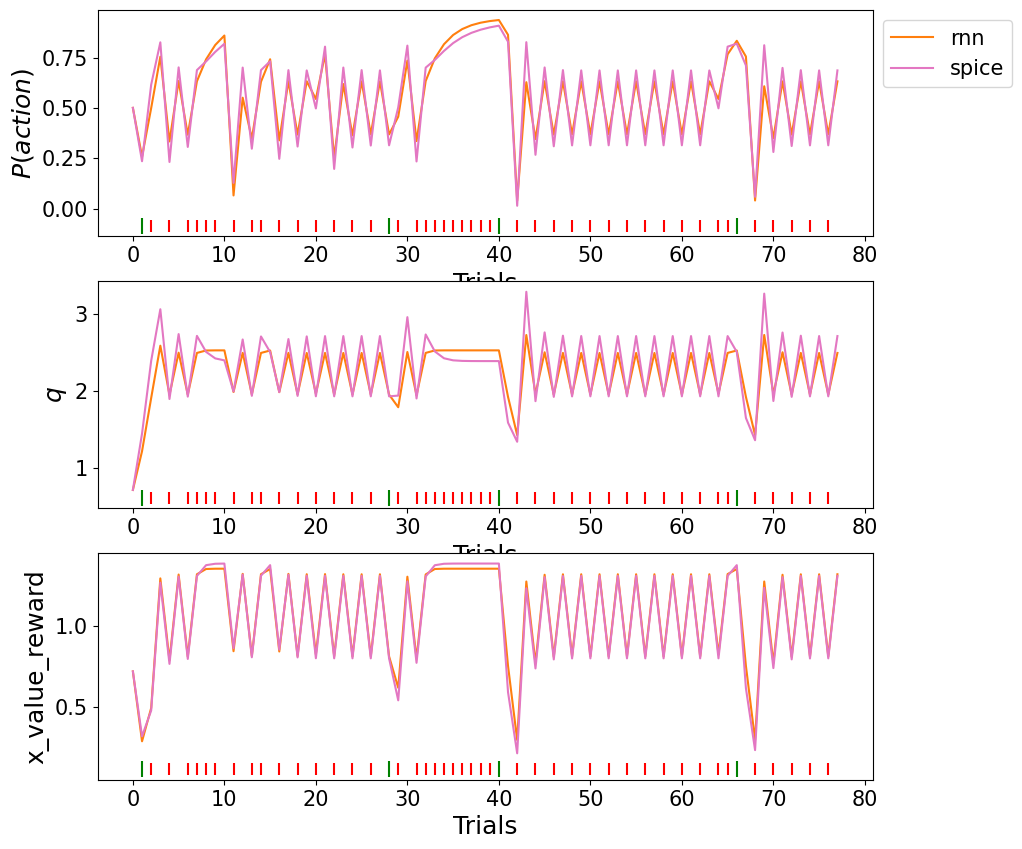

In [16]:
agents = {'rnn': estimator.rnn_agent, 'spice': estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

In [18]:
estimator.save_spice(path_rnn='weinhardt2025_rnn.pkl', path_spice='weinhardt2025_spice.pkl')
spice_estimator.save_spice(path_rnn='rw_rnn.pkl', path_spice='rw_spice.pkl')

In [23]:
class Dezfouli2019GQL(torch.nn.Module):
    
    init_values = {
        'x_value_reward': 0.5,  # Initialize Q-values to 0.5
        'x_value_choice': 0.0,  # Initialize choice histories to 0
        'x_learning_rate_reward': 0.0,  # dummy place-holder
    }
    
    def __init__(self, model: str, n_actions: int = 2, dimensions: int = 2):
        super().__init__()
        
        self.d = dimensions
        self.n_actions = n_actions
        self._n_actions = n_actions  # For compatibility
        
        # Initialize parameters based on model configuration
        if 'Phi' in model:
            self.phi_logit = torch.nn.Parameter(torch.zeros((self.d, 1)))
            self._phi_learnable = True
        else:
            self.register_buffer('phi_fixed', torch.ones((self.d, 1)))
            self._phi_learnable = False
            
        if 'Chi' in model:
            self.chi_logit = torch.nn.Parameter(torch.zeros((self.d, 1)))
            self._chi_learnable = True
        else:
            self.register_buffer('chi_fixed', torch.ones((self.d, 1)))
            self._chi_learnable = False
            
        if 'Beta' in model:
            self.beta = torch.nn.Parameter(torch.ones((self.d, 1)))
        else:
            self.register_buffer('beta', torch.ones((self.d, 1)))
            
        if 'Kappa' in model:
            self.kappa = torch.nn.Parameter(torch.zeros((self.d, 1)))
        else:
            self.register_buffer('kappa', torch.zeros((self.d, 1)))
        
        if 'C' in model:
            self.C = torch.nn.Parameter(torch.zeros(self.d, self.d))
        else:
            self.register_buffer('C', torch.zeros(self.d, self.d))
            
        self.device = torch.device('cpu')
    
    def get_phi(self):
        """Get phi parameter values."""
        if self._phi_learnable:
            return torch.sigmoid(self.phi_logit)
        else:
            return self.phi_fixed
    
    def get_chi(self):
        """Get chi parameter values."""
        if self._chi_learnable:
            return torch.sigmoid(self.chi_logit)
        else:
            return self.chi_fixed
    
    def init_forward_pass(self, inputs, prev_state, batch_first):
        if batch_first:
            inputs = inputs.permute(1, 0, 2)
        
        actions = inputs[:, :, :self.n_actions].float()
        rewards = inputs[:, :, self.n_actions:2*self.n_actions].float()
        additional_inputs = inputs[:, :, 2*self.n_actions:-3].float()
        blocks = inputs[:, :, -3:-2].int().repeat(1, 1, 2)
        
        if prev_state is not None:
            self.set_state(prev_state)
        else:
            self.set_initial_state(batch_size=inputs.shape[1])
        
        timesteps = torch.arange(actions.shape[0])
        logits = torch.zeros_like(actions)
        
        return (actions, rewards, blocks, additional_inputs), logits, timesteps
    
    def set_initial_state(self, batch_size=1):
        """Initialize the hidden state for each session."""
        state = {}
        for key in self.init_values:
            # Initialize Q-values: (batch_size, n_actions, d)
            state[key] = torch.full(
                size=[batch_size, self.n_actions, self.d], 
                fill_value=self.init_values[key], 
                dtype=torch.float32, 
            )
            
        self.set_state(state)
        return self.get_state()
    
    def set_state(self, state_dict):
        """Set the latent variables."""
        self.state = state_dict
      
    def get_state(self, detach=False):
        """Return the memory state."""
        state = self.state
        if detach:
            state = {key: state[key].detach() for key in state}
        return state
    
    def gql_update_step(self, q_values, h_values, choice, reward):
        """
        Perform GQL update step.
        
        Args:
            q_values: Current Q-values (batch_size, n_actions, d)
            h_values: Current choice histories (batch_size, n_actions, d)
            choice: Choice made (batch_size, n_actions) - one-hot encoded
            reward: Reward received (batch_size, n_actions)
        
        Returns:
            Updated q_values, h_values
        """
        batch_size = q_values.shape[0]
        
        # Get parameters
        phi = self.get_phi().T  # (1, d)
        chi = self.get_chi().T  # (1, d)
        
        # Expand choice and reward for broadcasting
        choice_expanded = choice.unsqueeze(-1)  # (batch_size, n_actions, 1)
        reward_expanded = reward.unsqueeze(-1).expand_as(q_values)  # (batch_size, n_actions, d)
        
        # Q-value updates: Q_t = (1 - phi) * Q_{t-1} + phi * reward (for chosen action)
        phi_expanded = phi.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, 1, d)
        q_update = phi_expanded * reward_expanded * choice_expanded
        q_values_new = (1 - phi_expanded) * q_values + q_update
        
        # History updates: H_t = (1 - chi) * H_{t-1} + chi (for chosen action)
        chi_expanded = chi.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, 1, d)
        h_chosen_update = chi_expanded * choice_expanded
        h_values_new = (1 - chi_expanded) * h_values + h_chosen_update
        
        return q_values_new, h_values_new
    
    def compute_action_values(self, q_values, h_values):
        """
        Compute combined action values.
        
        Args:
            q_values: Q-values (batch_size, n_actions, d)
            h_values: Choice histories (batch_size, n_actions, d)
            
        Returns:
            Combined action values (batch_size, n_actions)
        """
        batch_size = q_values.shape[0]
        
        # Weighted Q-values and histories
        beta_expanded = self.beta.T.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, 1, d)
        kappa_expanded = self.kappa.T.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, 1, d)
        
        q_weighted = torch.sum(beta_expanded * q_values, dim=-1)  # (batch_size, n_actions)
        h_weighted = torch.sum(kappa_expanded * h_values, dim=-1)  # (batch_size, n_actions)
        
        # Interaction terms: H^T * C * Q for each action
        interaction = torch.zeros(batch_size, self.n_actions)
        for a in range(self.n_actions):
            # h_a^T @ C @ q_a for each batch element
            h_a = h_values[:, a, :]  # (batch_size, d)
            q_a = q_values[:, a, :]  # (batch_size, d)
            
            # Use einsum for cleaner batch matrix multiplication
            # h_a: (batch_size, d), C: (d, d), q_a: (batch_size, d)
            # Result: (batch_size,)
            interaction[:, a] = torch.einsum('bi,ij,bj->b', h_a, self.C, q_a)
        
        return q_weighted + h_weighted + interaction
    
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass through the model."""
        input_variables, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)            
        actions, rewards, _, _ = input_variables
        
        # Get initial state
        q_values = self.state['x_value_reward']  # (batch_size, n_actions, d)
        h_values = self.state['x_value_choice']  # (batch_size, n_actions, d)
        
        # Process each timestep
        for t, (action, reward) in enumerate(zip(actions, rewards)):
            # Update Q-values and histories
            q_values, h_values = self.gql_update_step(q_values, h_values, action, reward)
            
            # Compute action values for next timestep prediction
            if t < len(actions) - 1:  # Don't predict after last timestep
                combined_values = self.compute_action_values(q_values, h_values)
                logits[t] = combined_values
        
        # Update state
        self.state['x_value_reward'] = q_values
        self.state['x_value_choice'] = h_values
        
        if batch_first:
            logits = logits.swapaxes(0, 1)
        
        return logits, self.get_state()  # Return all but last timestep

In [25]:
state_dict = torch.load("daniel/gql_dezfouli2019_benchmark.pkl", map_location=torch.device('cpu'))

RuntimeError: Invalid magic number; corrupt file?

In [28]:
from spice.resources.bandits import AgentNetwork

class AgentGQL(AgentNetwork):
    """A class that allows running a pretrained GQL model as an agent."""

    def __init__(
        self,
        model: Dezfouli2019GQL,
        deterministic: bool = True,
    ):
        """Initialize the agent network."""
        super().__init__(model_rnn=None, n_actions=model.n_actions, deterministic=deterministic)
        
        assert isinstance(model, Dezfouli2019GQL), "The passed model is not an instance of Dezfouli2019GQL."
        
        self._model = model
        self._model.eval()

    # def new_sess(self, *args, **kwargs):
    #     """Reset the network for the beginning of a new session."""
    #     self._model.set_initial_state(batch_size=1)
        
    #     # Extract state as numpy arrays for compatibility with Agent interface
    #     state = self._model.get_state()
    #     self._state = {
    #         'x_value_reward': state['x_value_reward'][0].detach().cpu().numpy(),  # (n_actions, d)
    #         'x_value_choice': state['x_value_choice'][0].detach().cpu().numpy(),  # (n_actions, d)
    #     }

    def get_betas(self):
        """Return beta and kappa values."""
        with torch.no_grad():
            beta = self._model.beta.squeeze(0)#.detach().cpu().numpy()  # (d,)
            kappa = self._model.kappa.squeeze(0)#.detach().cpu().numpy()  # (d,)
        return beta, kappa
    
    @property
    def q(self):
        """Return the action values."""
        beta, kappa = self.get_betas()
        
        # Compute weighted values
        q_weighted = torch.sum(beta * self._state['x_value_reward'].squeeze(0), dim=-1)  # (n_actions,)
        h_weighted = torch.sum(kappa * self._state['x_value_choice'].squeeze(0), dim=-1)  # (n_actions,)
        
        # Compute interaction terms
        C = self._model.C#.detach().cpu().numpy()
        interaction = torch.zeros(self._n_actions)
        for a in range(self._n_actions):
            interaction[a] = self._state['x_value_choice'].squeeze(0)[a] @ C @ self._state['x_value_reward'].squeeze(0)[a]
        
        return (q_weighted + h_weighted + interaction).detach().cpu().numpy()
    
    @property
    def q_reward(self):
        beta, _ = self.get_betas()
        q_weighted = torch.sum(beta * self._state['x_value_reward'].squeeze(0), dim=-1)  # (n_actions,)
        return (q_weighted).detach().cpu().numpy()
    
    @property
    def q_choice(self):
        _, kappa = self.get_betas()
        q_weighted = torch.sum(kappa * self._state['x_value_choice'].squeeze(0), dim=-1)  # (n_actions,)
        return (q_weighted).detach().cpu().numpy()
    
    @property
    def learning_rate_reward(self):
        return self._state['x_learning_rate_reward'][0, 0]

In [29]:
import pickle

def setup_agent_gql(path_model: str, model_config: str = "PhiChiBetaKappaC", deterministic: bool = True, **kwargs) -> AgentGQL:
    """Setup GQL agent from saved model."""
    
    # Load state dict
    with open(path_model, 'rb') as file:
        all_models = pickle.load(file)

    agent = []
    for model in all_models:
        agent.append(AgentGQL(model=model, deterministic=deterministic))
    
    n_parameters = 0
    for index_letter, letter in enumerate(model_config):
        if not letter.islower():
            n_parameters += 1 * model.d * model.d if letter == 'C' and index_letter == len(model_config)-1 else 1 * model.d
    
    return agent, n_parameters

In [30]:
agent_gql = setup_agent_gql("daniel/gql_dezfouli2019_benchmark.pkl", model_config="PhiChiBetaKappaC", deterministic=True)

In [39]:
len(agent_gql[0])

101

In [59]:
agents = {
    'rnn': estimator.rnn_agent, 
    'spice': estimator.spice_agent,
    'benchmark': agent_gql[0][0],
    }
fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

RuntimeError: shape '[2]' is invalid for input of size 4